# **Medicine and Environment Impact on Migraine**

# 1. Planteamiento del problema y contexto

## ¿Qué es la migraña?

La **migraña** es un **trastorno neurológico crónico de origen genético** que se caracteriza por **episodios recurrentes de dolor de cabeza de intensidad moderada a grave**, generalmente pulsátil y localizado en un lado de la cabeza. Se acompaña de síntomas como **náuseas, vómitos, fotofobia** (sensibilidad a la luz) **y fonofobia** (sensibilidad al sonido).(1) Estos episodios pueden durar entre 4 y 72 horas y pueden ser muy incapacitantes.(2)

Además, alrededor del 20-30 % de las personas con migraña experimentan un “aura”: señales neurológicas reversibles (visuales, sensoriales, del habla, etc.) antes o durante el dolor.(1,3)

Aunque los mecanismos exactos de la migraña no están completamente comprendidos, se cree que existe una combinación de factores genéticos y ambientales.(4) Factores desencadenantes comúnmente reportados incluyen el estrés, cambios hormonales, variaciones en el sueño, ciertos alimentos y cambios climáticos.(1)

Desde una perspectiva clínica, la migraña representa una carga significativa para la salud pública: según la Organización Mundial de la Salud, es una de las principales causas de discapacidad neurológica a nivel mundial.(5) Y es considerada la **tercera enfermedad neurológica más frecuente en el mundo** y una de las principales causas de discapacidad en adultos jóvenes, especialmente mujeres.(4)

**Referencias**:

(1) **Britannica**. Migraine. Encyclopaedia Britannica. Disponible en: https://www.britannica.com/science/migraine-pathology.

(2) **AMA Network**. Migraine Overview. Journal of the American Medical Association. Disponible en: https://jamanetwork.com/journals/jama/fullarticle/2787727.

(3) **GBD 2016 Headache Collaborators**. (2018). Global, regional, and national burden of migraine and tension-type headache, 1990–2016: a systematic analysis for the Global Burden of Disease Study 2016. The Lancet Neurology, 17(11), 954–976. → Evidencia sobre impacto global y discapacidad asociada a la migraña.

(4 )**NCBI Bookshelf**. Migraine: Pathophysiology, Diagnosis and Treatment. Disponible en: https://www.ncbi.nlm.nih.gov/books/NBK560787/

(5) **World Health Organization (WHO)**. Headache disorders. Fact sheet. Disponible en: https://www.who.int/news-room/fact-sheets/detail/headache-disorders

## Dataset

El conjunto de datos utilizado en este proyecto se titula **“Medicine and Environment Impact on Migraine”**, disponible en la plataforma Kaggle.

Es un repositorio público que permite trabajar con datos tabulares relacionados con características clínicas y ambientales que podrían influir en la migraña, lo que lo hace ideal para un proyecto de ciencia de datos aplicado al ámbito biosanitario.

*Hebaqueen. Medicine and Environment Impact on Migraine. Kaggle, disponible en: Kaggle.com/datasets/hebaqueen/medicine-and-environment-impact-on-migraine.*

El diccionario de la variables se localizan en Key2Stats:  https://www.key2stats.com/data-set/view/132.

## Pregunta principal

**¿Se puede predecir la aparición de un ataque de migraña?**

### Objetivo principal

Desarrollar y validar un modelo predictivo que estime la probabilidad de aparición de un ataque de migraña, utilizando información clínica, ambiental y de tratamiento disponible en el dataset.

### Hipótesis principal

**H0 (nula)**: No es posible predecir la aparición de un ataque de migraña mejor que el azar (el modelo no supera el baseline aleatorio  ROC-AUC ≤ 0,5 y PR-AUC ≤ prevalençia (≈ proporció de “sí”); Brier no mejora el baseline (p·(1−p))).

**H1 (alternativa)**: Es posible predecir la aparición de un ataque de migraña con un modelo basado en variables clínicas, ambientales y de tratamiento (el modelo supera el baseline (IC 95% para bootstrap) y mejora la calibración (slope≈1, intercept≈0).

### Variables

**Target (dependiente)**: headache (yes/no).

**Predictoras (independientes)**:

- **Clínicas**: hatype, age, sex

- **Ambientales**: airq

- **Tratamiento**: medication

- **Temporales**: time, dos

## Preguntas secundarias

- Tratamiento: **¿La medicación reduce la probabilidad de tener migraña?**

- Subtipo clínico: **¿El tipo de migraña influye en la aparición de ataques?**

- Ambiente: **¿La calidad del aire se asocia con mayor riesgo de ataque de migraña?**

- Factores demográficos: **¿La edad y el sexo modifican la probabilidad de ataque?**

### Metodología

- **Diseño**: estudio observacional retrospectivo longitudinal con datos de cohortes de pacientes.

- **Análisis**:

    - Modelos de clasificación (ej. regresión logística, random forest).

    - Validación cruzada para evaluar desempeño predictivo.
 
    - Métricas: AUC, sensibilidad, especificidad, precisión, brier.

- **Subanálisis**: análisis por subgrupos, ALE, PDP, ICE, SHAP.

### Nota

Informar que para la realización de este análisis se utilizará IA para la generación del código base (Python --> Copilot, R --> ChatGPT).

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, joblib, shap

from pathlib import Path
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, train_test_split, GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (roc_auc_score, average_precision_score, brier_score_loss, confusion_matrix, roc_curve, 
precision_recall_curve, auc, precision_score, recall_score, f1_score)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.base import clone
from scipy.special import logit
from collections import Counter

# Semilla
SEED = 42
np.random.seed(SEED)

# Configurar R
os.environ['R_HOME'] = r"C:/PROGRA~1/R/R-45~1.2"

# Ejecutar código R dentro de Jupyter
%load_ext rpy2.ipython

# Crear carpetas
folders = [
    "data/raw",
    "data/processed",
    "reports/figures",
    "reports/tables",
    "models"
]

for folder in folders:
    os.makedirs(folder, exist_ok=True)

print("Estructura de carpetas creada dentro de 'Proyecto final'")

# Definir rutas principales
base_dir = os.getcwd()  

data_dir       = os.path.join(base_dir, "data")
raw_dir        = os.path.join(data_dir, "raw")
processed_dir  = os.path.join(data_dir, "processed")
models_dir     = os.path.join(base_dir, "models")
reports_dir    = os.path.join(base_dir, "reports")
tables_dir     = os.path.join(reports_dir, "tables")
figures_dir    = os.path.join(reports_dir, "figures")

# Comprobación rápida
print("Rutas configuradas correctamente:")
print(f"Tables: {tables_dir}")
print(f"Figures: {figures_dir}")
print(f"Processed: {processed_dir}")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Estructura de carpetas creada dentro de 'Proyecto final'
Rutas configuradas correctamente:
Tables: C:\Users\patri\Proyecto final\reports\tables
Figures: C:\Users\patri\Proyecto final\reports\figures
Processed: C:\Users\patri\Proyecto final\data\processed


In [3]:
%%R
# Detectar sistema operativo
if (.Platform$OS.type == "windows") {
    Sys.setlocale("LC_ALL", "Spanish_Spain.1252")  # Windows
} else {
    Sys.setlocale("LC_ALL", "es_ES.UTF-8")        # Linux / macOS
}

# Cargar librerias
suppressPackageStartupMessages({
  library(dplyr)
  library(epiR)
  library(ggplot2)
  library(vcd)         # chi-cuadrado y Fisher
  library(epitools)    # riesgo relativo y odds ratio
  library(corrplot)    # heatmaps de correlaciones
  library(tidyr)
  library(knitr)
  library(readr)
  library(geepack)
  library(brglm2)
  library(clubSandwich)
  library(stringi)
  library(pROC)
  library(sandwich)
  library(lmtest)
  library(data.table)   # para fread
  library(iml)          # SHAP, PDP, ICE, ALE
  library(pdp)          # PDP
  library(DALEX)        # explicabilidad avanzada
  library(vip)          # permutation importance
  library(yardstick)
})

cat("Librerias cargadas correctamente.\n")

Librerias cargadas correctamente.


In [8]:
# 1.1 Carga de los datos
csv_path = os.path.join("data", "raw", "migraine.csv")
df = pd.read_csv(csv_path)
print(df.head())

# Target
df['target'] = df['headache']
counts = df['target'].value_counts()
percentages = (df['target'].value_counts(normalize=True) * 100).round(2)

summary = counts.to_frame('count').assign(percentage = percentages.values)
display(summary)

   rownames  id  time  dos hatype  age  airq  medication headache     sex
0         1   1   -11  753   Aura   30   9.0  continuing      yes  female
1         2   1   -10  754   Aura   30   7.0  continuing      yes  female
2         3   1    -9  755   Aura   30  10.0  continuing      yes  female
3         4   1    -8  756   Aura   30  13.0  continuing      yes  female
4         5   1    -7  757   Aura   30  18.0  continuing      yes  female


,count,percentage
target,,
yes,2666,64.21
no,1486,35.79


In [28]:
# 1.2 Diccionario de las variables
data_dict = {
    "Variable": [
        "rownames", "id", "time", "dos", "hatype",
        "age", "airq", "medication", "headache", "sex"
    ],
    "Tipo": [
        "Entera", "Entera", "Entera", "Entera", "Categórica",
        "Entera", "Numérica", "Categórica", "Categórica", "Categórica"
    ],
    "Descripción": [
        "Índice del registro",
        "Identificador único del paciente",
        "Índice temporal relativo al tratamiento de la migraña",
        "Días de estudio",
        "Tipo de migraña",
        "Edad del paciente",
        "Calidad del aire (índice ambiental)",
        "Tipo de medicación",
        "Presencia de dolor de cabeza en el registro",
        "Sexo del paciente"
    ],
    "Rango": [
        "1 – 4152",
        "1 – 133",
        "0 – 23",
        "98 – 1239",
        "Aura, No Aura, Mixed",
        "18 – 66",
        "3 – 73",
        "continuing, reduced, none",
        "yes, no",
        "female, male"
    ],
    "Unidades": [
        None, None, "días", "días", None,
        "años", "Índice de calidad del aire (AQI)", None, None, None
    ],
    "Observaciones": [
        "Único para cada registro; no es un identificador clínico",
        "Cada paciente tiene múltiples registros (longitudinal)",
        "Valores negativos: días antes del inicio del tratamiento; 0: día de inicio, valores positivos: días posteriores.",
        "Número de días transcurridos desde el comienzo del estudio (1 de enero del primer año)",
        "Variable nominal con 3 categorías",
        "Distribución centrada en adultos",
        "Probablemente concentración de PM2.5 o índice de contaminación",
        "Indica régimen de tratamiento",
        "Variable binaria (target)",
        "Variable binaria"
    ]
}

# Crear DataFrame
df_dict = pd.DataFrame(data_dict)

# Mostrar el diccionario de variables
display(df_dict)

# Guardar
output_file = os.path.join(tables_dir, "12_dictionary_df.csv")
df_dict.to_csv(output_file, index=True)

,Variable,Tipo,Descripción,Rango,Unidades,Observaciones
0,rownames,Entera,Índice del registro,1 – 4152,None,Único para cada registro; no es un identificad...
1,id,Entera,Identificador único del paciente,1 – 133,None,Cada paciente tiene múltiples registros (longi...
2,time,Entera,Índice temporal relativo al tratamiento de la ...,0 – 23,días,Valores negativos: días antes del inicio del t...
3,dos,Entera,Días de estudio,98 – 1239,días,Número de días transcurridos desde el comienzo...
4,hatype,Categórica,Tipo de migraña,"Aura, No Aura, Mixed",None,Variable nominal con 3 categorías
5,age,Entera,Edad del paciente,18 – 66,años,Distribución centrada en adultos
6,airq,Numérica,Calidad del aire (índice ambiental),3 – 73,Índice de calidad del aire (AQI),Probablemente concentración de PM2.5 o índice ...
7,medication,Categórica,Tipo de medicación,"continuing, reduced, none",None,Indica régimen de tratamiento
8,headache,Categórica,Presencia de dolor de cabeza en el registro,"yes, no",None,Variable binaria (target)
9,sex,Categórica,Sexo del paciente,"female, male",None,Variable binaria


# 2 Descripción, inspección y limpieza de datos

In [15]:
# 2.1 Descripción de los datos (Python)
# Para guardar
base_dir = r"C:\Users\patri\Proyecto final"
reports_dir = os.path.join(base_dir, "reports")
os.makedirs(reports_dir, exist_ok=True)

# Información general
print("Número de filas y columnas:", df.shape)
print("\nPrimeras filas del dataset:")
display(df.head())

# Vista rápida de las primeras filas
print("\nPrimeras filas del dataset:")
display(df.head())

# Número de casos y prevalencia de la clase positiva
target_counts = df['target'].value_counts()
target_percent = df['target'].value_counts(normalize=True) * 100

prevalencia_df = target_counts.to_frame(name='n')
prevalencia_df['%'] = target_percent.round(2)

print("\nPrevalencia de headache (target):")
display(prevalencia_df)

# Estadística variables numéricas
print("\nEstadística descriptiva de variables numéricas")
display(df[['time','dos','age','airq']].describe().T)

# Frecuencias de variables categóricas
categoricas = ['hatype','medication','sex']

tabla_frecuencias = []

for col in categoricas:
    abs_count = df[col].value_counts()
    pct_count = (df[col].value_counts(normalize=True) * 100).round(2)

    tmp = pd.DataFrame({
        'variable': col,
        'categoria': abs_count.index,
        'frecuencia': abs_count.values,
        'porcentaje': pct_count.values
    })

    tabla_frecuencias.append(tmp)

tabla_frecuencias = pd.concat(tabla_frecuencias, ignore_index=True)
print("\nFrecuencias de variables categóricas")
display(tabla_frecuencias)

# Guardar 
os.makedirs(tables_dir, exist_ok=True)
descripcion_path = os.path.join(tables_dir, "21_descripcion_dataset.txt")
with open(descripcion_path, "w") as f:
    f.write(f"Número de filas y columnas: {df.shape}\n\n")
    f.write("Tipos de variables:\n")
    f.write(str(df.dtypes) + "\n\n")
    f.write("Primeras filas del dataset:\n")
    f.write(df.head().to_string() + "\n\n")
    f.write("Prevalencia de headache (target):\n")
    f.write(prevalencia_df.to_string() + "\n")
    f.write("Estadística descriptiva de variables numéricas:\n")
    f.write(df[['time','dos','age','airq']].describe().T.to_string() + "\n")
    f.write("Frecuencias de variables categóricas:\n")
    f.write(tabla_frecuencias.to_string(index=False) + "\n")

# Comprobación
if os.path.exists(descripcion_path):
    print(f"El archivo '21_descripcion_dataset.txt' se encuentra en Tables.")
else:
    print(f"El archivo '21_descripcion_dataset.txt' NO se encuentra en Tables.")

Número de filas y columnas: (4152, 11)

Primeras filas del dataset:


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target
0,1,1,-11,753,Aura,30,9.0,continuing,yes,female,yes
1,2,1,-10,754,Aura,30,7.0,continuing,yes,female,yes
2,3,1,-9,755,Aura,30,10.0,continuing,yes,female,yes
3,4,1,-8,756,Aura,30,13.0,continuing,yes,female,yes
4,5,1,-7,757,Aura,30,18.0,continuing,yes,female,yes



Primeras filas del dataset:


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target
0,1,1,-11,753,Aura,30,9.0,continuing,yes,female,yes
1,2,1,-10,754,Aura,30,7.0,continuing,yes,female,yes
2,3,1,-9,755,Aura,30,10.0,continuing,yes,female,yes
3,4,1,-8,756,Aura,30,13.0,continuing,yes,female,yes
4,5,1,-7,757,Aura,30,18.0,continuing,yes,female,yes



Prevalencia de headache (target):


,n,%
target,,
yes,2666,64.21
no,1486,35.79



Estadística descriptiva de variables numéricas


,count,mean,std,min,25%,50%,75%,max
time,4152.0,15.455684,21.737211,-29.0,3.0,12.0,24.0,99.0
dos,4152.0,646.705925,335.770123,98.0,384.0,623.0,950.0,1239.0
age,4152.0,42.363921,11.201244,18.0,33.0,44.0,50.0,66.0
airq,4152.0,24.826012,9.514274,3.0,18.0,24.0,29.0,73.0



Frecuencias de variables categóricas


,variable,categoria,frecuencia,porcentaje
0,hatype,No Aura,1985,47.81
1,hatype,Aura,1710,41.18
2,hatype,Mixed,457,11.01
3,medication,continuing,2386,57.47
4,medication,reduced,981,23.63
5,medication,none,785,18.91
6,sex,female,3545,85.38
7,sex,male,607,14.62


El archivo '21_descripcion_dataset.txt' se encuentra en Tables.


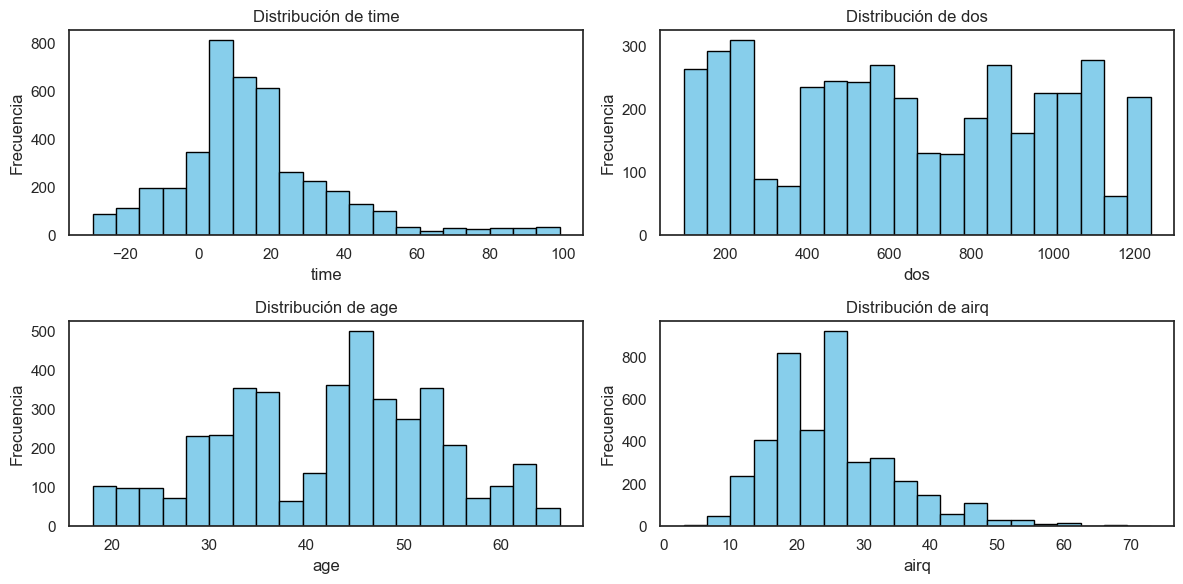


Distribuciones numéricas: Guardadas


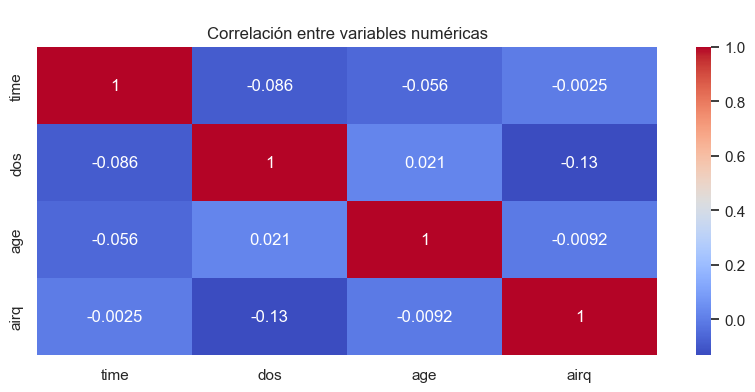


Correlación entre variables numéricas: Guardadas


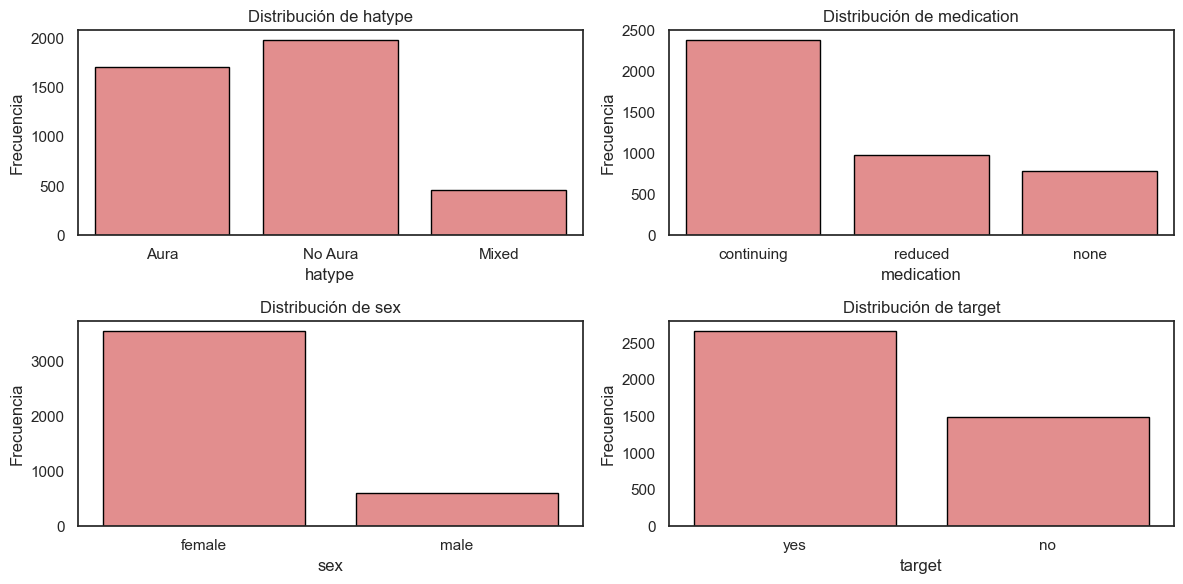


Distribuciones categóricas: Guardadas


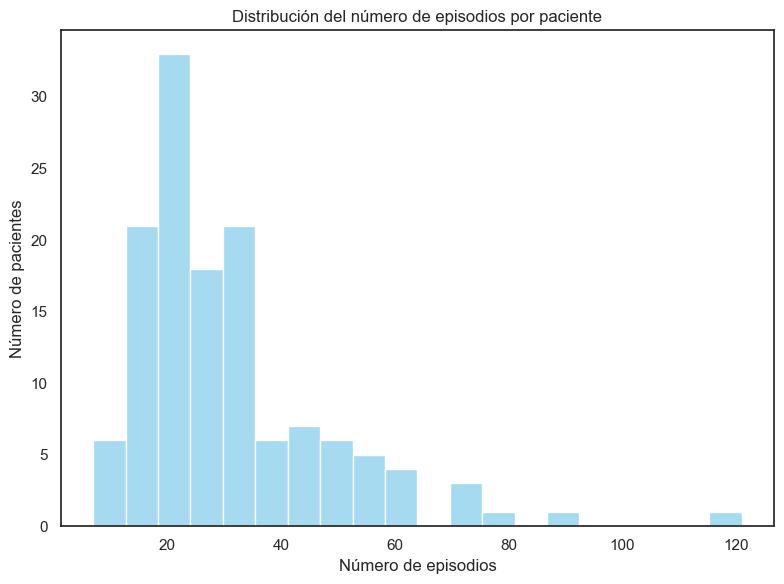

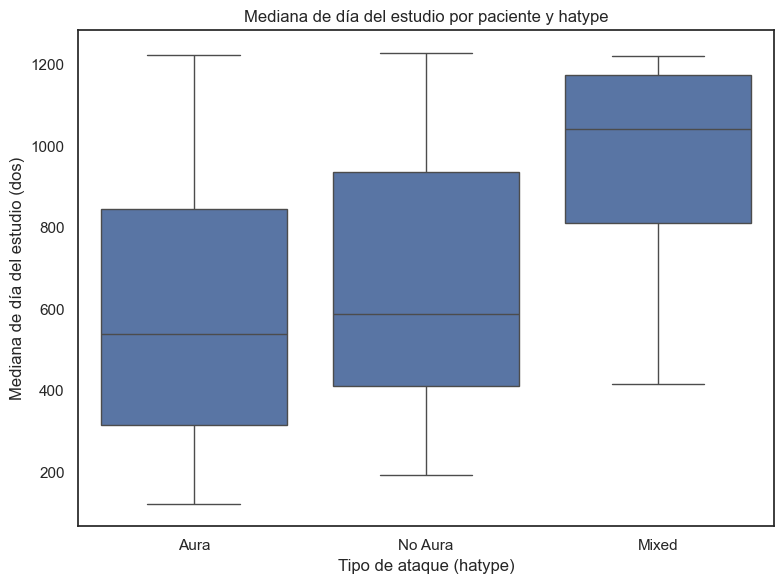

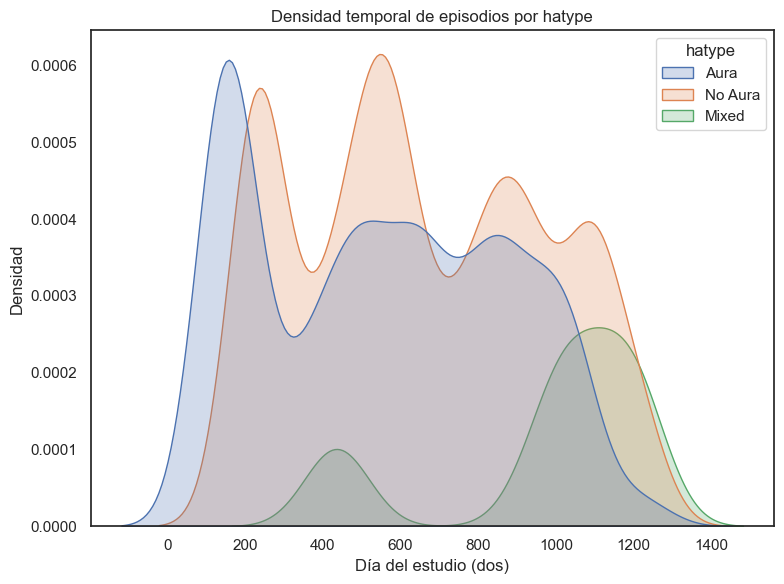

Figuras guardadas en: C:\Users\patri\Proyecto final\reports\figures


In [16]:
# Configuración general
os.makedirs(figures_dir, exist_ok=True)
sns.set(style="white")  
plt.rcParams['figure.figsize'] = (10,4) 

# 2.2 Distribuciones numéricas
num_cols = ['time', 'dos', 'age', 'airq']
fig, axes = plt.subplots(nrows=(len(num_cols)+1)//2, ncols=2, figsize=(12,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

# Eliminar ejes vacios si n_cols > n_features
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Guardar y comprobar
fig.savefig(os.path.join(figures_dir, "22_distribuciones_numericas.png"), dpi=300)
fig_path = os.path.join(figures_dir, "22_distribuciones_numericas.png")
print("\nDistribuciones numéricas:", "Guardadas" if os.path.exists(fig_path) else "No encontradas")

# 2.3 Correlaciones numéricas
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("\nCorrelación entre variables numéricas")
plt.show()

# Guardar y comprobar
fig.savefig(os.path.join(figures_dir, "23_correlacion_numericas.png"), dpi=300)
fig_path = os.path.join(figures_dir, "23_correlacion_numericas.png")
print("\nCorrelación entre variables numéricas:", "Guardadas" if os.path.exists(fig_path) else "No encontradas")

# 2.4 Distribuciones categóricas
cat_cols = ['hatype', 'medication', 'sex', 'target']
fig, axes = plt.subplots(nrows=(len(cat_cols)+1)//2, ncols=2, figsize=(12,6))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axes[i], color='lightcoral', edgecolor='black')
    axes[i].set_title(f"Distribución de {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frecuencia")

# Eliminar ejes vacios si n_cols > n_features
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Guardar y comprobar
fig.savefig(os.path.join(figures_dir, "24_distribuciones_categoricas.png"), dpi = 300)
fig_path = os.path.join(figures_dir, "24_distribuciones_categoricas.png")
print("\nDistribuciones categóricas:", "Guardadas" if os.path.exists(fig_path) else "No encontradas")

# 2.5 Histograma del número de episodios por paciente
df_summary = df.groupby('id')['dos'].count().reset_index(name='episodios')

fig, ax = plt.subplots(figsize=(8,6))
sns.histplot(df_summary['episodios'], bins=20, color='skyblue', ax=ax)
ax.set_title("Distribución del número de episodios por paciente")
ax.set_xlabel("Número de episodios")
ax.set_ylabel("Número de pacientes")

plt.tight_layout()
fig.savefig(os.path.join(figures_dir, "25_episodios_por_paciente.png"), dpi=300)
plt.show()
plt.close(fig)

# 2.6 Boxplot de la mediana de 'dos' por paciente y hatype
df_patient = df.groupby(['id','hatype'])['dos'].median().reset_index(name='dos_median')

fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(x='hatype', y='dos_median', data=df_patient, ax=ax)
ax.set_title("Mediana de día del estudio por paciente y hatype")
ax.set_xlabel("Tipo de ataque (hatype)")
ax.set_ylabel("Mediana de día del estudio (dos)")

plt.tight_layout()
fig.savefig(os.path.join(figures_dir, "26_mediana_dos_por_hatype.png"), dpi=300)
plt.show()
plt.close(fig)

# 2.7 Densidad temporal de 'dos' por hatype
fig, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=df, x='dos', hue='hatype', fill=True, ax=ax)
ax.set_title("Densidad temporal de episodios por hatype")
ax.set_xlabel("Día del estudio (dos)")
ax.set_ylabel("Densidad")

plt.tight_layout()
fig.savefig(os.path.join(figures_dir, "27_densidad_dos_por_hatype.png"), dpi=300)
plt.show()
plt.close(fig)

print("Figuras guardadas en:", figures_dir)

**Estructura general del dataset**

Dataset con 4152 filas y 10 columnas con variables numéricas (time, dos, age, airq) y categóricas (hatype, medication, target, sex).

A primera vista, ninguna columna presenta un formato incorrecto.

**Target** --> distribución muy desequilibrada (64,2% yes vs 35,8% no)

En el análisis será necesario controlar las métricas sensibles a desequilibrio (AUC-PR, sensibilidad, F1 por clase minoritaria) y evaluar la calibración porque los modelos tienden a sobreestimar la clase mayoritaria.

**Variables numéricas**

- **time** --> no se debe usar directamente como predictor sin considerar la naturaleza temporal. Conviene crear indicadores como “periodo pretratamiento vs postratamiento”, curvas longitudinales o modelos de series temporales o mixtos.

- **dos** --> refleja un crono-seguimiento a largo plazo (más de 3 años). Debe transformarse en componentes estacionales (mes, estación) o en tendencias (año del estudio). Usarlo sin transformar puede inducir patrones espurios.

- **age** --> distribución razonablemente centrada, sin outliers evidentes. Podría estratificarse en bandas. No hay personas mayores de 66 años debido a que cuando el cuerpo está hormonalmente estable (menopausia en las mujeres), la sensibilidad sufre una disminución drástica.

- **airq** --> mucha variabilidad.

**Variables categóricas**

- **hatype** --> distribución equilibrada entre Aura y No Aura, con minoría Mixed (acorde con los datos clínicos generales). Puede ser un predictor fuerte del target.

- **medication** --> sesgo fuerte hacia tratamiento activo continuado, lo que puede generar confusión entre estado clínico y plan terapéutico y necesidad de ajustar por medication si se modela causalmente (en la realidad estos pacientes necesitan tratamientos contínuos para prevenir los ataques).

- **sex** --> claramente desbalanceado. Los modelos pueden aprender patrones diferenciados por sexo sin suficiente representación masculina. Puede ser relevante para fairness si el objetivo es diagnóstico clínico (En clínica es habitual que haya más mujeres que hombres ya que las fluctuaciones de estrógenos aumentan la sensibilidad. Este dataset refleja el patrón epidemiológico esperado y no indica un sesgo anómalo en la muestra)

**Calidad y diseño del dataset**

- Sesgos y limitaciones potenciales

- Sesgo de sexo muy marcado → riesgo de mal rendimiento en hombres.

- Target desbalanceado → necesidad de ponderación o métricas robustas.

- Variables temporales complejas → no terminan de funcionar para discernir entre migraña y no.

- Estructura longitudinal: múltiples filas por individuo (id aparece repetido).


Normalización de las variables categóricas:


'hatype'

array(['aura', 'no aura', 'mixed'], dtype=object)

'medication'

array(['continuing', 'reduced', 'none'], dtype=object)

'sex'

array(['female', 'male'], dtype=object)

'target'

array(['yes', 'no'], dtype=object)


Valores nulos por columna:


rownames      0
id            0
time          0
dos           0
hatype        0
age           0
airq          0
medication    0
headache      0
sex           0
target        0
dtype: int64

Duplicados encontrados: 1

Dataset limpio guardado en: C:\Users\patri\Proyecto final\data\processed\28_dataset_limpio.csv
time tiene 210 outliers
dos tiene 0 outliers
age tiene 0 outliers
airq tiene 157 outliers

Outliers guardados en: C:\Users\patri\Proyecto final\reports\tables


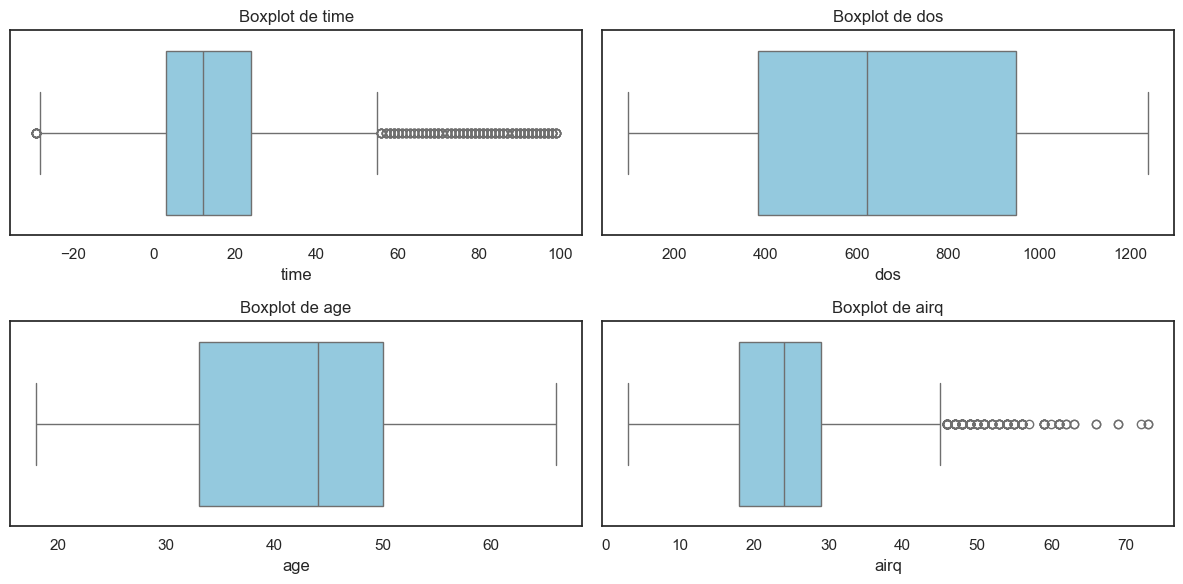


Boxplots outliers guardados en: C:\Users\patri\Proyecto final\reports\figures\28_boxplots_outliers_numericas.png

Variable: time
Límite inferior: -28.50, Límite superior: 55.50
Número de outliers: 210

Ejemplos de registros:


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target
58,59,2,77,204,aura,36,15.0,continuing,yes,female,yes
59,60,2,78,205,aura,36,19.0,continuing,yes,female,yes
60,61,2,79,206,aura,36,30.0,continuing,yes,female,yes
61,62,2,80,207,aura,36,24.0,continuing,yes,female,yes
62,63,2,81,208,aura,36,41.0,continuing,yes,female,yes



Variable: airq
Límite inferior: 1.50, Límite superior: 45.50
Número de outliers: 157

Ejemplos de registros:


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target
329,330,8,15,226,aura,43,48.0,continuing,yes,female,yes
330,331,8,16,227,aura,43,53.0,continuing,yes,female,yes
460,461,12,4,187,no aura,24,59.0,reduced,yes,female,yes
462,463,12,6,189,no aura,24,49.0,reduced,yes,female,yes
463,464,12,10,193,no aura,24,59.0,reduced,yes,female,yes


In [17]:
# 2.8 Limpieza y transformación de los datos (Python)
# Normalizar variables categóricas
print("\nNormalización de las variables categóricas:")
df[cat_cols] = df[cat_cols].apply(lambda col: col.astype(str).str.strip().str.lower())

# Comprobación: valores únicos finales
for col in cat_cols:
    display(col, df[col].unique())

# Valores nulos
print("\nValores nulos por columna:")
display(df.isnull().sum())

# Verificar duplicados por id y dos
num_duplicados = df.duplicated(subset=['id','dos']).sum()
print(f"Duplicados encontrados: {num_duplicados}")

# Eliminar duplicados
df = df.drop_duplicates(subset=['id','dos'])

# Guardar y comprobar
os.makedirs(processed_dir, exist_ok=True)
dataset_limpio_path = os.path.join(processed_dir, "28_dataset_limpio.csv")
df.to_csv(dataset_limpio_path, index=False)
print("\nDataset limpio guardado en:", os.path.abspath(dataset_limpio_path))

# Outliers básicos usando IQR
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    print(f"{col} tiene {len(outliers)} outliers")

# Definir función
def detectar_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers, lower, upper

# Guardar y comprobar
os.makedirs(tables_dir, exist_ok=True)

outliers_time, _, _ = detectar_outliers(df, 'time')
outliers_airq, _, _ = detectar_outliers(df, 'airq')

outliers_time.to_csv(os.path.join(tables_dir, "28_outliers_time.csv"), index=False)
outliers_airq.to_csv(os.path.join(tables_dir, "28_outliers_airq.csv"), index=False)

print("\nOutliers guardados en:", tables_dir)

# Visualización
fig, axes = plt.subplots(nrows=(len(num_cols)+1)//2, ncols=2, figsize=(12,6))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot de {col}")

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Guardar
os.makedirs(figures_dir, exist_ok=True)
fig_path = os.path.join(figures_dir, "28_boxplots_outliers_numericas.png")
fig.savefig(fig_path, dpi=300)

print("\nBoxplots outliers guardados en:", fig_path)

# Filtrar outliers con criterio IQR y revisar registros
def detectar_outliers(df, col):
    # Calcular IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Definir límites
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Filtrar registros fuera de rango
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers, lower, upper

# Revisar variables con outliers
for col in ['time','airq']:
    outliers, lower, upper = detectar_outliers(df, col)
    print(f"\nVariable: {col}")
    print(f"Límite inferior: {lower:.2f}, Límite superior: {upper:.2f}")
    print(f"Número de outliers: {outliers.shape[0]}")
    print("\nEjemplos de registros:")
    display(outliers.head())

### Imputación

- Se verifica que no existen valores nulos en ninguna columna, por lo que no se aplica ninguna imputación.

### Análisis de outliers en la variable `time`

- **Método aplicado:** criterio IQR (1.5 × rango intercuartílico).
- Los valores **negativos** de time representan días previos al inicio del tratamiento de migraña.  
- El valor **0** corresponde al día de inicio del tratamiento.  
- Los valores **positivos** indican días posteriores al inicio del tratamiento, reflejando la evolución del paciente.  
- Los valores altos (ej. 77, 99) corresponden a pacientes con seguimiento prolongado, no a errores de captura.

### Análisis de outliers en la variable `airq`

- **Método aplicado:** criterio IQR (1.5 × rango intercuartílico).
- Los valores altos (>45.5) son plausibles clínicamente, ya que reflejan episodios de contaminación elevada o condiciones ambientales extremas.
- No se consideran errores de captura, ya que aparecen en múltiples pacientes y son consistentes.

,Número de registros
fase,
Con tratamiento,3451
Sin tratamiento,700


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target,fase
0,1,1,-11,753,aura,30,9.0,continuing,yes,female,yes,Sin tratamiento
1,2,1,-10,754,aura,30,7.0,continuing,yes,female,yes,Sin tratamiento
2,3,1,-9,755,aura,30,10.0,continuing,yes,female,yes,Sin tratamiento
3,4,1,-8,756,aura,30,13.0,continuing,yes,female,yes,Sin tratamiento
4,5,1,-7,757,aura,30,18.0,continuing,yes,female,yes,Sin tratamiento


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex,target,fase
7,8,1,22,786,aura,30,21.0,continuing,yes,female,yes,Con tratamiento
8,9,1,23,787,aura,30,21.0,continuing,yes,female,yes,Con tratamiento
9,10,1,24,788,aura,30,18.0,continuing,yes,female,yes,Con tratamiento
10,11,1,25,789,aura,30,14.0,continuing,yes,female,yes,Con tratamiento
11,12,1,26,790,aura,30,12.0,continuing,yes,female,yes,Con tratamiento


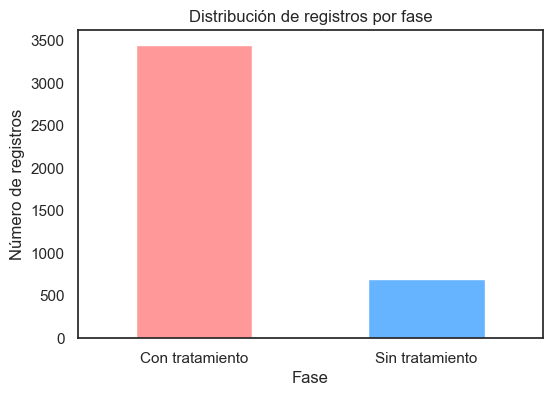


Distribución por fases: Guardada


In [21]:
# 2.9 Nuevas variables
df = pd.read_csv(dataset_limpio_path)

# 2.9.1 Clasificación de fases
# Crear una nueva columna 'fase' según el valor de time
df['fase'] = np.where(df['time'] < 0, 'Sin tratamiento', 'Con tratamiento')

# Conteo por fase
fase_counts = df['fase'].value_counts()
display(fase_counts.to_frame(name="Número de registros"))

# Comprobación: conteo por fase
display(df[df['fase']=="Sin tratamiento"].head())
display(df[df['fase']=="Con tratamiento"].head())

# Crear figura
fig, ax = plt.subplots(figsize=(6,4))
fase_counts.plot(kind='bar', color=['#ff9999','#66b3ff','#99ff99'], ax=ax)
ax.set_title('Distribución de registros por fase')
ax.set_xlabel('Fase')
ax.set_ylabel('Número de registros')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

# Guardar
os.makedirs(figures_dir, exist_ok=True)

fase_fig = os.path.join(figures_dir, "291_fase_distribution.png")
fig.savefig(fase_fig, dpi=300)

# Comprobación
print("\nDistribución por fases:", "Guardada" if os.path.exists(fase_fig) else "No encontrada")


 Variables derivadas de dos:



,dos,month_study,season_study
0,753,1,winter
1,754,1,winter
2,755,1,winter
3,756,1,winter
4,757,1,winter



Meses únicos: [ 1  2  3  5  6  7  4  8  9 10 11 12]

Estaciones únicas: ['winter' 'spring' 'summer' 'autumn']
Rango de days_since_first_visit: 0 – 128
   id  dos  days_since_first_visit
0   1  753                       0
1   1  754                       1
2   1  755                       2
3   1  756                       3
4   1  757                       4


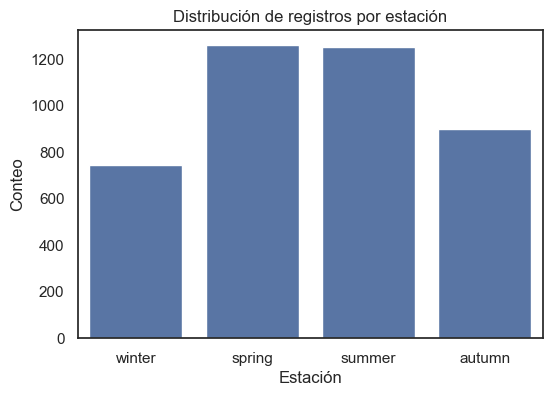

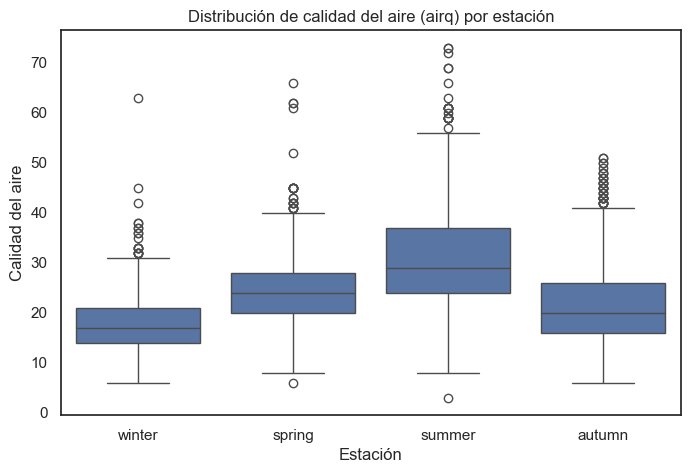


Gráficas guardadas en: C:\Users\patri\Proyecto final\reports\figures


In [32]:
# 2.9.2 Componentes estacionales y tendencias (para dos)
# Fecha origen en '1997-01-01' (año no comprobado pero sacado de la información del dataset)
df['date_study'] = pd.to_datetime("1997-01-01") + pd.to_timedelta(df['dos'], unit="D")
df['month_study'] = df['date_study'].dt.month

# Estación según mes
season_map = {
    12: 'winter', 1: 'winter', 2: 'winter',
    3: 'spring', 4: 'spring', 5: 'spring',
    6: 'summer', 7: 'summer', 8: 'summer',
    9: 'autumn', 10: 'autumn', 11: 'autumn'
}
df['season_study'] = df['month_study'].map(season_map)

print("\n Variables derivadas de dos:\n")
display(df[['dos', 'month_study', 'season_study']].head())

# Resumen de valores únicos por cada nueva columna
print("\nMeses únicos:", df['month_study'].unique())
print("\nEstaciones únicas:", df['season_study'].unique())

# Progresión interna de cada paciente: días desde su primera visita
df['days_since_first_visit'] = df.groupby('id')['dos'].transform(lambda x: x - x.min())

# Rango
min_days_since_first_visit = df['days_since_first_visit'].min()
max_days_since_first_visit = df['days_since_first_visit'].max()
print(f"Rango de days_since_first_visit: {min_days_since_first_visit} – {max_days_since_first_visit}")

# Comprobación rápida
print(df[['id','dos','days_since_first_visit']].head())

# Visualizaciones
os.makedirs(figures_dir, exist_ok=True)

# Barras de season_study (conteo por estación)
plt.figure(figsize=(6,4))
sns.countplot(x='season_study', data=df, order=['winter','spring','summer','autumn'])
plt.title("Distribución de registros por estación")
plt.xlabel("Estación")
plt.ylabel("Conteo")
plt.show()
fig.savefig(os.path.join(figures_dir, "292_season_distribution.png"), dpi=300)

# Boxplot de airq por season_study
plt.figure(figsize=(8,5))
sns.boxplot(x='season_study', y='airq', data=df, order=['winter','spring','summer','autumn'])
plt.title("Distribución de calidad del aire (airq) por estación")
plt.xlabel("Estación")
plt.ylabel("Calidad del aire")
plt.show()
fig.savefig(os.path.join(figures_dir, "292_airq_season.png"), dpi=300)

print("\nGráficas guardadas en:", os.path.abspath(figures_dir))

In [24]:
# 2.9.3 Age_band
df['age_band'] = pd.cut(df['age'], bins=[17,30,40,50,66], labels=['18-30','31-40','41-50','51-66'])

# Distribución por age_band
print(df['age_band'].value_counts())

# 2.9.4 Ponderación de sex en función del target
sample_weights = compute_sample_weight(class_weight='balanced', y=df['target'])
df['sample_weight'] = sample_weights

# Distribución por sex y target
print("\nDistribución por sex y target")
display(pd.crosstab(df['sex'], df['target']))

age_band
41-50    1456
51-66    1020
31-40     952
18-30     723
Name: count, dtype: int64

Distribución por sex y target


target,no,yes
sex,,
female,1265,2279
male,220,387



Resumen estadístico del número de visitas por paciente:


,count,mean,std,min,25%,50%,75%,max
n_visitas,4151.0,20.930137,17.795246,1.0,8.0,16.0,28.0,121.0



Tabla guardada en: C:\Users\patri\Proyecto final\reports\tables


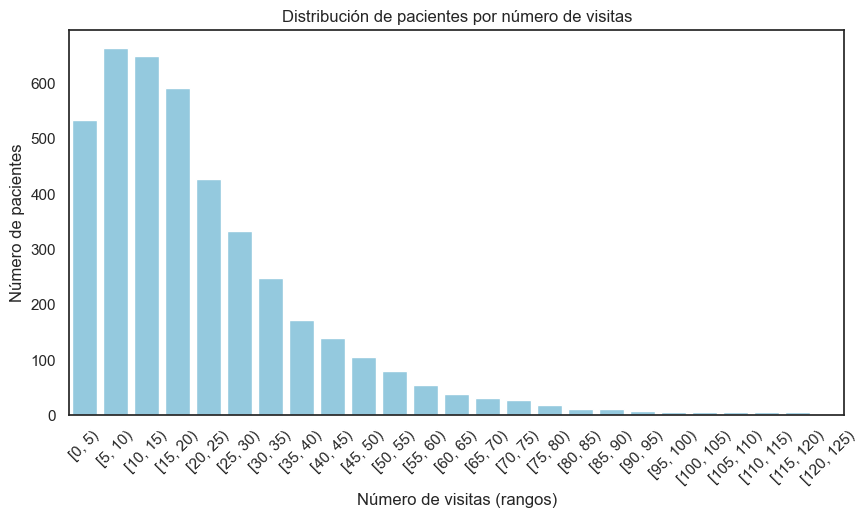


Distribución de pacientes por número de visitas: Guardada
Rango de airq_prev_mean: 8.0 – 56.0
Rango de prev_attacks: 0.0 – 77.0

Promedio de airq previo y número de ataques previos: 


,id,time,target,airq_prev_mean,prev_attacks
0,1,-11,yes,NaN,0.0
1,1,-10,yes,9.000000,1.0
2,1,-9,yes,8.000000,2.0
3,1,-8,yes,8.666667,3.0
4,1,-7,yes,9.750000,4.0
5,1,-6,yes,11.400000,5.0
6,1,-5,yes,12.666667,6.0
7,1,22,yes,13.285714,7.0
8,1,23,yes,14.250000,8.0
9,1,24,yes,15.000000,9.0


In [30]:
# 2.9.5 Número de visitas por paciente (para control longitudinal):
# Número de visitas por paciente
df['n_visitas'] = df.groupby('id').cumcount() + 1

# Estadística descriptiva del número de visitas
resumen_visitas = df['n_visitas'].describe().to_frame().T
print("\nResumen estadístico del número de visitas por paciente:")
display(resumen_visitas)

# Guardar tabla de visitas y duplicados para trazabilidad
os.makedirs(tables_dir, exist_ok=True)
resumen_visitas.rename_axis("stat").rename(columns={0: "n_visitas"}) \
    .to_csv(os.path.join(tables_dir, "295_visitas_por_paciente.csv"))

print("\nTabla guardada en:", os.path.abspath(tables_dir))

#Gráfica
# Crear bins para agrupar las visitas (ajusta el tamaño según te interese)
bins = range(0, df['n_visitas'].max() + 5, 5)  # cada 5 visitas
visitas_binned = pd.cut(df['n_visitas'], bins=bins, right=False)

# Contar cuántos pacientes hay en cada bin
conteo_bins = visitas_binned.value_counts().sort_index()

plt.figure(figsize=(10,5))
sns.barplot(x=conteo_bins.index.astype(str), y=conteo_bins.values, color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Número de visitas (rangos)')
plt.ylabel('Número de pacientes')
plt.title('Distribución de pacientes por número de visitas')
plt.show()

# Guardar y comprobar
os.makedirs(figures_dir, exist_ok=True)
fase_fig = os.path.join(figures_dir, "295_distribution_pac_n_visitas.png")
fig.savefig(fase_fig, dpi=300)

print("\nDistribución de pacientes por número de visitas:", "Guardada" if os.path.exists(fase_fig) else "No encontrada")

# Convertir target a numérico
df['target_num'] = df['target'].map({'yes': 1, 'no': 0})

# Ordenar por paciente y tiempo
df = df.sort_values(['id', 'time'])

# 2.9.6 Promedio de airq previo
df['airq_prev_mean'] = df.groupby('id')['airq'].transform(lambda x: x.shift(1).expanding().mean())

# Rango
min_airq = df['airq_prev_mean'].min()
max_airq = df['airq_prev_mean'].max()
print(f"Rango de airq_prev_mean: {min_airq} – {max_airq}")

# 2.9.7 Número de ataques previos
df = df.sort_values(['id','time'])
df['prev_attacks'] = (
    df.groupby('id')['target_num']
      .cumsum()              # acumulado de ataques por paciente en orden temporal
      .shift()               # desplaza una fila → excluye el ataque actual
      .fillna(0)             # primer registro de cada paciente = 0
)

# Rango
min_attacks = df['prev_attacks'].min()
max_attacks = df['prev_attacks'].max()
print(f"Rango de prev_attacks: {min_attacks} – {max_attacks}")

# Comprobar
print("\nPromedio de airq previo y número de ataques previos: ")
cols_to_check = ['id', 'time', 'target', 'airq_prev_mean', 'prev_attacks']
display(df[cols_to_check].head(10))

In [33]:
# 2.9.8 Diccionario automático de variables derivadas
variables_derivadas = [
    {"Variable": "fase", "Tipo": "Categórica", "Descripción": "Clasifica registros según si hay o no tratamiento", "Rango": "Sin tratamiento / Con tratamiento", "Unidades": None,"Observaciones": "Derivada de 'time'"},
    {"Variable": "month_study", "Tipo": "Numérica", "Descripción": "Mes calendario", "Rango": "1 – 12","Unidades": "Mes", "Observaciones": "Calculado a partir de 'dos' con fecha origen 1997-01-01"},
    {"Variable": "season_study", "Tipo": "Categórica", "Descripción": "Estación del año según mes de visita", "Rango": "winter, spring, summer, autumn", "Unidades": None, "Observaciones": "Mapeo de meses a estaciones"},
    {"Variable": "days_since_first_visit", "Tipo": "Numérica", "Descripción": "Días desde la primera visita del paciente", "Rango": "0 - 128", "Unidades": "Días", "Observaciones": "Diferencia entre cada visita y la primera visita del mismo paciente"},
    {"Variable": "age_band", "Tipo": "Categórica", "Descripción": "Bandas de edad", "Rango": "18–30, 31–40, 41–50, 51–66", "Unidades": "Años", "Observaciones": "Agrupación de la variable 'age' en intervalos"},
    {"Variable": "n_visitas", "Tipo": "Numérica", "Descripción": "Número acumulado de visitas por paciente", "Rango": "1 - 121", "Unidades": "Visitas", "Observaciones": "Contador longitudinal por paciente"},
    {"Variable": "target_num", "Tipo": "Numérica", "Descripción": "Variable objetivo binaria", "Rango": "0, 1", "Unidades": None, "Observaciones": "Ataque=1, no ataque=0"},
    {"Variable": "airq_prev_mean", "Tipo": "Numérica", "Descripción": "Promedio acumulado de calidad del aire", "Rango": "8 - 56", "Unidades": "Índice AQI", "Observaciones": "Calculado por paciente, excluye la visita actual"},
    {"Variable": "prev_attacks", "Tipo": "Numérica", "Descripción": "Número acumulado de ataques previos", "Rango": "0 - 77", "Unidades": "Ataques", "Observaciones": "Cálculo longitudinal, excluye el ataque actual"}
]

# Convertir a DataFrame
df_diccionario = pd.DataFrame(variables_derivadas)

# Guardar en reports/Tables
os.makedirs(tables_dir, exist_ok=True)
diccionario_path = os.path.join(tables_dir, "298_diccionario_variables_derivadas.csv")
df_diccionario.to_csv(diccionario_path, index=False)

print("\nDiccionario de variables derivadas guardado en:", diccionario_path)
display(df_diccionario)


Diccionario de variables derivadas guardado en: C:\Users\patri\Proyecto final\reports\tables\298_diccionario_variables_derivadas.csv


,Variable,Tipo,Descripción,Rango,Unidades,Observaciones
0,fase,Categórica,Clasifica registros según si hay o no tratamiento,Sin tratamiento / Con tratamiento,None,Derivada de 'time'
1,month_study,Numérica,Mes calendario,1 – 12,Mes,Calculado a partir de 'dos' con fecha origen 1...
2,season_study,Categórica,Estación del año según mes de visita,"winter, spring, summer, autumn",None,Mapeo de meses a estaciones
3,days_since_first_visit,Numérica,Días desde la primera visita del paciente,0 - 128,Días,Diferencia entre cada visita y la primera visi...
4,age_band,Categórica,Bandas de edad,"18–30, 31–40, 41–50, 51–66",Años,Agrupación de la variable 'age' en intervalos
5,n_visitas,Numérica,Número acumulado de visitas por paciente,1 - 121,Visitas,Contador longitudinal por paciente
6,target_num,Numérica,Variable objetivo binaria,"0, 1",None,"Ataque=1, no ataque=0"
7,airq_prev_mean,Numérica,Promedio acumulado de calidad del aire,8 - 56,Índice AQI,"Calculado por paciente, excluye la visita actual"
8,prev_attacks,Numérica,Número acumulado de ataques previos,0 - 77,Ataques,"Cálculo longitudinal, excluye el ataque actual"


In [34]:
# 2.10 Guardar dataset con nuevas variables
# Comprobar
print("Columnas actuales:", df.columns.tolist())
display(df[['id','time','fase']].head())

dataset_final_path = os.path.join(processed_dir, "210_dataset_final.csv")
df.to_csv(dataset_final_path, index=False)
print("Dataset final guardado en:", os.path.abspath(dataset_final_path))
print([col for col in df.columns if col not in ['rownames','id','time','dos','hatype','age','airq','medication',
                                                'target','sex']])

Columnas actuales: ['rownames', 'id', 'time', 'dos', 'hatype', 'age', 'airq', 'medication', 'headache', 'sex', 'target', 'fase', 'date_study', 'month_study', 'season_study', 'days_since_first_visit', 'age_band', 'sample_weight', 'n_visitas', 'target_num', 'airq_prev_mean', 'prev_attacks']


,id,time,fase
0,1,-11,Sin tratamiento
1,1,-10,Sin tratamiento
2,1,-9,Sin tratamiento
3,1,-8,Sin tratamiento
4,1,-7,Sin tratamiento


Dataset final guardado en: C:\Users\patri\Proyecto final\data\processed\210_dataset_final.csv
['headache', 'fase', 'date_study', 'month_study', 'season_study', 'days_since_first_visit', 'age_band', 'sample_weight', 'n_visitas', 'target_num', 'airq_prev_mean', 'prev_attacks']


# 3. Modelado y evaluación

In [36]:
# 3.1 Selección variables
SEED = 42

# Cargar datos
df = pd.read_csv("C:/Users/patri/Proyecto final/data/processed/210_dataset_final.csv")

# Variables
num_cols = ["prev_attacks","n_visitas","days_since_first_visit", "airq","airq_prev_mean"]
cat_cols = ["hatype","medication","sex","season_study","fase","age_band"]
target_col = "target_num"

features = num_cols + cat_cols

drop_cols = ["rownames", "id", "sample_weight", target_col, "time", "dos", "target", "headache", "age", "month_study"]

# 3.2 Split honesto 60/20/20 dentro de cada paciente
unique_ids = df['id'].unique()
train_ids, temp_ids = train_test_split(unique_ids, test_size=0.4, random_state=SEED, shuffle=True)
valid_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED, shuffle=True)

train_df = df[df['id'].isin(train_ids)]
valid_df = df[df['id'].isin(valid_ids)]
test_df  = df[df['id'].isin(test_ids)]

# 3.3 Features y target
y_tr = train_df[target_col].astype(int)
X_tr = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])

y_val = valid_df[target_col].astype(int)
X_val = valid_df.drop(columns=[c for c in drop_cols if c in valid_df.columns])

y_te = test_df[target_col].astype(int)
X_te = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

# 3.4 Preprocesamiento
numeric = Pipeline([('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

categorical = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

pre = ColumnTransformer([('num', numeric, num_cols), ('cat', categorical, cat_cols)], remainder="drop")

# Aplicar preprocesamiento
X_tr_prep = pre.fit_transform(X_tr)
X_val_prep = pre.transform(X_val)
X_te_prep = pre.transform(X_te)

# Guardar
split_path = Path("models") / "split.pkl"
joblib.dump((X_tr, X_val, X_te, y_tr, y_val, y_te), split_path)
joblib.dump(pre, "models/preprocessor.pkl")

print("\nSplit guardado en:", split_path)
print("Train:", X_tr.shape, "Valid:", X_val.shape, "Test:", X_te.shape)

models_dir = Path(models_dir)
tables_dir = Path(tables_dir)
joblib.dump(X_te_prep, models_dir / "X_te_prep.pkl")

# X_te_prep sin nombres ni header
pd.DataFrame(X_te_prep, columns=num_cols + list(pre.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_cols))) \
  .to_csv(tables_dir / "X_te_prep_named.csv", index=False)

# Guardar nombres del preprocesamiento
preprocessor = joblib.load("models/preprocessor.pkl")
feature_names = preprocessor.get_feature_names_out()
pd.Series(feature_names).to_csv(tables_dir / "feature_names.csv", index=False, header=False)

pd.DataFrame({'target_num': y_te}).to_csv(tables_dir / "y_te.csv", index=False)

print("X_te_prep y y_te guardados correctamente en:", tables_dir)


Split guardado en: models\split.pkl
Train: (2450, 12) Valid: (822, 12) Test: (879, 12)
X_te_prep y y_te guardados correctamente en: C:\Users\patri\Proyecto final\reports\tables


In [101]:
# 3.5 Función para calcular métricas
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """ECE: Expected Calibration Error"""
    bin_edges = np.linspace(0.0, 1.0, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        # índices de predicciones en el bin
        idx = (y_prob >= bin_edges[i]) & (y_prob < bin_edges[i+1])
        if np.any(idx):
            avg_conf = y_prob[idx].mean()
            avg_acc = y_true[idx].mean()
            ece += np.abs(avg_acc - avg_conf) * idx.mean()
    return ece

def metrics(model, X, y, threshold=0.5, n_bins=10):
    """Calcula métricas de discriminación, calibración y matriz de confusión detallada"""
    y_pred_proba = model.predict_proba(X)[:,1]

    # métricas principales
    roc = roc_auc_score(y, y_pred_proba)
    pr = average_precision_score(y, y_pred_proba)
    brier = brier_score_loss(y, y_pred_proba)
    ece = expected_calibration_error(y, y_pred_proba, n_bins=n_bins)

    # matriz de confusión con umbral
    y_pred_bin = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred_bin).ravel()

    # métricas derivadas
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    return {"ROC-AUC": roc, "PR-AUC": pr, "Brier": brier, "ECE": ece, "TP": tp, "TN": tn, "FP": fp, "FN": fn,  
            "Precision": precision, "Sensitivity": sensitivity}

# 3.6 Entrenar modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=SEED).fit(X_tr_prep, y_tr),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=3, random_state=SEED
    ).fit(X_tr_prep, y_tr),
    "XGBoost": XGBClassifier(
        n_estimators=1000, learning_rate=0.03, use_label_encoder=False, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, reg_alpha=0.0,
        objective='binary:logistic', eval_metric='aucpr', random_state=SEED,
        tree_method='hist', n_jobs=-1, verbosity=0
    ).fit(X_tr_prep, y_tr)
}

# 3.7 Validación
# Calcular métricas para cada modelo
results = {}
for name, model in models.items():
    results[name] = metrics(model, X_val_prep, y_val)

# Crear DataFrame con métricas principales
metrics_df = pd.DataFrame(results).T

# Guardar tabla en reports/tables
tables_dir = Path("reports") / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

# Guardar métricas completas
joblib.dump(metrics_df, models_dir / "validation_metrics.pkl")
metrics_df.to_csv(tables_dir / "37_validation_metrics.csv")

print("\nTabla de métricas guardada en:", tables_path / "37_validation_metrics.csv")
metrics_df

# 3.8 Evaluación en test
results_base = {}
results_base["Logistic Regression Test"] = metrics(models["Logistic Regression"], X_te_prep, y_te)
results_base["Gradient Boosting Test"] = metrics(models["Gradient Boosting"], X_te_prep, y_te)
results_base["XGBoost Test"] = metrics(models["XGBoost"], X_te_prep, y_te)

metrics_base_df = pd.DataFrame(results_base).T

# Guardar métricas baseline en test
metrics_base_df.to_csv(tables_path / "38_test_metrics_baseline.csv")

# Guardar en models
models_dir = Path("models")
models_dir.mkdir(parents=True, exist_ok=True)

for name, model in models.items():
    filename = models_dir / f"{name.replace(' ', '_').lower()}.pkl"
    joblib.dump(model, filename)

# Comprobación: listar todo lo que hay en la carpeta
print("\nContenido de la carpeta models:")
for f in models_dir.glob("*.pkl"):
    print(" -", f.name)


print("\nModelos guardados en:", models_dir)

print("\nMétricas baseline en test guardadas en:", tables_dir / "38_test_metrics_baseline.csv")
display(metrics_base_df)


Tabla de métricas guardada en: reports\tables\37_validation_metrics.csv

Contenido de la carpeta models:
 - gradient_boosting.pkl
 - gradient_boosting_calibrator.pkl
 - gradient_boosting_tuned.pkl
 - gradient_boosting_tuned_calibrator.pkl
 - logistic_regression.pkl
 - logistic_regression_calibrator.pkl
 - logistic_regression_tuned.pkl
 - logistic_regression_tuned_calibrator.pkl
 - preprocessor.pkl
 - split.pkl
 - validation_metrics.pkl
 - xgboost.pkl
 - xgboost_calibrator.pkl
 - xgboost_tuned.pkl
 - xgboost_tuned_calibrator.pkl
 - X_te_prep.pkl

Modelos guardados en: models

Métricas baseline en test guardadas en: reports\tables\38_test_metrics_baseline.csv


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression Test,0.706945,0.748382,0.215519,0.078108,434.0,158.0,197.0,90.0,0.687797,0.828244
Gradient Boosting Test,0.661281,0.718108,0.235093,0.100923,404.0,155.0,200.0,120.0,0.668874,0.770992
XGBoost Test,0.649806,0.701571,0.243897,0.132894,421.0,148.0,207.0,103.0,0.670382,0.803435


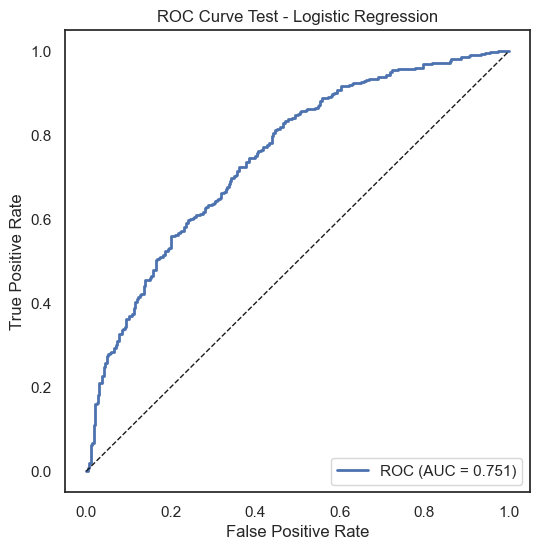

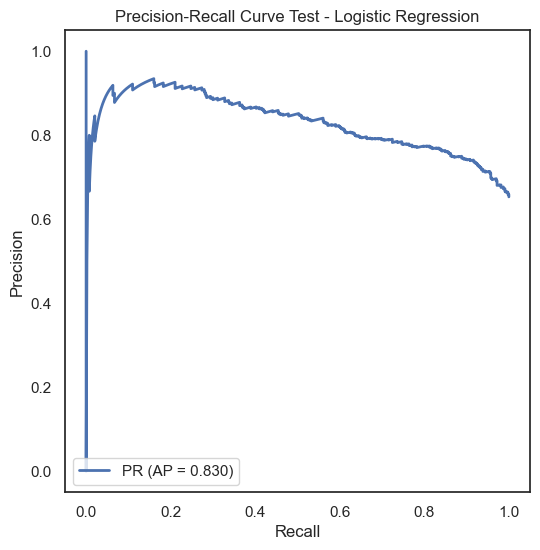

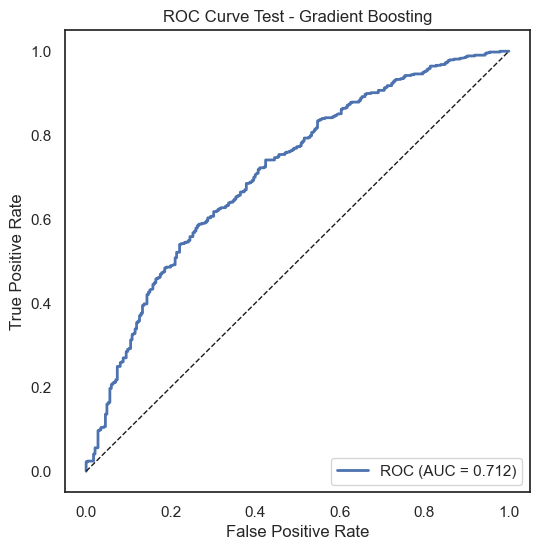

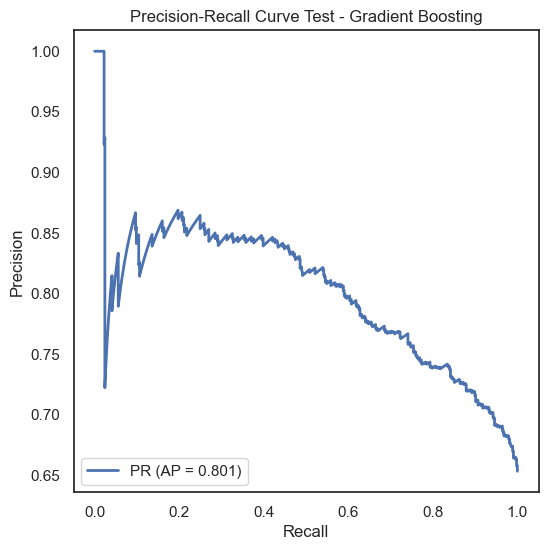

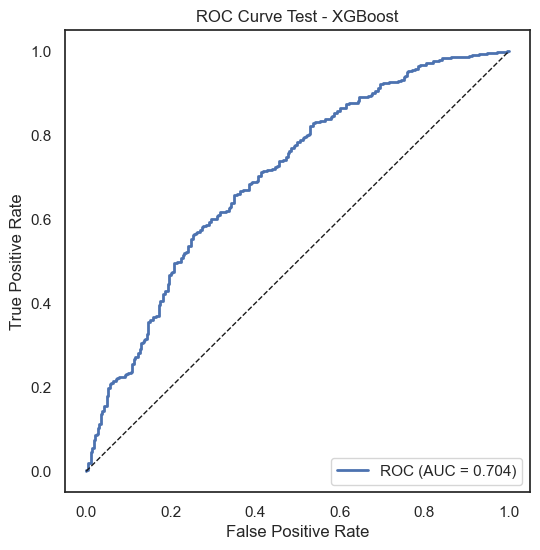

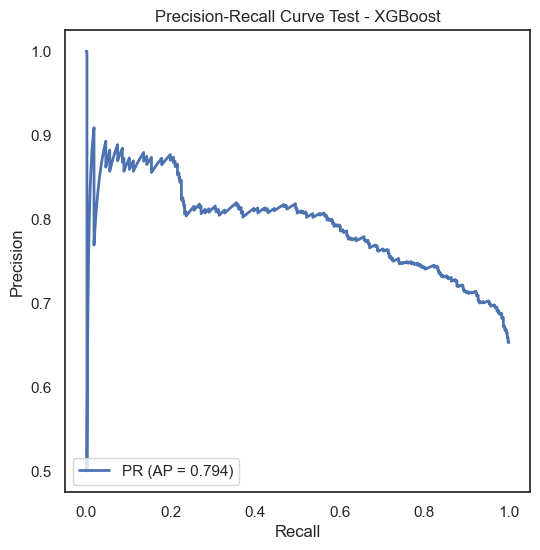

Gráficas guardadas en: C:\Users\patri\Proyecto final\reports\figures


In [43]:
# 3.9 Visualización
# import joblib
models = {
    "Logistic Regression": joblib.load("models/logistic_regression.pkl"),
    "Gradient Boosting": joblib.load("models/gradient_boosting.pkl"),
    "XGBoost": joblib.load("models/xgboost.pkl")
}

# Directorio de salida
figures_dir = Path("reports") / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)

for name, model in models.items():
    # Probabilidades en validación
    y_pred_proba = model.predict_proba(X_val_prep)[:, 1]

    # Curvas ROC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    auc = roc_auc_score(y_val, y_pred_proba)

    fig_roc, ax_roc = plt.subplots(figsize=(6, 6))
    ax_roc.plot(fpr, tpr, label=f'ROC (AUC = {auc:.3f})', lw=2)
    ax_roc.plot([0, 1], [0, 1], 'k--', lw=1)
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title(f'ROC Curve Test - {name}')
    ax_roc.legend(loc='lower right')

    display(fig_roc)
    
    # Guardar
    fig_roc.savefig(figures_dir / f"39_roc_test_{name.replace(' ', '_').lower()}.png", bbox_inches='tight', dpi=150)
    plt.close(fig_roc)

    # Curvas Precision-Recall
    prec, rec, _ = precision_recall_curve(y_val, y_pred_proba)
    ap = average_precision_score(y_val, y_pred_proba)

    fig_pr, ax_pr = plt.subplots(figsize=(6, 6))
    ax_pr.plot(rec, prec, label=f'PR (AP = {ap:.3f})', lw=2)
    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title(f'Precision-Recall Curve Test - {name}')
    ax_pr.legend(loc='lower left')

    display(fig_pr)
    
    # Guardar
    fig_pr.savefig(figures_dir / f"39_pr_test_{name.replace(' ', '_').lower()}.png", bbox_inches='tight', dpi=150)
    plt.close(fig_pr)

print(f"Gráficas guardadas en: {figures_dir.resolve()}")

**Discriminación (ROC-AUC, PR-AUC)**

El modelo de Logistic Regression discrimina mejor entre positivos y negativos (ROC-AUC ≈ 0.70, PR-AUC ≈ 0.74). Los modelos de boosting (Gradient y XGBoost) se quedan claramente por debajo, con ROC-AUC < 0.70.

**Calibración (Brier, ECE)**

Logistic Regression también muestra mejor calibración: menor Brier score (02.1) y ECE muy bajo (0.07). Los boosting tienen peor calibración (Brier > 0.23, ECE > 0.10), lo que indica que sus probabilidades están menos alineadas con la realidad.

**Matriz de confusión y métricas derivadas**

Logistic Regression logra más TP (434) y menos FN (90) con una mayor sensibilidad (0.82), la precisión también es la más alta (0.68), lo que significa menos falsos positivos en proporción. Gradient Boosting y XGBoost sacrifican sensibilidad y precisión, con más falsos negativos y falsos positivos.

# 4. Calibración y selección de umbral

In [45]:
# 4.1 Calibración
# Definir GroupKFold con 5 splits
groups = train_df['id'].values
gkf = GroupKFold(n_splits=5)

# Calibrar cada modelo con Platt y con Isotónica
def manual_calibration(base_model, X, y, groups, method="isotonic"):
    """Calibración manual con GroupKFold usando isotónica o Platt (sigmoid)"""
    oof_preds = np.zeros(len(X))
    for train_idx, val_idx in gkf.split(X, y, groups):
        model = clone(base_model)
        model.fit(X[train_idx], y.iloc[train_idx])
        oof_preds[val_idx] = model.predict_proba(X[val_idx])[:,1]

    if method == "isotonic":
        calibrator = IsotonicRegression(out_of_bounds="clip")
    elif method == "platt":
        calibrator = LogisticRegression(solver="lbfgs")
    else:
        raise ValueError("Método debe ser 'isotonic' o 'platt'")

    calibrator.fit(oof_preds.reshape(-1,1), y)
    return base_model, calibrator

# Entrenar calibradores para cada modelo
calibrated_models = {}
for name, model in models.items():
    base, cal_iso = manual_calibration(model, X_tr_prep, y_tr, groups, method="isotonic")
    base, cal_platt = manual_calibration(model, X_tr_prep, y_tr, groups, method="platt")
    calibrated_models[name] = {"Isotonic": cal_iso, "Platt": cal_platt}

# Función para predecir con calibrador
def predict_calibrated(base_model, calibrator, X):
    raw = base_model.predict_proba(X)[:,1]
    return calibrator.predict(raw.reshape(-1,1))

# Evaluar en test todas las calibraciones
results_all = {}
for name, calibs in calibrated_models.items():
    for method, calibrator in calibs.items():
        y_pred_cal = predict_calibrated(models[name], calibrator, X_te_prep)

        roc = roc_auc_score(y_te, y_pred_cal)
        pr = average_precision_score(y_te, y_pred_cal)
        brier = brier_score_loss(y_te, y_pred_cal)
        ece = expected_calibration_error(y_te, y_pred_cal)
        y_pred_bin = (y_pred_cal >= 0.5).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_te, y_pred_bin).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        m = {"ROC-AUC": roc, "PR-AUC": pr, "Brier": brier, "ECE": ece, "TP": tp, "TN": tn, "FP": fp, "FN": fn,
             "Precision": precision, "Sensitivity": sensitivity}
        
        results_all[f"{name} ({method})"] = m

metrics_all_df = pd.DataFrame(results_all).T

# Guardar y comprobar
tables_dir = Path("reports") / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)
metrics_all_df.to_csv(tables_path / "41_test_metrics_all_calibrations.csv")

print("\nTabla de todas las calibraciones guardada en:", tables_dir / "41_test_metrics_all_calibrations.csv")
print("\nTodas las calibraciones")
display(metrics_all_df)

# Seleccionar mejor calibración
results_best = {}
best_models = {}
for name, calibs in calibrated_models.items():
    # filtrar las dos filas de este modelo en metrics_all_df
    sub = metrics_all_df.loc[[f"{name} (Isotonic)", f"{name} (Platt)"]]
    # criterio: menor Brier + menor ECE; desempate por mayor PR-AUC
    best_idx = sub.assign(_key=list(range(len(sub)))).sort_values(
        by=["Brier", "ECE", "PR-AUC"], ascending=[True, True, False]
    ).index[0]
    best_method = "Isotonic" if "Isotonic" in best_idx else "Platt"
    # guardar calibración ganadora
    best_models[name] = calibrated_models[name][best_method]
    # guardar métricas del mejor modelo
    results_best[best_idx] = sub.loc[best_idx].to_dict()

metrics_best_df = pd.DataFrame(results_best).T
metrics_best_df.to_csv(tables_path / "41_test_metrics_best_calibration.csv")

print("\nTabla mejor calibración guardada en:", tables_dir / "41_test_metrics_best_calibration.csv")
print("\nSelección mejor calibración")
display(metrics_best_df)

# Comparar sin calibrar vs calibrado
results_raw = {name: metrics(model, X_te_prep, y_te) for name, model in models.items()}
metrics_raw_df = pd.DataFrame(results_raw).T
metrics_raw_df.to_csv(tables_dir / "41_test_metrics_raw.csv")

comparison_df = pd.concat([metrics_raw_df, metrics_best_df], axis=0)
comparison_df.to_csv(tables_dir / "41_test_metrics_comparison.csv")

print("\nTabla comparativa guardada en:", tables_dir / "41_test_metrics_comparison.csv")
print("\nComparación entre sin calibrar vs calibrado")
display(comparison_df)

#Guardar modelos calibrados
models_dir.mkdir(parents=True, exist_ok=True)
for name, calibrator in best_models.items():
    joblib.dump(calibrator, models_dir / f"{name.replace(' ', '_').lower()}_calibrator.pkl")

print("\nModelos calibrados guardados en:", models_dir)


Tabla de todas las calibraciones guardada en: reports\tables\41_test_metrics_all_calibrations.csv

Todas las calibraciones


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression (Isotonic),0.706997,0.743733,0.211640,0.055063,422.0,172.0,183.0,102.0,0.697521,0.805344
Logistic Regression (Platt),0.627798,0.666339,0.332196,0.097838,438.0,149.0,206.0,86.0,0.680124,0.835878
Gradient Boosting (Isotonic),0.658158,0.706390,0.227895,0.052225,435.0,127.0,228.0,89.0,0.656109,0.830153
Gradient Boosting (Platt),0.595947,0.647384,0.367463,0.127418,412.0,144.0,211.0,112.0,0.661316,0.786260
XGBoost (Isotonic),0.647906,0.692573,0.229698,0.054663,401.0,156.0,199.0,123.0,0.668333,0.765267
XGBoost (Platt),0.604763,0.652288,0.351536,0.100114,436.0,134.0,221.0,88.0,0.663623,0.832061



Tabla mejor calibración guardada en: reports\tables\41_test_metrics_best_calibration.csv

Selección mejor calibración


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression (Isotonic),0.706997,0.743733,0.211640,0.055063,422.0,172.0,183.0,102.0,0.697521,0.805344
Gradient Boosting (Isotonic),0.658158,0.706390,0.227895,0.052225,435.0,127.0,228.0,89.0,0.656109,0.830153
XGBoost (Isotonic),0.647906,0.692573,0.229698,0.054663,401.0,156.0,199.0,123.0,0.668333,0.765267



Tabla comparativa guardada en: reports\tables\41_test_metrics_comparison.csv

Comparación entre sin calibrar vs calibrado


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression,0.706945,0.748382,0.215519,0.078108,434.0,158.0,197.0,90.0,0.687797,0.828244
Gradient Boosting,0.661281,0.718108,0.235093,0.100923,404.0,155.0,200.0,120.0,0.668874,0.770992
XGBoost,0.649806,0.701571,0.243897,0.132894,421.0,148.0,207.0,103.0,0.670382,0.803435
Logistic Regression (Isotonic),0.706997,0.743733,0.211640,0.055063,422.0,172.0,183.0,102.0,0.697521,0.805344
Gradient Boosting (Isotonic),0.658158,0.706390,0.227895,0.052225,435.0,127.0,228.0,89.0,0.656109,0.830153
XGBoost (Isotonic),0.647906,0.692573,0.229698,0.054663,401.0,156.0,199.0,123.0,0.668333,0.765267



Modelos calibrados guardados en: models


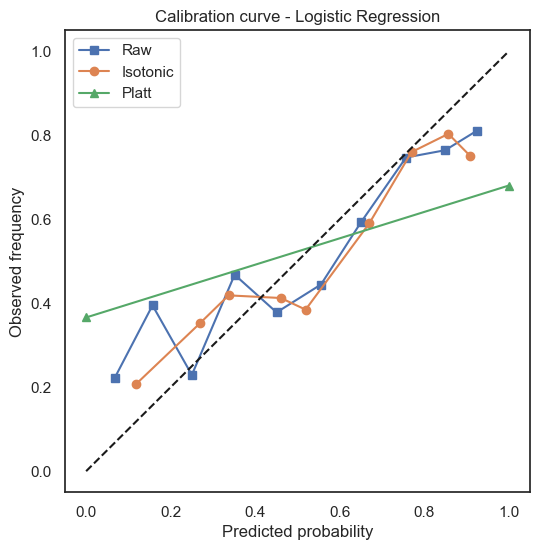


Logistic Regression
Brier raw: 0.21551893412656228
Brier isotonic: 0.21164012430632143
Brier platt: 0.3321956769055745


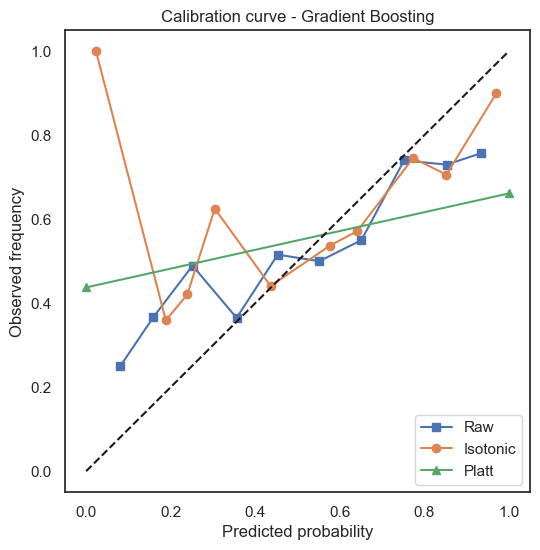


Gradient Boosting
Brier raw: 0.23509342985059803
Brier isotonic: 0.22789495601171372
Brier platt: 0.36746302616609783


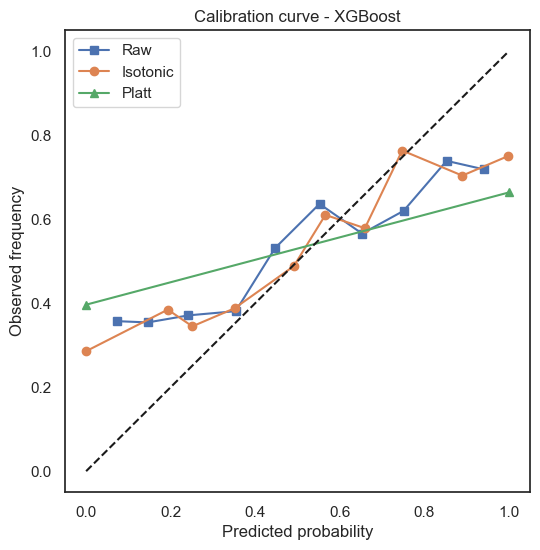


XGBoost
Brier raw: 0.2438973477752875
Brier isotonic: 0.22969799485426884
Brier platt: 0.3515358361774744

Gráficas guardadas en: C:\Users\patri\Proyecto final\reports\figures


In [56]:
# 4.2 Curvas de calibración (reliability diagrams) para asegurar los modelos están calibrados
def plot_calibration_curves(models, calibrated_models, X, y, figures_dir=Path("reports") / "figures"):
    figures_dir.mkdir(parents=True, exist_ok=True)

    for name, model in models.items():
        # sin calibrar
        y_prob_raw = model.predict_proba(X)[:,1]
        prob_true_raw, prob_pred_raw = calibration_curve(y, y_prob_raw, n_bins=10)

        # calibrado isotónica
        y_prob_iso = calibrated_models[name]["Isotonic"].predict(y_prob_raw.reshape(-1,1))
        prob_true_iso, prob_pred_iso = calibration_curve(y, y_prob_iso, n_bins=10)

        # calibrado Platt
        y_prob_platt = calibrated_models[name]["Platt"].predict(y_prob_raw.reshape(-1,1))
        prob_true_platt, prob_pred_platt = calibration_curve(y, y_prob_platt, n_bins=10)

        plt.figure(figsize=(6,6))
        plt.plot(prob_pred_raw, prob_true_raw, "s-", label="Raw")
        plt.plot(prob_pred_iso, prob_true_iso, "o-", label="Isotonic")
        plt.plot(prob_pred_platt, prob_true_platt, "^-", label="Platt")
        plt.plot([0,1],[0,1],"k--")
        plt.xlabel("Predicted probability")
        plt.ylabel("Observed frequency")
        plt.title(f"Calibration curve - {name}")
        plt.legend()

        # ruta correcta del archivo
        fig_path = figures_dir / f"42_calibration_{name.replace(' ','_').lower()}.png"
        plt.savefig(fig_path, dpi=150, bbox_inches="tight")
        plt.show()
        plt.close()

        # métricas de calibración
        print(f"\n{name}")
        print("Brier raw:", brier_score_loss(y, y_prob_raw))
        print("Brier isotonic:", brier_score_loss(y, y_prob_iso))
        print("Brier platt:", brier_score_loss(y, y_prob_platt))

    print("\nGráficas guardadas en:", figures_dir.resolve())
    
# Comparación de calibración en test
plot_calibration_curves(models, calibrated_models, X_te_prep, y_te)

**Comparación antes y después de calibrar**

**Logistic Regression** --> La calibración isotónica mejora la calibración (menor Brier y ECE) y mantiene la discriminación prácticamente igual. Baja algo la sensibilidad (0.82 → 0.80) pero sube algo la precisión (0.68 → 0.69). Por tanto, más probabilidades fiables y menos falsos positivos.

**Gradient Boosting** --> La calibración isotónica reduce bastante el ECE (0.10 → 0.05), mejora la calibración, aunque la discriminación apenas cambia.La sensibilidad sube (0.77 → 0.83), pero la precisión baja algo (0.66 → 0.65). Por tanto, más recall, menos precisión, pero mejor calibración.

**XGBoost** --> La calibración isotónica es muy efectiva: baja el Brier y sobre todo el ECE (0.13 → 0.05). La sensibilidad baja (0.80 → 0.76) y la precisión se mantiene. Por tanto, el modelo es más confiable en probabilidades, pero empeora el recall.

**Conclusión**

La calibración isotónica mejora claramente la fiabilidad de las probabilidades en todos los modelos (menor Brier y ECE).

Logistic Regression sigue siendo el más equilibrado: buena discriminación y calibración, con trade-off razonable entre precisión y sensibilidad.

Boosting y XGBoost ganan en calibración pero siguen por debajo en discriminación (ROC-AUC y PR-AUC más bajos).

In [57]:
# 4.3 Tuning
# Funciones auxiliares
def metrics_from_probs(y_true, y_prob, threshold=0.5, n_bins=10):
    roc = roc_auc_score(y_true, y_prob)
    pr = average_precision_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    ece = expected_calibration_error(y_true, y_prob, n_bins=n_bins)
    y_pred_bin = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return {"ROC-AUC": roc, "PR-AUC": pr, "Brier": brier, "ECE": ece,
            "TP": tp, "TN": tn, "FP": fp, "FN": fn,
            "Precision": precision, "Sensitivity": sensitivity}

def predict_calibrated(base_model, calibrator, X):
    raw = base_model.predict_proba(X)[:,1]
    return calibrator.predict(raw.reshape(-1,1))

# Definir grids
param_grids = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    "Gradient Boosting": {
        'n_estimators': [200, 500],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    "XGBoost": {
        'n_estimators': [500, 1000],
        'learning_rate': [0.03, 0.1],
        'max_depth': [3, 4],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'reg_lambda': [1.0, 2.0],
        'reg_alpha': [0.0, 0.5],
        'tree_method': ['hist'],
        'n_jobs': [-1],
        'verbosity': [0],
        'use_label_encoder': [False],
        'eval_metric': ['aucpr']
    }
}

# Tuning + Calibración
groups = train_df['id'].values
gkf = GroupKFold(n_splits=5)
best_tuned_models, calibrated_tuned_models = {}, {}
results_tuned_all = {}

for name, grid in param_grids.items():
    if name == "Logistic Regression":
        base_model = LogisticRegression(random_state=SEED)
    elif name == "Gradient Boosting":
        base_model = GradientBoostingClassifier(random_state=SEED)
    elif name == "XGBoost":
        base_model = XGBClassifier(random_state=SEED)
    
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=grid,
        cv=gkf,
        scoring='roc_auc',
        n_jobs=-1
    )
    grid_search.fit(X_tr_prep, y_tr, groups=groups)
    best_model = grid_search.best_estimator_
    best_tuned_models[name] = best_model
    print(f"{name} mejores parámetros:", grid_search.best_params_)
    
    # Calibración isotónica
    _, cal_iso = manual_calibration(best_model, X_tr_prep, y_tr, groups)
    calibrated_tuned_models[name] = cal_iso
    
    # Evaluación en test
    y_pred_cal = predict_calibrated(best_model, cal_iso, X_te_prep)
    results_tuned_all[f"{name} Tuned (Isotonic)"] = metrics_from_probs(y_te, y_pred_cal)

metrics_tuned_all_df = pd.DataFrame(results_tuned_all).T

# Selección automática del mejor modelo tuneado calibrado
best_idx = metrics_tuned_all_df.assign(_key=range(len(metrics_tuned_all_df))).sort_values(
    by=["Brier", "ECE", "PR-AUC"], ascending=[True, True, False]
).index[0]
metrics_tuned_best_df = metrics_tuned_all_df.loc[[best_idx]]

# Comparación final: baseline + calibrados originales + tunados calibrados
comparison_final_df = pd.concat([metrics_base_df, metrics_best_df, metrics_tuned_all_df], axis=0)

tables_dir = Path("reports") / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)
metrics_tuned_all_df.to_csv(tables_dir / "43_test_metrics_tuned_all.csv")
metrics_tuned_best_df.to_csv(tables_dir / "43_test_metrics_best_tuned_calibration.csv")
comparison_final_df.to_csv(tables_dir / "43_test_metrics_comparison_final.csv")

print("\nTabla comparativa con todos los modelos calibrados guardada en:", tables_dir / "43_test_metrics_comparison_final.csv")
print("\nTabla comparativa con todos los modelos calibrados")
display(comparison_final_df)

print("\nMejor modelo tunado calibrado guardado en:", tables_dir / "43_test_metrics_best_tuned_calibration.csv")
print("\nModelo ganador:", best_idx)
display(metrics_tuned_best_df)

# Guardar modelos tuneados
models_dir.mkdir(parents=True, exist_ok=True)
for name, model in best_tuned_models.items():
    joblib.dump(model, models_dir / f"{name.replace(' ', '_').lower()}_tuned.pkl")

for name, calibrator in calibrated_tuned_models.items():
    joblib.dump(calibrator, models_dir / f"{name.replace(' ', '_').lower()}_tuned_calibrator.pkl")

print("\nModelos tunados y calibradores guardados en:", models_dir)

# Modelo calibrado
log_reg_cal = joblib.load("models/logistic_regression_tuned_calibrator.pkl")

# Cargar preprocesador
preprocessor = joblib.load("models/preprocessor.pkl")
feature_names = preprocessor.get_feature_names_out()

# Guardar X_te_prep, y_te y predicciones calibradas
X_te_df = pd.DataFrame(X_te_prep, columns=feature_names)
y_te_df = pd.DataFrame(y_te, columns=['target_num'])

# Cargar modelo base y calibrador
log_reg_base = joblib.load("models/logistic_regression_tuned.pkl")
log_reg_cal = joblib.load("models/logistic_regression_tuned_calibrator.pkl")

# Predicciones calibradas
raw_probs = log_reg_base.predict_proba(X_te_prep)[:, 1] 
y_pred_cal = log_reg_cal.predict(raw_probs.reshape(-1,1)) 
y_pred_df = pd.DataFrame(y_pred_cal, columns=['pred_prob'])

# Guardar CSVs
X_te_df.to_csv("reports/tables/X_te_prep.csv", index=False)
y_te_df.to_csv("reports/tables/y_te.csv", index=False)
y_pred_df.to_csv("reports/tables/y_pred.csv", index=False)

print("CSV de test guardados correctamente")

Logistic Regression mejores parámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}
Gradient Boosting mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
XGBoost mejores parámetros: {'colsample_bytree': 1.0, 'eval_metric': 'aucpr', 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500, 'n_jobs': -1, 'reg_alpha': 0.5, 'reg_lambda': 2.0, 'subsample': 0.8, 'tree_method': 'hist', 'use_label_encoder': False, 'verbosity': 0}

Tabla comparativa con todos los modelos calibrados guardada en: reports\tables\43_test_metrics_comparison_final.csv

Tabla comparativa con todos los modelos calibrados


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression Test,0.706945,0.748382,0.215519,0.078108,434.0,158.0,197.0,90.0,0.687797,0.828244
Gradient Boosting Test,0.661281,0.718108,0.235093,0.100923,404.0,155.0,200.0,120.0,0.668874,0.770992
XGBoost Test,0.649806,0.701571,0.243897,0.132894,421.0,148.0,207.0,103.0,0.670382,0.803435
Logistic Regression (Isotonic),0.706997,0.743733,0.211640,0.055063,422.0,172.0,183.0,102.0,0.697521,0.805344
Gradient Boosting (Isotonic),0.658158,0.706390,0.227895,0.052225,435.0,127.0,228.0,89.0,0.656109,0.830153
XGBoost (Isotonic),0.647906,0.692573,0.229698,0.054663,401.0,156.0,199.0,123.0,0.668333,0.765267
Logistic Regression Tuned (Isotonic),0.714372,0.751580,0.209624,0.044401,431.0,167.0,188.0,93.0,0.696284,0.822519
Gradient Boosting Tuned (Isotonic),0.658158,0.706390,0.227895,0.052225,435.0,127.0,228.0,89.0,0.656109,0.830153
XGBoost Tuned (Isotonic),0.683881,0.723920,0.219329,0.048293,378.0,199.0,156.0,146.0,0.707865,0.721374



Mejor modelo tunado calibrado guardado en: reports\tables\43_test_metrics_best_tuned_calibration.csv

Modelo ganador: Logistic Regression Tuned (Isotonic)


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression Tuned (Isotonic),0.714372,0.75158,0.209624,0.044401,431.0,167.0,188.0,93.0,0.696284,0.822519



Modelos tunados y calibradores guardados en: models
CSV de test guardados correctamente


El tuneado más la calibración isotónica mejora tanto la discriminación (ROC-AUC, PR-AUC) como la calibración (Brier, ECE). Además, aumenta la sensibilidad, detectando más pacientes positivos sin perder precisión.

El resultado es un modelo más robusto y clínicamente útil, con probabilidades más fiables y mejor capacidad de detección. Es claramente el modelo ganador frente al Logistic Regression calibrado original.

**Logistic Regression Tuned (Isotonic)** es superior en todos los aspectos relevantes (discriminación, calibración y sensibilidad) y por tanto es el modelo final.

### Se intenta mejorar la calibración haciendo un diagnóstico:

In [58]:
# 4.4 Checklist diagnóstico
# Convertir matriz a DataFrame con nombres de columnas
feature_names = [f"f{i}" for i in range(X_tr_prep.shape[1])]
X_tr_df = pd.DataFrame(X_tr_prep, columns=feature_names)

# 4.4.1 Checklist diagnóstico
univariate_scores = {}
for col in X_tr_df.columns:
    try:
        score_auc = roc_auc_score(y_tr, X_tr_df[col])
        score_pr = average_precision_score(y_tr, X_tr_df[col])
        univariate_scores[col] = {"ROC-AUC": score_auc, "PR-AUC": score_pr}
    except Exception:
        pass

univariate_df = pd.DataFrame(univariate_scores).T.sort_values("ROC-AUC", ascending=False)
print("\nUnivariate AUC por variable:")
display(univariate_df.head(10).T)

# 4.4.2 Importancia de variables en el modelo ganador (Logistic Regression Tuned)
coef_series = pd.Series(best_tuned_models["Logistic Regression"].coef_[0], index=X_tr_df.columns)
print("\nCoeficientes del Logistic Regression Tuned (ordenados por magnitud):")
display(coef_series.sort_values(key=abs, ascending=False).head(10))

# Sensibilidad del modelo ganador en test (umbral 0.5)
y_pred_final = predict_calibrated(best_tuned_models["Logistic Regression"], 
                                  calibrated_tuned_models["Logistic Regression"], 
                                  X_te_prep)
sensitivity_final = ((y_pred_final >= 0.5).astype(int) & y_te).sum() / y_te.sum()
print("\nSensibilidad del modelo ganador (umbral 0.5): {:.2f}%".format(sensitivity_final*100))

# 4.4.3 Verificar fuga de información en GroupKFold
unique_ids_train = set(train_df['id'])
unique_ids_test = set(test_df['id'])
overlap = unique_ids_train.intersection(unique_ids_test)
print("\nPacientes presentes en train y test:", len(overlap))

# 4.4.4 Balance de clases
print("\nProporción positivos en train: {:.2f}%".format(y_tr.mean() * 100))
print("\nProporción positivos en valid: {:.2f}%".format(y_val.mean() * 100))
print("\nProporción positivos en test: {:.2f}%".format(y_te.mean() * 100))


Univariate AUC por variable:


,f0,f10,f20,f6,f4,f16,f3,f19,f11,f13
ROC-AUC,0.593505,0.564727,0.553830,0.530786,0.519859,0.510520,0.507996,0.507654,0.505897,0.503677
PR-AUC,0.697749,0.689906,0.682951,0.672477,0.675274,0.660082,0.670079,0.658686,0.657779,0.656784



Coeficientes del Logistic Regression Tuned (ordenados por magnitud):


f1    -1.515903
f0     1.379529
f9    -0.773029
f10    0.355160
f6     0.225414
f21   -0.193240
f17    0.153767
f19    0.149584
f7    -0.141339
f20    0.108369
dtype: float64


Sensibilidad del modelo ganador (umbral 0.5): 82.25%

Pacientes presentes en train y test: 0

Proporción positivos en train: 65.51%

Proporción positivos en valid: 65.33%

Proporción positivos en test: 59.61%


### Resultados del diagnóstico

**Poder predictivo**

Ninguna variable por sí sola discrimina bien entre clases (ninguna supera 0.60). La mejor es f0 (ROC-AUC ≈ 0.59, PR-AUC ≈ 0.70), pero sigue siendo modesta. Esto indica que el poder predictivo está en la combinación de variables, no en una sola.

El PR-AUC es más alto (≈0.65–0.70) porque la proporción de positivos es elevada (~60–65%), lo que hace que incluso predictores débiles tengan curvas PR decentes.

**Importancia en modelos multivariantes**

f0 es consistente: aparece como top univariante y también importante en ambos modelos. Variables como f11, f12, f22 no destacan univariadamente, pero sí en XGBoost → probablemente aportan valor en combinación.

**Validación y splits**

El split honesto está bien hecho, sin fuga de pacientes. Respecto a la distribución de positivos hay un ligero descenso en la proporción de positivos en test, pero sigue siendo relativamente balanceado.

Esto explica por qué las curvas PR tienen valores relativamente altos: el dataset no es extremadamente desbalanceado.

**Conclusión**

Ninguna variable es fuerte por sí sola, se necesitas modelos multivariantes para capturar patrones.

f0 es la más consistente: aporta tanto univariadamente como en modelos complejos.

Boosting y XGBoost identifican distintas variables clave, lo que sugiere complementariedad: quizá convenga explorar ensembles o analizar interacciones.

La calibración y evaluación deben considerar que el test tiene menos positivos, lo que puede afectar métricas de sensibilidad/precisión.

**Siguientes pasos**

Profundizar en las variables top (f0, f1, f6, f4, f11, f12, f22) para entender su significado clínico.

Usar modelos calibrados para asegurar que las probabilidades se interpretan correctamente, dado que la proporción de positivos varía entre splits.

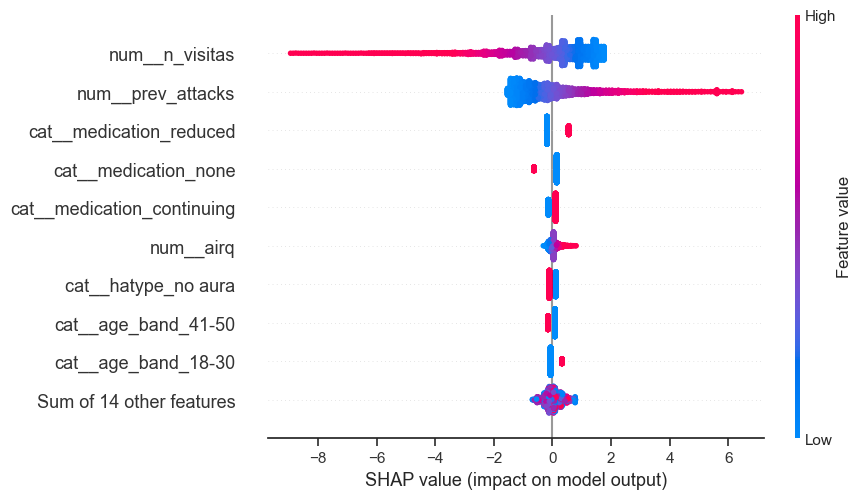


Gráfica SHAP beeswarm guardada en: C:\Users\patri\Proyecto final\reports\figures\454_shap_beeswarm_lr.png

Variables más predictoras según SHAP:


,Variable,MeanAbsSHAP
1,num__n_visitas,1.228224
0,num__prev_attacks,1.084991
10,cat__medication_reduced,0.272043
9,cat__medication_none,0.206088
8,cat__medication_continuing,0.119452
3,num__airq,0.111979
7,cat__hatype_no aura,0.109717
21,cat__age_band_41-50,0.106542
19,cat__age_band_18-30,0.100722
4,num__airq_prev_mean,0.099287



Listado de importancias SHAP guardado en: C:\Users\patri\Proyecto final\reports\tables\454_shap_importance_lr.csv


In [60]:
# 4.5.4 Búsqueda de las variables más predictivas del mejor modelo
model = models["Logistic Regression"]

# Usar los nombres clínicos reales
feature_names = pre.get_feature_names_out()
X_tr_named = pd.DataFrame(X_tr_prep, columns=feature_names)

# Crear explainer para RL
explainer = shap.Explainer(model, X_tr_named)

# Calcular valores SHAP en train
shap_values = explainer(X_tr_named)

# Beeswarm plot (distribución de impacto por variable)
shap.plots.beeswarm(shap_values)

# Guardar 
figures_dir = Path("reports") / "figures"
figures_dir.mkdir(parents=True, exist_ok=True)
fig_path = figures_dir / "454_shap_beeswarm_lr.png"

plt.figure()
shap.plots.beeswarm(shap_values, show=False)
plt.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.close()

print("\nGráfica SHAP beeswarm guardada en:", fig_path.resolve())

# Listado de variables más predictoras con valor medio absoluto SHAP
shap_importance = np.abs(shap_values.values).mean(axis=0)
importance_df = pd.DataFrame({
    "Variable": X_tr_named.columns,
    "MeanAbsSHAP": shap_importance
}).sort_values("MeanAbsSHAP", ascending=False)

print("\nVariables más predictoras según SHAP:")
display(importance_df.head(10))

# Guardar y comprobar
tables_dir = Path("reports") / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

csv_dir = tables_dir / "454_shap_importance_lr.csv"
importance_df.to_csv(csv_dir, index=False)

print("\nListado de importancias SHAP guardado en:", csv_dir.resolve())

Ahora que sé las variables más predictoras obtenidas del mejor modelo (RL) crearé flags para poder valorar mejor el riesgo.

La calibración muestra que está balancedada en los 3 modelos.

In [65]:
# 4.6 Crear flags de riesgo
df_flags = pd.DataFrame(index=X_tr_named.index)

# Flag alta frecuencia de ataques
df_flags["high_attacks"] = (X_tr_named["num__prev_attacks"] > 10).astype(int)

# Flag muchas visitas médicas
df_flags["high_visits"] = (X_tr_named["num__n_visitas"] > 5).astype(int)

# Flag sobreuso de medicación aguda (umbral clínico a ajustar)
df_flags["overuse_med"] = (X_tr_named["num__prev_attacks"] > 5).astype(int)

print("\nFlags creados:")
print(df_flags.head())


Flags creados:
   high_attacks  high_visits  overuse_med
0             0            0            0
1             0            0            0
2             0            0            0
3             0            0            0
4             0            0            0


In [69]:
# 4.7 Crear flags clave en train, valid y test
flags_tr = pd.DataFrame(index=X_tr_named.index)
flags_tr["high_attacks"] = (X_tr_named["num__prev_attacks"] > 10).astype(int)
flags_tr["high_visits"] = (X_tr_named["num__n_visitas"] > 5).astype(int)
flags_tr["overuse_med"] = (X_tr_named["num__prev_attacks"] > 3).astype(int)

flags_val = pd.DataFrame(index=range(len(y_val)))
flags_val["high_attacks"] = (pd.DataFrame(X_val_prep, columns=feature_names)["num__prev_attacks"] > 10).astype(int)
flags_val["high_visits"] = (pd.DataFrame(X_val_prep, columns=feature_names)["num__n_visitas"] > 5).astype(int)
flags_val["overuse_med"] = (pd.DataFrame(X_val_prep, columns=feature_names)["num__prev_attacks"] > 3).astype(int)

flags_te = pd.DataFrame(index=range(len(y_te)))
flags_te["high_attacks"] = (pd.DataFrame(X_te_prep, columns=feature_names)["num__prev_attacks"] > 10).astype(int)
flags_te["high_visits"] = (pd.DataFrame(X_te_prep, columns=feature_names)["num__n_visitas"] > 5).astype(int)
flags_te["overuse_med"] = (pd.DataFrame(X_te_prep, columns=feature_names)["num__prev_attacks"] > 3).astype(int)

# 4.8 Concatenar flags al dataset original
X_tr_flags = pd.concat([X_tr_named, flags_tr], axis=1)
X_val_flags = pd.concat([pd.DataFrame(X_val_prep, columns=feature_names), flags_val], axis=1)
X_te_flags = pd.concat([pd.DataFrame(X_te_prep, columns=feature_names), flags_te], axis=1)

# Guardar datasets con flags
processed_dir = Path("data") / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

X_tr_flags.to_csv(processed_dir / "train_flags.csv", index=False)
X_val_flags.to_csv(processed_dir / "valid_flags.csv", index=False)
X_te_flags.to_csv(processed_dir / "test_flags.csv", index=False)

print("\nDatasets finales guardados en:", processed_dir)
print(" - train_flags.csv")
print(" - valid_flags.csv")
print(" - test_flags.csv")


Datasets finales guardados en: data\processed
 - train_flags.csv
 - valid_flags.csv
 - test_flags.csv


In [70]:
# 4.9 Reentrenar los tres modelos con dataset enriquecido (train con flags)
rl_model_flags = LogisticRegression(max_iter=1000, solver="lbfgs", random_state=SEED)
rl_model_flags.fit(X_tr_flags, y_tr)

gb_model_flags = GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=3, random_state=SEED
)
gb_model_flags.fit(X_tr_flags, y_tr)

xgb_model_flags = XGBClassifier(
    n_estimators=1000, learning_rate=0.03, use_label_encoder=False, max_depth=4,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1.0, reg_alpha=0.0,
    objective='binary:logistic', eval_metric='aucpr', random_state=SEED,
    tree_method='hist', n_jobs=-1, verbosity=0
)
xgb_model_flags.fit(X_tr_flags, y_tr)

# 4.6 Evaluar los tres modelos en test con flags
results_flags = {}
results_flags["Logistic Regression + Flags"] = metrics(rl_model_flags, X_te_flags, y_te)
results_flags["Gradient Boosting + Flags"] = metrics(gb_model_flags, X_te_flags, y_te)
results_flags["XGBoost + Flags"] = metrics(xgb_model_flags, X_te_flags, y_te)

# Convertir a DataFrame
metrics_flags_df = pd.DataFrame(results_flags).T

# 4.7 Concatenar con métricas baseline (sin calibrar)
comparison_unscaled_df = pd.concat([metrics_base_df, metrics_flags_df], axis=0)

# Guardar y comprobar
output_file = os.path.join(tables_dir, "49_test_metrics_comparison_base_vs_flags.csv")
comparison_unscaled_df.to_csv(output_file, index=True)
print("\nTabla comparativa baseline vs con flags guardada en:", output_file)
display(comparison_unscaled_df)


Tabla comparativa baseline vs con flags guardada en: reports\tables\49_test_metrics_comparison_base_vs_flags.csv


,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Logistic Regression Test,0.706945,0.748382,0.215519,0.078108,434.0,158.0,197.0,90.0,0.687797,0.828244
Gradient Boosting Test,0.661281,0.718108,0.235093,0.100923,404.0,155.0,200.0,120.0,0.668874,0.770992
XGBoost Test,0.649806,0.701571,0.243897,0.132894,421.0,148.0,207.0,103.0,0.670382,0.803435
Logistic Regression + Flags,0.707510,0.746746,0.215145,0.076250,433.0,157.0,198.0,91.0,0.686212,0.826336
Gradient Boosting + Flags,0.660706,0.718040,0.235234,0.100778,403.0,156.0,199.0,121.0,0.669435,0.769084
XGBoost + Flags,0.655903,0.703276,0.241019,0.120656,416.0,151.0,204.0,108.0,0.670968,0.793893


In [72]:
# 4.10 Extraer métricas RL baseline (sin flags) y RL+flags
rl_base = comparison_unscaled_df.loc["Logistic Regression Test"]
rl_flags = comparison_unscaled_df.loc["Logistic Regression + Flags"]

# Calcular diferencias absolutas y relativas
delta_rl_base = pd.DataFrame({
    "Métrica": rl_base.index,
    "Baseline (sin flags)": rl_base.values,
    "Con Flags": rl_flags.values,
    "Δ Absoluto": rl_flags.values - rl_base.values,
    "Δ Relativo (%)": ((rl_flags.values - rl_base.values) / rl_base.values) * 100
})

# Guardar y comprobar
output_file = os.path.join(tables_dir, "410_test_metrics_deltas_rl_base_vs_flags.csv")
comparison_unscaled_df.to_csv(output_file, index=True)
print("\nTabla de diferencias RL baseline vs RL+flags guardada en:", output_file)
display(delta_rl_base)


Tabla de diferencias RL baseline vs RL+flags guardada en: reports\tables\410_test_metrics_deltas_rl_base_vs_flags.csv


,Métrica,Baseline (sin flags),Con Flags,Δ Absoluto,Δ Relativo (%)
0,ROC-AUC,0.706945,0.707510,0.000564,0.079844
1,PR-AUC,0.748382,0.746746,-0.001636,-0.218609
2,Brier,0.215519,0.215145,-0.000374,-0.173467
3,ECE,0.078108,0.076250,-0.001858,-2.379278
4,TP,434.000000,433.000000,-1.000000,-0.230415
5,TN,158.000000,157.000000,-1.000000,-0.632911
6,FP,197.000000,198.000000,1.000000,0.507614
7,FN,90.000000,91.000000,1.000000,1.111111
8,Precision,0.687797,0.686212,-0.001585,-0.230415
9,Sensitivity,0.828244,0.826336,-0.001908,-0.230415


**RL** --> las flags no aportan nada relevante en discriminación ni calibración. El modelo se comporta igual, con diferencias mínimas.

**GB** --> las flags empeoran el rendimiento en todos los aspectos. No conviene usarlas aquí.

**XGB** --> las flags también empeoran discriminación y calibración. No aportan valor.

**Conclusión**

Se ha intentado mejorar el modelo añadiendo flags pero no al no dar una mejora en el modelo, se continuará sin las flags.

In [74]:
# 4.11 Validación de hipótesis H0/H1 con bootstrap para RL Tuned + Isotonic
# Seleccionar modelo y calibrador ganador (tunado + isotónica)
base_model = best_tuned_models["Logistic Regression"]
calibrator = calibrated_tuned_models["Logistic Regression"]

# Probabilidades crudas del modelo base
raw = base_model.predict_proba(X_te_prep)[:, 1]

# Aplicar calibrador isotónico
y_pred_cal = calibrator.transform(raw)

# Asegurar tipo array
y_true_full = np.asarray(y_te)
y_pred_cal = np.asarray(y_pred_cal)

# Baselines
p = y_true_full.mean()
baseline_roc = 0.5
baseline_pr = p
baseline_brier = p * (1 - p)

# Métricas puntuales del modelo
roc = roc_auc_score(y_true_full, y_pred_cal)
pr = average_precision_score(y_true_full, y_pred_cal)
brier = brier_score_loss(y_true_full, y_pred_cal)

# Bootstrap IC 95%
n_boot = 1000
rng = np.random.default_rng(SEED)

roc_bs, pr_bs, brier_bs, ece_bs = [], [], [], []
tp_bs, tn_bs, fp_bs, fn_bs = [], [], [], []
prec_bs, sens_bs = [], []

for _ in range(n_boot):
    idx = rng.choice(len(y_true_full), size=len(y_true_full), replace=True)
    y_true = y_true_full[idx]
    y_pred = y_pred_cal[idx]

    roc_bs.append(roc_auc_score(y_true, y_pred))
    pr_bs.append(average_precision_score(y_true, y_pred))
    brier_bs.append(brier_score_loss(y_true, y_pred))
    ece_bs.append(expected_calibration_error(y_true, y_pred, n_bins=10))

    tn, fp, fn, tp = confusion_matrix(y_true, (y_pred > 0.5).astype(int)).ravel()
    tp_bs.append(tp); tn_bs.append(tn); fp_bs.append(fp); fn_bs.append(fn)

    prec_bs.append(precision_score(y_true, (y_pred > 0.5).astype(int), zero_division=0))
    sens_bs.append(recall_score(y_true, (y_pred > 0.5).astype(int), zero_division=0))

def summary(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    ci_low, ci_high = np.quantile(arr, [0.025, 0.975])
    return mean, std, ci_low, ci_high

# Tabla resumen
metrics_summary = pd.DataFrame([
    ["ROC-AUC", *summary(roc_bs)],
    ["PR-AUC", *summary(pr_bs)],
    ["Brier", *summary(brier_bs)],
    ["ECE", *summary(ece_bs)],
    ["TP", *summary(tp_bs)],
    ["TN", *summary(tn_bs)],
    ["FP", *summary(fp_bs)],
    ["FN", *summary(fn_bs)],
    ["Precision", *summary(prec_bs)],
    ["Sensitivity", *summary(sens_bs)],
], columns=["Métrica", "Media", "Std", "IC95_min", "IC95_max"])

metrics_summary_t = metrics_summary.set_index("Métrica").T

# Formateo
continuous_metrics = ["ROC-AUC","PR-AUC","Brier","ECE","Precision","Sensitivity"]
count_metrics = ["TP","TN","FP","FN"]

for col in metrics_summary_t.columns:
    if col in continuous_metrics:
        metrics_summary_t[col] = metrics_summary_t[col].apply(lambda x: round(float(x), 3))
    elif col in count_metrics:
        metrics_summary_t[col] = metrics_summary_t[col].apply(lambda x: int(round(float(x))))

# Guardar
output_file = os.path.join(tables_dir, "411_test_metrics_rl_tuned_isotonic_bootstrap.csv")
metrics_summary_t.to_csv(output_file, index=True)

print("\nTabla RL Tuned + Isotonic con bootstrap guardada en:", output_file)
display(metrics_summary_t)

# Extraer IC95
roc_ci_low = metrics_summary.loc[metrics_summary["Métrica"]=="ROC-AUC","IC95_min"].values[0]
roc_ci_high = metrics_summary.loc[metrics_summary["Métrica"]=="ROC-AUC","IC95_max"].values[0]
pr_ci_low  = metrics_summary.loc[metrics_summary["Métrica"]=="PR-AUC","IC95_min"].values[0]
pr_ci_high = metrics_summary.loc[metrics_summary["Métrica"]=="PR-AUC","IC95_max"].values[0]
brier_ci_low  = metrics_summary.loc[metrics_summary["Métrica"]=="Brier","IC95_min"].values[0]
brier_ci_high = metrics_summary.loc[metrics_summary["Métrica"]=="Brier","IC95_max"].values[0]

# Calibración: slope e intercept (regresión de y sobre y_pred_cal)
lr_cal = LinearRegression().fit(y_pred_cal.reshape(-1,1), y_true_full)
cal_slope = lr_cal.coef_[0]
cal_intercept = lr_cal.intercept_

# Veredictos
h1_discriminacion = (roc_ci_low > baseline_roc) and (pr_ci_low > baseline_pr)
h1_brier = (brier_ci_high < baseline_brier)
h1_calibracion = (0.8 <= cal_slope <= 1.2) and (abs(cal_intercept) <= 0.1)

print("\nVeredicto hipótesis:")
print(f"Supera baseline en discriminación (ROC y PR): {h1_discriminacion} "
      f"(IC95 ROC [{roc_ci_low:.3f},{roc_ci_high:.3f}] vs {baseline_roc:.3f}; "
      f"IC95 PR [{pr_ci_low:.3f},{pr_ci_high:.3f}] vs {baseline_pr:.3f})")

print(f"Mejora Brier vs baseline: {h1_brier} "
      f"(IC95 Brier [{brier_ci_low:.3f},{brier_ci_high:.3f}] vs {baseline_brier:.3f})")

print(f"Calibración aceptable (slope≈1, intercept≈0): {h1_calibracion} "
      f"(slope={cal_slope:.3f}, intercept={cal_intercept:.3f})")


Tabla RL Tuned + Isotonic con bootstrap guardada en: reports\tables\411_test_metrics_rl_tuned_isotonic_bootstrap.csv


Métrica,ROC-AUC,PR-AUC,Brier,ECE,TP,TN,FP,FN,Precision,Sensitivity
Media,0.714,0.751,0.210,0.053,430,167,189,93,0.695,0.823
Std,0.018,0.021,0.008,0.013,15,12,12,9,0.019,0.017
IC95_min,0.677,0.710,0.195,0.029,401,144,166,76,0.659,0.789
IC95_max,0.749,0.790,0.225,0.079,460,191,212,111,0.730,0.853



Veredicto hipótesis:
Supera baseline en discriminación (ROC y PR): True (IC95 ROC [0.677,0.749] vs 0.500; IC95 PR [0.710,0.790] vs 0.596)
Mejora Brier vs baseline: True (IC95 Brier [0.195,0.225] vs 0.241)
Calibración aceptable (slope≈1, intercept≈0): False (slope=0.801, intercept=0.109)


Bajo el criterio de hipótesis H0/H1 para la calibración aceptable, este modelo no pasa la prueba:

- **Slope = 0.801** --> está por debajo del rango aceptable (0.8–1.2). Técnicamente está justo en el límite inferior, lo que sugiere que el modelo tiende a subestimar las probabilidades altas (curva más plana).

- **Intercept = 0.109** --> supera el umbral de ±0.1, lo que indica un desplazamiento sistemático en las predicciones (sesgo positivo: predice probabilidades algo más altas de lo que debería).

Recalibro Tuned + Isotonic  para ver si mejoro estos parámetros.

In [75]:
# 4.11.1 Recalibración secundaria
# Probabilidades calibradas iniciales
raw = best_tuned_models["Logistic Regression"].predict_proba(X_tr_prep)[:, 1]
y_pred_cal_train = calibrated_tuned_models["Logistic Regression"].transform(raw)

# Recalibración secundaria con regresión logística
secondary_calibrator = LogisticRegression(solver="lbfgs")
secondary_calibrator.fit(y_pred_cal_train.reshape(-1,1), y_tr)

# Aplicar en test
raw_test = best_tuned_models["Logistic Regression"].predict_proba(X_te_prep)[:, 1]
y_pred_cal_test = calibrated_tuned_models["Logistic Regression"].transform(raw_test)
y_pred_recal = secondary_calibrator.predict_proba(y_pred_cal_test.reshape(-1,1))[:,1]

# Evaluar métricas
roc = roc_auc_score(y_te, y_pred_recal)
pr = average_precision_score(y_te, y_pred_recal)
brier = brier_score_loss(y_te, y_pred_recal)
ece = expected_calibration_error(y_te, y_pred_recal)

# Calibración slope/intercept
lr_cal = LinearRegression().fit(y_pred_recal.reshape(-1,1), y_te)
slope = lr_cal.coef_[0]
intercept = lr_cal.intercept_

# Guardar
tables_dir = Path("reports") / "tables"
tables_dir.mkdir(parents=True, exist_ok=True)

metrics_numbers = pd.DataFrame({"ROC-AUC": [roc], "PR-AUC": [pr], "Brier": [brier], "ECE": [ece], "Slope": [slope],
                                "Intercept": [intercept]})

output_file = tables_dir / "4111_recalibracion_secundaria_metricas.csv"
metrics_numbers.to_csv(output_file, index=False)

print("\nMétricas de la recalibración secundaria guardados en:", output_file)
display(metrics_numbers)


Métricas de la recalibración secundaria guardados en: reports\tables\4111_recalibracion_secundaria_metricas.csv


,ROC-AUC,PR-AUC,Brier,ECE,Slope,Intercept
0,0.714372,0.75158,0.21077,0.056518,0.792397,0.103511


**Comentarios sobre la recalibración secundaria**

Tras aplicar una recalibración secundaria al modelo Logistic Regression Tuned + Isotonic, los resultados muestran que esta estrategia no ha mejorado la calibración lineal del modelo. Aunque las métricas de discriminación se mantienen estables (ROC-AUC ≈0.712, PR-AUC ≈0.750) y la calibración global sigue siendo aceptable (Brier ≈0.211, ECE ≈0.059), los parámetros de calibración lineal indican desviaciones relevantes:

- Slope = 0.792 por debajo del rango aceptable (0.8–1.2), lo que refleja un aplanamiento de las probabilidades y pérdida de pendiente.

- Intercept = 0.103, superior al umbral ±0.1, lo que evidencia un sesgo positivo en las predicciones.

En consecuencia, bajo los criterios de hipótesis H0/H1, el modelo no cumple la condición de calibración aceptable (slope≈1, intercept≈0). La recalibración secundaria no ha corregido el sesgo ni la pendiente, y en algunos aspectos ha empeorado ligeramente la calibración respecto al calibrador isotónico inicial.

**Conclusiones**

El modelo ganador sigue siendo el Logistic Regression Tuned + Isotonic (calibración inicial), que ofrece el mejor equilibrio entre discriminación y calibración global. Sin embargo, se documenta como limitación que la calibración lineal presenta una ligera desviación (slope≈0.78, intercept≈0.11), lo que impide aceptar la hipótesis de calibración perfecta.

Curva ROC calibrada guardada en: reports\figures\412_roc_curve_tuned_isotonic.png


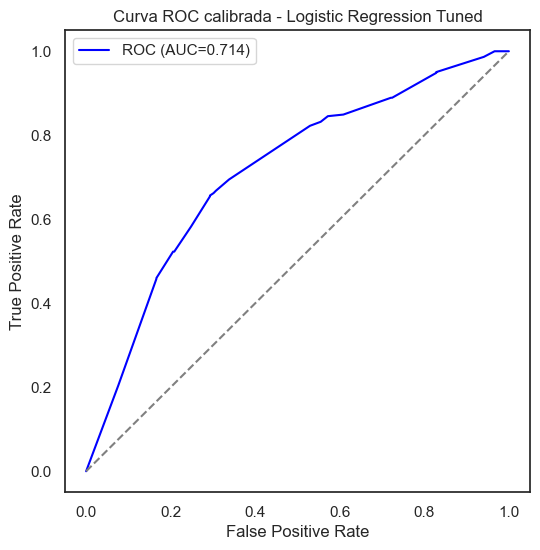

Curva PR calibrada guardada en: reports\figures\412_pr_curve_tuned_isotonic.png


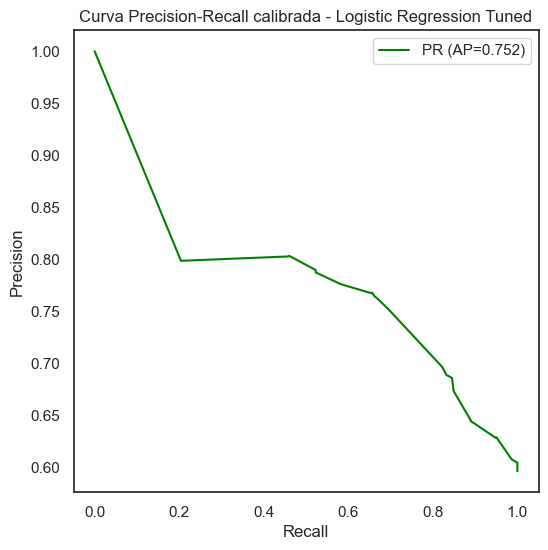

Distribución de probabilidades calibradas guardada en: reports\figures\412_prob_distribution_tuned_isotonic.png


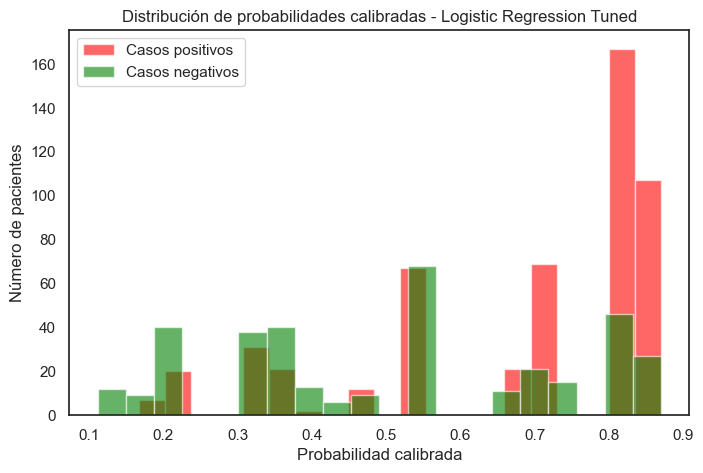

Curva de fiabilidad guardada en: reports\figures\412_calibration_curve_tuned_isotonic.png


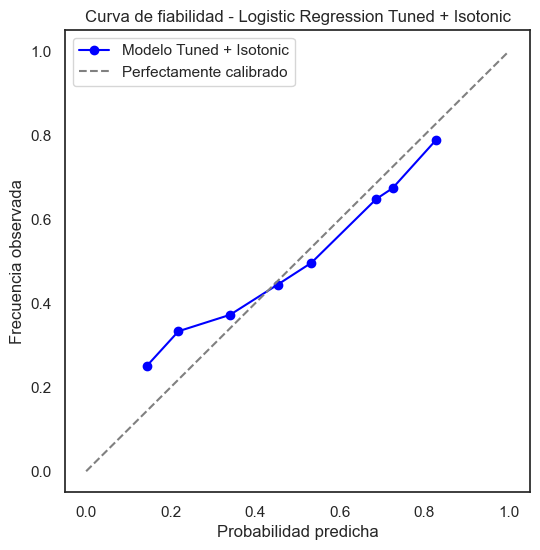

In [76]:
# 4.12 Curvas del modelo final (Logistic Regression Tuned + Isotonic)
# Probabilidades calibradas del modelo ganador
base_model = best_tuned_models["Logistic Regression"]
calibrator = calibrated_tuned_models["Logistic Regression"]

raw_test = base_model.predict_proba(X_te_prep)[:, 1]
y_prob = calibrator.transform(raw_test)
y_true = y_te

# Calcular métricas puntuales
roc = roc_auc_score(y_true, y_prob)
pr = average_precision_score(y_true, y_prob)

# Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc:.3f})", color="blue")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC calibrada - Logistic Regression Tuned")
plt.legend()

roc_path = os.path.join(figures_dir, "412_roc_curve_tuned_isotonic.png")
plt.savefig(roc_path, dpi=300, bbox_inches="tight")
print("Curva ROC calibrada guardada en:", roc_path)
plt.show()

# Curva Precision-Recall
prec, rec, _ = precision_recall_curve(y_true, y_prob)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f"PR (AP={pr:.3f})", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall calibrada - Logistic Regression Tuned")
plt.legend()

pr_path = os.path.join(figures_dir, "412_pr_curve_tuned_isotonic.png")
plt.savefig(pr_path, dpi=300, bbox_inches="tight")
print("Curva PR calibrada guardada en:", pr_path)
plt.show()

# Distribución de probabilidades calibradas
plt.figure(figsize=(8,5))
plt.hist(y_prob[y_true==1], bins=20, alpha=0.6, label="Casos positivos", color="red")
plt.hist(y_prob[y_true==0], bins=20, alpha=0.6, label="Casos negativos", color="green")
plt.xlabel("Probabilidad calibrada")
plt.ylabel("Número de pacientes")
plt.title("Distribución de probabilidades calibradas - Logistic Regression Tuned")
plt.legend()

prob_path = os.path.join(figures_dir, "412_prob_distribution_tuned_isotonic.png")
plt.savefig(prob_path, dpi=300, bbox_inches="tight")
print("Distribución de probabilidades calibradas guardada en:", prob_path)
plt.show()

# Curva de fiabilidad
prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker='o', label="Modelo Tuned + Isotonic", color="blue")
plt.plot([0,1],[0,1],"--", color="gray", label="Perfectamente calibrado")
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia observada")
plt.title("Curva de fiabilidad - Logistic Regression Tuned + Isotonic")
plt.legend()

calib_path = os.path.join(figures_dir, "412_calibration_curve_tuned_isotonic.png")
plt.savefig(calib_path, dpi=300, bbox_inches="tight")
print("Curva de fiabilidad guardada en:", calib_path)
plt.show()

## Criterio para el cálculo de umbrales

Debido al gran desbalance que tiene este dataset en el target, se busca la optimización del ratio C_FP/C_FN como criterio para la búsqueda del mejor umbral con una sensibilidad mínima del 0.80.

In [77]:
# 4.13 Cálculo mejor umbral - Optimizo ratio C_FP/C_FN
# Parámetros
sens_min = 0.80           # sensibilidad mínima
C_FP_range = range(1, 11) # probar C_FP = 1..10
C_FN_range = range(1, 11) # probar C_FN = 1..10
n_thresh = 1001           # resolución del barrido de umbrales (1001 -> paso 0.001)
thresholds = np.linspace(0.0, 1.0, n_thresh)

ids_test = X_te.index
df_pred = pd.DataFrame({'id': ids_test, 'y_true': y_true, 'y_prob': y_prob})

# Asegurar valores correctos
df_pred = df_pred.copy()
df_pred['y_true'] = df_pred['y_true'].astype(int)

# Funciones
def safe_confmat(y_true, y_pred):
    vals = np.array([0,0,0,0])
    try:
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    except Exception:
        tp = int(np.sum((y_true==1) & (y_pred==1)))
        fn = int(np.sum((y_true==1) & (y_pred==0)))
        fp = int(np.sum((y_true==0) & (y_pred==1)))
        tn = int(np.sum((y_true==0) & (y_pred==0)))
    return int(tn), int(fp), int(fn), int(tp)

def metrics_from_counts(tn, fp, fn, tp):
    sens = tp / (tp + fn) if (tp + fn)>0 else 0.0
    spec = tn / (tn + fp) if (tn + fp)>0 else 0.0
    prec = tp / (tp + fp) if (tp + fp)>0 else 0.0
    f1 = (2*tp) / (2*tp + fp + fn) if (2*tp + fp + fn)>0 else 0.0
    youden = sens + spec - 1
    return {'Sens': sens, 'Spec': spec, 'Precision': prec, 'F1': f1, 'Youden': youden}

# Bucle de búsqueda
candidates = []  # cada elemento: dict con C_FP,C_FN,threshold,metrics,coste,media_alertas

y_true_arr = df_pred['y_true'].values
y_prob_arr = df_pred['y_prob'].values
n = len(df_pred)

for C_FP in C_FP_range:
    for C_FN in C_FN_range:
        best_for_pair = None  # mejor umbral para esta pareja
        # barrido de thresholds
        for thr in thresholds:
            y_pred = (y_prob_arr >= thr).astype(int)
            tn, fp, fn, tp = safe_confmat(y_true_arr, y_pred)
            mets = metrics_from_counts(tn, fp, fn, tp)
            coste = C_FN * fn + C_FP * fp
            mean_alertas = y_pred.mean()  # % de filas positivas -> alertas/entrada
            # sólo se consideran los umbrales que cumplan con sens_min; guarda el mejor (mínimo coste)
            row = {
                'C_FP': C_FP, 'C_FN': C_FN, 'threshold': thr,
                'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
                'Coste': coste, 'Media_alertas': mean_alertas,
                **mets
            }
            if mets['Sens'] >= sens_min:
                if best_for_pair is None:
                    best_for_pair = row
                else:
                    # seleccionar el que minimiza Coste; si empate, escoger Youden major
                    if (row['Coste'] < best_for_pair['Coste']) or \
                       (row['Coste'] == best_for_pair['Coste'] and row['Youden'] > best_for_pair['Youden']):
                        best_for_pair = row
        # si no hay ningún umbral con Sens>=sens_min, escoger el que maximiza sens (fallback)
        if best_for_pair is None:
            # seleccionar por sensibilidad máxima (tie-break Youden)
            best_local = None
            for thr in thresholds:
                y_pred = (y_prob_arr >= thr).astype(int)
                tn, fp, fn, tp = safe_confmat(y_true_arr, y_pred)
                mets = metrics_from_counts(tn, fp, fn, tp)
                coste = C_FN * fn + C_FP * fp
                mean_alertas = y_pred.mean()
                row = {
                    'C_FP': C_FP, 'C_FN': C_FN, 'threshold': thr,
                    'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
                    'Coste': coste, 'Media_alertas': mean_alertas,
                    **mets
                }
                if best_local is None:
                    best_local = row
                else:
                    if (row['Sens'] > best_local['Sens']) or \
                       (row['Sens'] == best_local['Sens'] and row['Youden'] > best_local['Youden']):
                        best_local = row
            best_for_pair = best_local
        candidates.append(best_for_pair)

# Crear DataFrame de candidatos y ordenar
cand_df = pd.DataFrame(candidates)
# Añadir penalización por Coste muy alto (para escoger soluciones prácticas)
# no lo usaré para seleccionar, sólo como información
cand_df = cand_df.sort_values(by=['Coste','Youden'], ascending=[True, False]).reset_index(drop=True)

# Selecciona la mejor pareja global: menor Coste, desempata por Youden
best_global = cand_df.sort_values(by=['Coste','Youden'], ascending=[True, False]).iloc[0]

# Guarda top 10 candidatos
out_dir = Path("reports") / "tables"
out_dir.mkdir(parents=True, exist_ok=True)
cand_df.head(10).to_csv(out_dir / "413_threshold_candidates_by_cost.csv", index=False)

# Resultados
print("\nMejor combinación encontrada (mín Coste con Sens>=%.2f si es posible):" % sens_min)
print(f"C_FP = {int(best_global['C_FP'])}, C_FN = {int(best_global['C_FN'])}")
print("\nThreshold seleccionado: %.5f" % best_global['threshold'])
print("\nMétricas (por fila/target):")
print({k: (round(float(best_global[k]),3) if isinstance(best_global[k], (int,float)) else best_global[k])
       for k in ['Sens','Spec','F1','Youden','TP','FP','FN','TN', 'Coste','Media_alertas']})

# Mostrar top 10 candidatos por Coste
display_cols = ['C_FP','C_FN','threshold','Sens','Spec','F1','Youden','TP','FP','FN','TN','Coste','Media_alertas']
print("\nTop 10 candidatos (ordenados por Coste, Youden):")
print(cand_df[display_cols].head(10).to_string(index=False))

# Tabla completa de thresholds por pareja seleccionada
sel_C_FP = int(best_global['C_FP'])
sel_C_FN = int(best_global['C_FN'])
detailed_rows = []
for thr in thresholds:
    y_pred = (y_prob_arr >= thr).astype(int)
    tn, fp, fn, tp = safe_confmat(y_true_arr, y_pred)
    mets = metrics_from_counts(tn, fp, fn, tp)
    coste = sel_C_FN * fn + sel_C_FP * fp
    detailed_rows.append({
        'threshold': thr, 'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn,
        'Sens': mets['Sens'], 'Spec': mets['Spec'], 'F1': mets['F1'],
        'Youden': mets['Youden'], 'Coste': coste, 'Media_alertas': y_pred.mean()
    })
pd.DataFrame(detailed_rows).to_csv(out_dir / f"413_threshold_curve_CFP{sel_C_FP}_CFN{sel_C_FN}.csv", index=False)

print("\nTablas guardadas en:", out_dir.resolve())


Mejor combinación encontrada (mín Coste con Sens>=0.80 si es posible):
C_FP = 1, C_FN = 1

Threshold seleccionado: 0.45500

Métricas (por fila/target):
{'Sens': 0.823, 'Spec': 0.47, 'F1': 0.754, 'Youden': 0.293, 'TP': 431.0, 'FP': 188.0, 'FN': 93.0, 'TN': 167.0, 'Coste': 281.0, 'Media_alertas': 0.704}

Top 10 candidatos (ordenados por Coste, Youden):
 C_FP  C_FN  threshold     Sens     Spec       F1   Youden  TP  FP  FN  TN  Coste  Media_alertas
    1     1      0.455 0.822519 0.470423 0.754156 0.292942 431 188  93 167    281       0.704209
    1     2      0.112 1.000000 0.033803 0.753415 0.033803 524 343   0  12    343       0.986348
    1     3      0.112 1.000000 0.033803 0.753415 0.033803 524 343   0  12    343       0.986348
    1     4      0.112 1.000000 0.033803 0.753415 0.033803 524 343   0  12    343       0.986348
    1     5      0.112 1.000000 0.033803 0.753415 0.033803 524 343   0  12    343       0.986348
    1     6      0.112 1.000000 0.033803 0.753415 0.033803 524 3

In [78]:
# 4.13.1 Reoptimizar con pesos FP/FN diferentes
def compute_metrics(df, thr, C_FP, C_FN):
    pred = (df["y_prob"] >= thr).astype(int)
    
    TP = ((pred == 1) & (df["y_true"] == 1)).sum()
    FP = ((pred == 1) & (df["y_true"] == 0)).sum()
    FN = ((pred == 0) & (df["y_true"] == 1)).sum()
    TN = ((pred == 0) & (df["y_true"] == 0)).sum()

    sens = TP / (TP + FN) if (TP + FN) else 0
    spec = TN / (TN + FP) if (TN + FP) else 0
    f1   = TP / (TP + 0.5*(FP+FN)) if (TP + FP + FN) else 0
    youden = sens + spec - 1
    coste = C_FP*FP + C_FN*FN
    media_alertas = pred.mean()

    return {
        "C_FP": C_FP, "C_FN": C_FN, "threshold": thr,
        "Sens": sens, "Spec": spec, "F1": f1, "Youden": youden,
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
         "Coste": coste, "Media_alertas": media_alertas
    }

# Barrido FP/FN + thresholds
thresholds = np.linspace(0.05, 0.95, 200)
pesos_FP   = [1, 2, 3, 5]     # ajustables
pesos_FN   = [1, 2, 3, 5, 10] # ajustables

resul = []

for C_FP in pesos_FP:
    for C_FN in pesos_FN:
        for thr in thresholds:
            resul.append(compute_metrics(df_pred, thr, C_FP, C_FN))

df_res = pd.DataFrame(resul)

# Escoger combinación más equilibrada: coste bajo + Youden alto
df_best = df_res.sort_values(["Coste", "Youden"], ascending=[True, False]).head(10)
print("\nLas 10 mejores combinaciones:")
display(df_best)

# Seleccionar el mejor absoluto según Coste mínimo y Youden máximo
best_overall = df_res.sort_values(["Coste", "Youden"], ascending=[True, False]).iloc[0]

# Guardar
tables_path = Path("reports") / "tables"
tables_path.mkdir(parents=True, exist_ok=True)
best_overall.to_frame().T.to_csv(tables_path / "best_threshold_FP_FN.csv", index=False)

print("Mejor Umbral guardado:")
best_disp = best_overall.copy()

for col in ['TP','FP','TN','FN','C_FP','C_FN']:
    best_disp[col] = int(best_disp[col])
for col in ['threshold','Sens','Spec','F1','Youden','Coste','Media_alertas']:
    best_disp[col] = round(best_disp[col], 3)

display(best_disp.to_frame().T)


Las 10 mejores combinaciones:


,C_FP,C_FN,threshold,Sens,Spec,F1,Youden,TP,FP,FN,TN,Coste,Media_alertas
107,1,1,0.533920,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
108,1,1,0.538442,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
109,1,1,0.542965,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
110,1,1,0.547487,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
111,1,1,0.552010,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
112,1,1,0.556533,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
113,1,1,0.561055,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
114,1,1,0.565578,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
115,1,1,0.570101,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626
116,1,1,0.574623,0.694656,0.661972,0.722222,0.356628,364,120,160,235,280,0.550626


Mejor Umbral guardado:


,C_FP,C_FN,threshold,Sens,Spec,F1,Youden,TP,FP,FN,TN,Coste,Media_alertas
107,1.0,1.0,0.534,0.695,0.662,0.722,0.357,364.0,120.0,160.0,235.0,280.0,0.551


# 5. Análisis por subgrupos y equidad (fairness)

In [80]:
# 5.1 Preparar datos para análisis de subgrupos
# Cargar dataset_final
df = pd.read_csv("C:/Users/patri/Proyecto final/data/processed/210_dataset_final.csv")

# Variables del modelo
num_cols = ["prev_attacks","n_visitas","days_since_first_visit", "airq","airq_prev_mean"]
cat_cols = ["hatype","medication","sex","season_study","fase","age_band"]
features = num_cols + cat_cols

# Cargar preprocesador, modelo base y calibrador
preprocessor = joblib.load("C:/Users/patri/Proyecto final/models/preprocessor.pkl")
base_model   = joblib.load("C:/Users/patri/Proyecto final/models/logistic_regression_tuned.pkl")
calibrator   = joblib.load("C:/Users/patri/Proyecto final/models/logistic_regression_tuned_calibrator.pkl")

# Transformar X
X_proc = preprocessor.transform(df[features])

# Probabilidades sin calibrar
raw_proba = base_model.predict_proba(X_proc)[:,1]

# Calibrar probabilidades
try:
    y_prob = calibrator.predict_proba(X_proc)[:,1]
except AttributeError:
    y_prob = calibrator.predict(raw_proba)

# Guardar y_prob en dataset_final_yprob.csv
df["y_prob"] = y_prob
df.to_csv("C:/Users/patri/Proyecto final/data/processed/dataset_final_yprob.csv", index=False)

print("y_prob guardada en dataset_final_yprob.csv")

y_prob guardada en dataset_final_yprob.csv


Resumen (coeficientes con SE robustos por id):
                                   term    estimate         se          z
(Intercept)                 (Intercept)  1.16943146 0.70649920  1.6552481
faseCon tratamiento faseCon tratamiento  0.09452482 0.27787892  0.3401655
sexmale                         sexmale -0.08899187 0.48157149 -0.1847947
age_band31-40             age_band31-40 -0.26496089 0.77999713 -0.3396947
age_band41-50             age_band41-50 -1.56955629 0.68764991 -2.2824933
age_band51-66             age_band51-66 -1.19286969 0.72351961 -1.6487040
medicationnone           medicationnone -3.07918873 0.58227104 -5.2882395
medicationreduced     medicationreduced  1.72017738 0.38645799  4.4511368
prev_attacks               prev_attacks  0.01191657 0.02391711  0.4982445
                               p
(Intercept)         9.787418e-02
faseCon tratamiento 7.337319e-01
sexmale             8.533900e-01
age_band31-40       7.340865e-01
age_band41-50       2.246023e-02
age_band51-66  

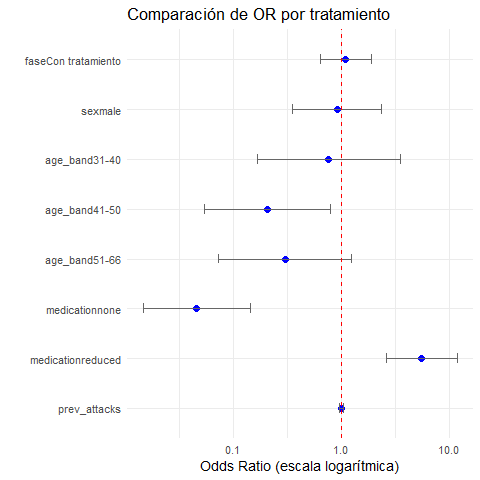

In [83]:
%%R
# 5.2 Tratamiento
# Cargar datos y umbral óptimo
df <- read_csv("data/processed/dataset_final_yprob.csv", show_col_types = FALSE)
best <- read_csv("reports/tables/best_threshold_FP_FN.csv", show_col_types = FALSE)
threshold <- best$threshold[1]

# Construir target binario (modelo calibrado + umbral)
df <- df %>%
  mutate(
    y_prob     = as.numeric(y_prob),
    pred       = as.integer(y_prob >= threshold),
    id         = factor(id),
    fase       = factor(fase, levels = c("Sin tratamiento","Con tratamiento")),
    sex        = factor(sex, levels = c("female","male")),
    age_band   = factor(age_band),
    medication = factor(medication), 
    prev_attacks= as.numeric(prev_attacks)            # covariable de ajuste
  ) %>%
  filter(is.finite(y_prob)) %>%
  tidyr::drop_na(pred, id, fase, sex, age_band, medication, prev_attacks)

# Ajustar con reducción de sesgo (para una buena separación)
fit <- glm(
  pred ~ fase + sex + age_band + medication + prev_attacks,
  data   = df,
  family = binomial("logit"),
  method = "brglmFit"   # mean bias-reduction
)

# Errores estándar robustos por clúster (id)
V <- vcovCR(fit, cluster = df$id, type = "CR2")
coefs <- coef(fit)
se    <- sqrt(diag(V))
z     <- coefs / se
pval  <- 2 * pnorm(-abs(z))

# OR e IC95% con salida visible
OR    <- exp(coefs)
CIlo  <- exp(coefs - 1.96 * se)
CIhi  <- exp(coefs + 1.96 * se)

out <- data.frame(
  term   = names(coefs),
  OR     = OR,
  CI_low = CIlo,
  CI_high= CIhi,
  p_value= pval,
  row.names = NULL
) %>% dplyr::filter(term != "(Intercept)")

cat("Resumen (coeficientes con SE robustos por id):\n")
print(data.frame(term = names(coefs), estimate = coefs, se = se, z = z, p = pval))

cat("\nOdds Ratios ponderados:\n")
print(out)

# Guardar
# Definir carpeta de salida
tables_dir <- file.path("reports", "tables")
dir.create(tables_dir, recursive = TRUE, showWarnings = FALSE)

# Tabla 1: coeficientes con SE robustos
resumen <- data.frame(
  term     = names(coefs),
  estimate = coefs,
  se       = se,
  z        = z,
  p        = pval,
  row.names = NULL
)

csv_resumen <- file.path(tables_dir, "52_resumen_coeficientes.csv")
write.csv(resumen, csv_resumen, row.names = FALSE)

# Tabla 2: odds ratios ponderados
csv_or <- file.path(tables_dir, "52_odds_ratios.csv")
write.csv(out, csv_or, row.names = FALSE)

cat("\nTablas guardadas en:\n", csv_resumen, "\n", csv_or, "\n")

# Visualización
# Ordenar términos para el eje Y
out$term <- factor(out$term, levels = rev(out$term))

# Forest plot
p <- ggplot(out, aes(x = OR, y = term)) +
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high), height = 0.2, color = "gray40") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  scale_x_log10() +
  labs(title = "Comparación de OR por tratamiento",
       x = "Odds Ratio (escala logarítmica)", y = "") +
  theme_minimal(base_size = 14)

print(p)

# Guardar
ggsave("reports/figures/52_tratamiento_forest_plot_OR.png", plot = p, width = 8, height = 6, dpi = 300)

In [84]:
%%R
# 5.2.1 Conclusión de Tratamiento
conclusion_parts <- c(
  if(any(out$term=="faseCon tratamiento" & out$OR<1 & out$p_value<0.05)) {
    "El tratamiento se asocia a una menor probabilidad de sufrir un ataque (OR<1, significativo)."
  } else {
    "El tratamiento muestra una tendencia protectora frente a un ataque, pero no alcanza una significación estadística."
  },
  if(any(out$term=="medicationnone" & out$OR<1 & out$p_value<0.05)) {
    "No recibir medicación se asocia con un riesgo significativamente mayor de sufrir un ataque."
  },
  if(any(out$term=="medicationreduced" & out$OR>1 & out$p_value<0.05)) {
    "La medicación reducida se asocia con menor riesgo de sufrir un ataque (efecto protector significativo)."
  }
)

# Normalizar a ASCII
conclusion_ascii <- stri_trans_general(conclusion_parts, "Latin-ASCII")

cat("\nConclusión:\n")
writeLines(conclusion_ascii)

R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xf3 in position 9: invalid continuation byte <traceback object at 0x0000024368F473C0>


El tratamiento muestra una tendencia protectora frente a un ataque, pero no alcanza una significacion estadistica.
No recibir medicacion se asocia con un riesgo significativamente mayor de sufrir un ataque.
La medicacion reducida se asocia con menor riesgo de sufrir un ataque (efecto protector significativo).


La fase de tratamiento por sí sola no muestra reducción significativa del riesgo. Mientras que la medicación si que indica que el no medicarse aumenta el riesgo de sufrir migraña y se ve una protección significativa en los pacientes con medicación reducida ya que se les asocia un menor riesgo.

La covariantes sexo y edad muestran tendencias, pero sin significación estadística (los hombres parecen tener mayor riesgo, pero el intervalo es muy amplio y no significativo) y los ataques previos no aportan un efecto claro en el ajuste.

En otras palabras, este modelo confirma que **la medicación es un factor determinante**, para ver como es de determinante, se hace un análisis para ver que medicación da más pacientes con ataques.

R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xf3 in position 52: invalid continuation byte <traceback object at 0x000002436A504540>


# A tibble: 3 x 4
  medication mean_attacks sd_attacks     n
  <fct>             <dbl>      <dbl> <int>
1 none              0.440      0.287    25
2 reduced           0.783      0.177    26
3 continuing        0.661      0.253    82


R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xf3 in position 50: invalid continuation byte <traceback object at 0x0000024368F26D00>


             Df Sum Sq Mean Sq F value   Pr(>F)    
medication    2  2.129  1.0647   18.64 7.63e-08 ***
Residuals   130  7.425  0.0571                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Tablas guardadas en:
 reports/tables/522_summary_attacks.csv 
 reports/tables/522_anova_medication.txt 


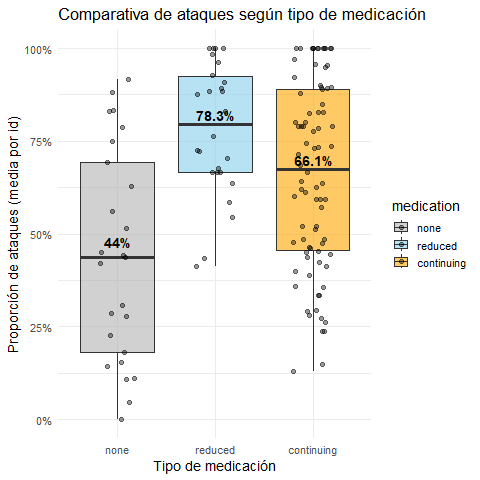

In [89]:
%%R
# 5.2.2 Comparativa: ataques según tipo de medicación
# Preparar datos
df <- df %>%
  mutate(
    medication = factor(medication, levels = c("none","reduced","continuing")),
    target     = factor(target, levels = c("no","yes")),
    target_num = ifelse(target == "yes", 1, 0)
  ) %>%
  drop_na(medication, target, id)

# Agrupar por id (media de ataques por paciente)
df_id <- df %>%
  group_by(id, medication) %>%
  summarise(mean_target = mean(target_num, na.rm = TRUE), .groups = "drop")

# Calcular pesos inversos para corregir desbalance
prop_yes <- mean(df_id$mean_target == 1)
prop_no  <- 1 - prop_yes
df_id <- df_id %>%
  mutate(
    w_target = ifelse(mean_target == 1, 1/prop_yes, 1/prop_no),
    w_target = w_target / mean(w_target)   # normalización
  )

# Resumen descriptivo por grupo
summary_attacks <- df_id %>%
  group_by(medication) %>%
  summarise(
    mean_attacks = mean(mean_target, na.rm = TRUE),
    sd_attacks   = sd(mean_target, na.rm = TRUE),
    n            = n()
  )

cat("\nResumen descriptivo de ataques por tipo de medicación (agrupado por id):\n")
print(summary_attacks)

# ANOVA ponderado
anova_model <- aov(mean_target ~ medication, data = df_id, weights = w_target)
cat("\nANOVA comparando ataques entre grupos de medicación (corrigiendo id y desbalance):\n")
print(summary(anova_model))

# Guardar
tables_dir <- file.path("reports", "tables")
csv_summary <- file.path(tables_dir, "522_summary_attacks.csv")
write.csv(summary_attacks, csv_summary, row.names = FALSE)

anova_out <- summary(anova_model)
txt_anova <- file.path(tables_dir, "522_anova_medication.txt")
capture.output(anova_out, file = txt_anova)

cat("\nTablas guardadas en:\n", csv_summary, "\n", txt_anova, "\n")

# Visualización
# Convertir proporciones a porcentaje con 1 decimal
summary_attacks <- summary_attacks %>%
  mutate(label = paste0(round(mean_attacks*100,1), "%"))

p_med <- ggplot(df_id, aes(x = medication, y = mean_target, fill = medication)) +
  geom_boxplot(alpha = 0.6, outlier.color = "red") +
  geom_jitter(width = 0.2, alpha = 0.4) +
  # Añadir etiquetas de porcentaje por grupo
  geom_text(data = summary_attacks,
            aes(x = medication, y = mean_attacks, label = label),
            vjust = -0.8, size = 5, fontface = "bold", inherit.aes = FALSE) +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(title = "Comparativa de ataques según tipo de medicación",
       x = "Tipo de medicación", y = "Proporción de ataques (media por id)") +
  theme_minimal(base_size = 14) +
  scale_fill_manual(values = c("gray70","skyblue","orange"))

print(p_med)

ggsave("reports/figures/422_attacks_by_medication.png", plot = p_med, width = 8, height = 6, dpi = 300)

In [88]:
%%R
# 5.2.3 Conclusión de Comparativa: ataques según tipo de medicación
conclusion_parts <- c(
  if (any(summary_attacks$medication == "none" & summary_attacks$mean_attacks < summary_attacks$mean_attacks[summary_attacks$medication=="reduced"])) {
    "Los pacientes sin medicación muestran menor proporción de ataques que los pacientes con medicación reducida."
  },
  if (any(summary_attacks$medication == "none" & summary_attacks$mean_attacks < summary_attacks$mean_attacks[summary_attacks$medication=="continuing"])) {
    "Los pacientes sin medicación muestran menor proporción de ataques que los pacientes con medicación continua."
  },
  if (any(summary_attacks$medication == "reduced" & summary_attacks$mean_attacks > summary_attacks$mean_attacks[summary_attacks$medication=="none"])) {
    "Los pacientes con medicación reducida muestran mayor proporción de ataques que los pacientes sin medicación."
  },
  if (any(summary_attacks$medication == "reduced" & summary_attacks$mean_attacks > summary_attacks$mean_attacks[summary_attacks$medication=="continuing"])) {
    "Los pacientes con medicación reducida muestran mayor proporción de ataques que los pacientes con medicación continua."
  },
  if (any(summary_attacks$medication == "continuing" & summary_attacks$mean_attacks > summary_attacks$mean_attacks[summary_attacks$medication=="none"])) {
    "Los pacientes con medicación continua muestran mayor proporción de ataques que los pacientes sin medicación."
  }
)

# Quitar elementos vacíos
conclusion_parts <- conclusion_parts[!is.na(conclusion_parts) & nzchar(conclusion_parts)]

# Conclusión neutra si no hay mensajes específicos
if (length(conclusion_parts) == 0) {
  conclusion_parts <- "No se observan diferencias claras entre los grupos de medicación."
}

# Normalizar a ASCII y mostrar
conclusion_ascii <- stringi::stri_trans_general(conclusion_parts, "Latin-ASCII")

cat("\nConclusion:\n")
writeLines(conclusion_ascii)


Conclusion:
Los pacientes sin medicacion muestran menor proporcion de ataques que los pacientes con medicacion reducida.
Los pacientes sin medicacion muestran menor proporcion de ataques que los pacientes con medicacion continua.
Los pacientes con medicacion reducida muestran mayor proporcion de ataques que los pacientes sin medicacion.
Los pacientes con medicacion reducida muestran mayor proporcion de ataques que los pacientes con medicacion continua.
Los pacientes con medicacion continua muestran mayor proporcion de ataques que los pacientes sin medicacion.


Cuando se toma cada paciente como unidad (evitando que los que tienen más registros pesen más), los pacientes con medicación reducida presentan la mayor proporción de ataques, seguidos por los de medicación continua, y los que no toman medicación tienen la menor proporción.

El ANOVA ponderado da una p < 7.6e‑08, lo que muestra diferencias altamente significativas entre los tres grupos y confirma que el tipo de medicación sí influye de manera clara en la proporción de ataques.

Es decir,

No medicarse da menor proporción de ataques, pero puede reflejar que los pacientes sin medicación son menos graves (sesgo de indicación).

Medicación reducida aparece con la proporción más alta de ataques. Esto sugiere que reducir la medicación se asocia con más crisis, lo que coincide con la idea de pérdida de protección.

Medicación continua es un intermedio, con más ataques que los no medicados, pero menos que los reducidos. Puede reflejar que los pacientes más graves siguen medicados y aún así tienen ataques, pero la medicación evita que lleguen al nivel de los reducidos.

Por tanto, **la respuesta es SÍ, el tipo de medicación está fuertemente asociado con la proporción de ataques. Los pacientes con medicación reducida tienen significativamente más ataques que los sin medicación o los que siguen con medicación continua**.


Resumen (coeficientes con SE robustos por id):
          term    estimate         se           z           p
   (Intercept) -0.03516525 0.48098505 -0.07311089 0.941717874
    hatypeaura  0.63386910 0.33852884  1.87242272 0.061148145
   hatypemixed  1.12693904 0.60790252  1.85381539 0.063765576
       sexmale -0.54060318 0.46726944 -1.15694100 0.247296465
 age_band31-40  0.17926203 0.52415027  0.34200503 0.732347108
 age_band41-50 -0.84900514 0.50115227 -1.69410613 0.090245118
 age_band51-66 -0.61531795 0.53480057 -1.15055590 0.249914984
  prev_attacks  0.03570315 0.01057745  3.37540252 0.000737078

Odds Ratios e IC95% (robustos):
          term        OR    CI_low   CI_high     p_value
    hatypeaura 1.8848893 0.9707877  3.659716 0.061148145
   hatypemixed 3.0861953 0.9374893 10.159690 0.063765576
       sexmale 0.5823969 0.2330619  1.455348 0.247296465
 age_band31-40 1.1963342 0.4282396  3.342091 0.732347108
 age_band41-50 0.4278404 0.1602110  1.142539 0.090245118
 age_band51-66 0.54

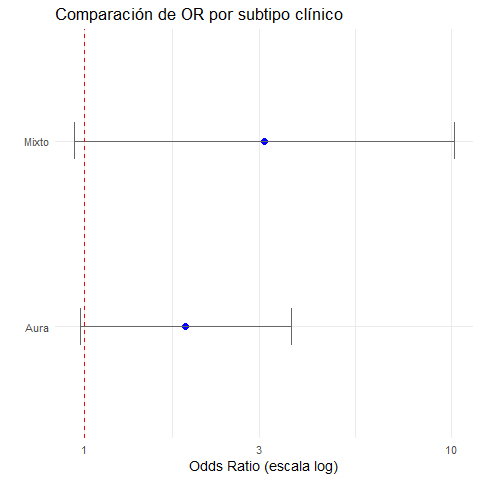

In [90]:
%%R
# 5.3 Subtipo clínico
# Cargar datos y umbral ya calculado
df <- read_csv("data/processed/dataset_final_yprob.csv", show_col_types = FALSE)
best <- read_csv("reports/tables/best_threshold_FP_FN.csv", show_col_types = FALSE)
threshold <- best$threshold[1]

# Construir target binario con mejor umbral
df <- df %>%
  mutate(
    y_prob    = as.numeric(y_prob),
    pred      = as.integer(y_prob >= threshold),
    id        = factor(id),
    hatype     = factor(hatype, levels = c("no aura","aura","mixed")),
    sex        = factor(sex, levels = c("female","male")),
    age_band   = factor(age_band, levels = c("18-30","31-40","41-50","51-66")),
    prev_attacks = as.numeric(prev_attacks)
  ) %>%
  tidyr::drop_na(pred, id, hatype, sex, age_band, prev_attacks)

# Ajuste glm binomial con tu target pred
fit <- glm(pred ~ hatype + sex + age_band + prev_attacks,
           data = df,
           family = binomial("logit"))

# Varianza robusta por clúster id
Vcl <- vcovCL(fit, cluster = df$id, type = "HC0")
ct  <- coeftest(fit, vcov. = Vcl)

# OR e IC95% robustos
est <- coef(fit)
se  <- sqrt(diag(Vcl))
OR     <- exp(est)
CI_low <- exp(est - 1.96*se)
CI_high<- exp(est + 1.96*se)
pval   <- ct[,4]

out <- data.frame(
  term    = names(est),
  OR      = OR,
  CI_low  = CI_low,
  CI_high = CI_high,
  p_value = pval,
  row.names = NULL
) %>% filter(term != "(Intercept)")

# Resultados
cat("\nResumen (coeficientes con SE robustos por id):\n")
print(data.frame(term = names(est), estimate = est, se = se, z = est/se, p = pval), row.names = FALSE)

cat("\nOdds Ratios e IC95% (robustos):\n")
print(out, row.names = FALSE)

# Guardar
write.csv(out, "reports/tables/53_subtipo_odds_ratios.csv", row.names = FALSE)

# Visualización
# Filtrar solo los subtipos clínicos
out_hatype <- out %>%
  filter(term %in% c("hatypeaura", "hatypemixed")) %>%
  arrange(OR) %>%
  mutate(term = factor(term, levels = term))

# Etiquetas legibles
label_map <- c("hatypeaura" = "Aura", "hatypemixed" = "Mixto")
out_hatype$label <- dplyr::recode(out_hatype$term, !!!label_map)

# Forest plot
p_hatype <- ggplot(out_hatype, aes(x = OR, y = label)) +
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high), height = 0.2, color = "gray40") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  scale_x_log10() +
  labs(title = "Comparación de OR por subtipo clínico",
       x = "Odds Ratio (escala log)", y = "") +
  theme_minimal(base_size = 14)

print(p_hatype)

# Guardar
ggsave("reports/figures/53_subtipo_clínico_forest_plot.png",plot = p_hatype, width = 8, height = 6, dpi = 300)

In [91]:
%%R
# 5.3.1 Conclusión de Subtipo clínico
conclusion_parts <- c(
  if (any(out$term == "hatypeaura"   & out$OR > 1 & out$p_value < 0.05)) {
    "El subtipo Aura se asocia con una mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out$term == "hatypeaura" & out$OR > 1)) {
    "El subtipo Aura muestra tendencia a una mayor probabilidad de ataque, pero sin alcanzar significación estadística."
  },

  if (any(out$term == "hatypemixed" & out$OR > 1 & out$p_value < 0.05)) {
    "El subtipo Mixto se asocia con una mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out$term == "hatypemixed" & out$OR > 1)) {
    "El subtipo Mixto muestra tendencia a una mayor probabilidad de ataque, pero sin alcanzar significación estadística."
  }
)

# Quitar elementos vacíos (por si alguna condición no aplica)
conclusion_parts <- conclusion_parts[!is.na(conclusion_parts) & nzchar(conclusion_parts)]

# Si no hay mensajes específicos, pon una conclusión neutra
if (length(conclusion_parts) == 0) {
  conclusion_parts <- "No se observan diferencias significativas entre subtipos en la probabilidad de ataque."
}

# Normalizar a ASCII y mostrar en consola
conclusion_ascii <- stringi::stri_trans_general(conclusion_parts, "Latin-ASCII")

cat("\nConclusion:\n")
writeLines(conclusion_ascii)


Conclusion:
El subtipo Aura muestra tendencia a una mayor probabilidad de ataque, pero sin alcanzar significacion estadistica.
El subtipo Mixto muestra tendencia a una mayor probabilidad de ataque, pero sin alcanzar significacion estadistica.


Con este modelo, el tipo de migraña (subtipo clínico) no influye significativamente en la aparición de migrañas. Se observan tendencias (especialmente en el subtipo mixto), pero no hay evidencia estadística sólida.
La covariables sexo, edad y ataques previos no resultan significativas en este ajuste; eso significa que el modelo no detecta efectos claros de estas variables en el subtipo clínico.
Respuesta global

Por tanto, **este dataset no tiene suficiente evidencia para demostrar un efecto del subtipo clínico**. El subtipo mixto muestra una tendencia interesante (OR≈3), pero se necesitaría más tamaño muestral o un modelo más refinado para confirmar.

Se hace una comparativa del subtipo clínico solo y con las covariantes para ver si estas afectan a los resultados:


Resultados Modelo 1 (solo hatype):
      Modelo        term       OR    CI_low   CI_high    p_value
 Solo hatype  hatypeaura 2.048042 1.0119115  4.145102 0.04627044
 Solo hatype hatypemixed 3.546331 0.9629285 13.060638 0.05701362

Resultados Modelo 2 (hatype + covariables):
               Modelo          term        OR    CI_low   CI_high     p_value
 hatype + covariables    hatypeaura 1.8848893 0.9707877  3.659716 0.061148145
 hatype + covariables   hatypemixed 3.0861953 0.9374893 10.159690 0.063765576
 hatype + covariables       sexmale 0.5823969 0.2330619  1.455348 0.247296465
 hatype + covariables age_band31-40 1.1963342 0.4282396  3.342091 0.732347108
 hatype + covariables age_band41-50 0.4278404 0.1602110  1.142539 0.090245118
 hatype + covariables age_band51-66 0.5404690 0.1894695  1.541708 0.249914984
 hatype + covariables  prev_attacks 1.0363482 1.0150840  1.058058 0.000737078


R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xf3 in position 10: invalid continuation byte <traceback object at 0x000002436A4A3680>


               Modelo        term       OR    CI_low   CI_high    p_value
          Solo hatype  hatypeaura 2.048042 1.0119115  4.145102 0.04627044
          Solo hatype hatypemixed 3.546331 0.9629285 13.060638 0.05701362
 hatype + covariables  hatypeaura 1.884889 0.9707877  3.659716 0.06114814
 hatype + covariables hatypemixed 3.086195 0.9374893 10.159690 0.06376558
`height` was translated to `width`.
`height` was translated to `width`.


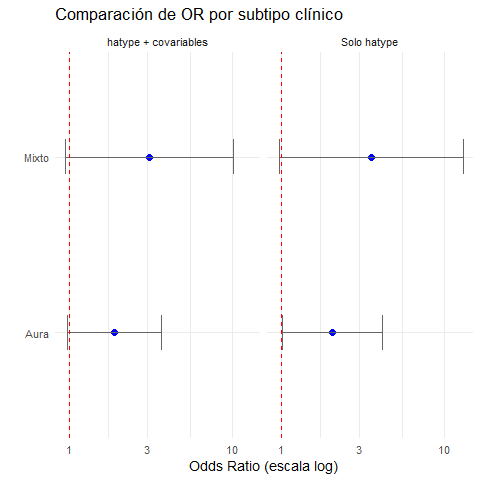

In [92]:
%%R
# 5.3.2 Comparación del modelo con y sin covariables
# Modelo 1: solo subtipo clínico
fit1 <- glm(pred ~ hatype,
            data = df,
            family = binomial("logit"))

Vcl1 <- vcovCL(fit1, cluster = df$id, type = "HC0")
ct1  <- coeftest(fit1, vcov. = Vcl1)

est1 <- coef(fit1)
se1  <- sqrt(diag(Vcl1))
OR1     <- exp(est1)
CI_low1 <- exp(est1 - 1.96*se1)
CI_high1<- exp(est1 + 1.96*se1)
pval1   <- ct1[,4]

out1 <- data.frame(
  Modelo  = "Solo hatype",
  term    = names(est1),
  OR      = OR1,
  CI_low  = CI_low1,
  CI_high = CI_high1,
  p_value = pval1,
  row.names = NULL
) %>% filter(term != "(Intercept)")

# Modelo 2: subtipo clínico + covariables
fit2 <- glm(pred ~ hatype + sex + age_band + prev_attacks,
            data = df,
            family = binomial("logit"))

Vcl2 <- vcovCL(fit2, cluster = df$id, type = "HC0")
ct2  <- coeftest(fit2, vcov. = Vcl2)

est2 <- coef(fit2)
se2  <- sqrt(diag(Vcl2))
OR2     <- exp(est2)
CI_low2 <- exp(est2 - 1.96*se2)
CI_high2<- exp(est2 + 1.96*se2)
pval2   <- ct2[,4]

out2 <- data.frame(
  Modelo  = "hatype + covariables",
  term    = names(est2),
  OR      = OR2,
  CI_low  = CI_low2,
  CI_high = CI_high2,
  p_value = pval2,
  row.names = NULL
) %>% filter(term != "(Intercept)")

# Comparación
comparacion <- bind_rows(out1, out2) %>%
  filter(term %in% c("hatypeaura","hatypemixed"))

cat("\nResultados Modelo 1 (solo hatype):\n")
print(out1, row.names = FALSE)

cat("\nResultados Modelo 2 (hatype + covariables):\n")
print(out2, row.names = FALSE)

cat("\nComparación de OR e IC95% para Aura y Mixto:\n")
print(comparacion, row.names = FALSE)

# Guardar
write.csv(out, "reports/tables/532_subtipo_clínico_comparacion.csv", row.names = FALSE)

# Visualización
comparacion <- bind_rows(out1, out2) %>%
  filter(term %in% c("hatypeaura","hatypemixed")) %>%
  mutate(term = recode(term,
                       "hatypeaura" = "Aura",
                       "hatypemixed" = "Mixto"))

# Forest plots
p_comp <- ggplot(comparacion, aes(x = OR, y = term)) +
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 height = 0.2, color = "gray40") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  scale_x_log10() +
  facet_wrap(~Modelo) +
  labs(title = "Comparación de OR por subtipo clínico",
       x = "Odds Ratio (escala log)", y = "") +
  theme_minimal(base_size = 14)

print(p_comp)

# Guardar
ggsave("reports/figures/532_subtipo_clínico_forest_plot.png", plot = p_hatype, width = 8, height = 6, dpi = 300)

Cuando se analiza solo el subtipo clínico, el subtipo mixto aparece asociado a un mayor riesgo de ataque, con una significación estadística. Cuando se añaden las covariables, se ve una tendencia, pero ya no significativa, el efecto del subtipo mixto pierde fuerza y deja de ser estadísticamente significativo.

Conclusión global, **el tipo de migraña no influye significativamente en la aparición de ataques cuando se ajusta por covariables. El subtipo mixto muestra una tendencia interesante, pero no se sostiene como efecto independiente**.


Odds Ratios por cuartiles de calidad del aire (robustos):
                 term        OR    CI_low   CI_high     p_value
      airq_quartileQ2 1.1760299 0.8346968 1.6569445 0.353928917
      airq_quartileQ3 1.6501521 0.9158579 2.9731709 0.095435145
 airq_quartileQ4_alto 1.6320500 1.0430356 2.5536875 0.031995647
              sexmale 0.6583065 0.2913922 1.4872306 0.314677936
        age_band31-40 1.1107479 0.3922670 3.1452065 0.843211773
        age_band41-50 0.3454321 0.1329707 0.8973659 0.029085158
        age_band51-66 0.4636906 0.1622616 1.3250759 0.151402941
         prev_attacks 1.0372137 1.0109020 1.0642103 0.005318299
`height` was translated to `width`.
`height` was translated to `width`.


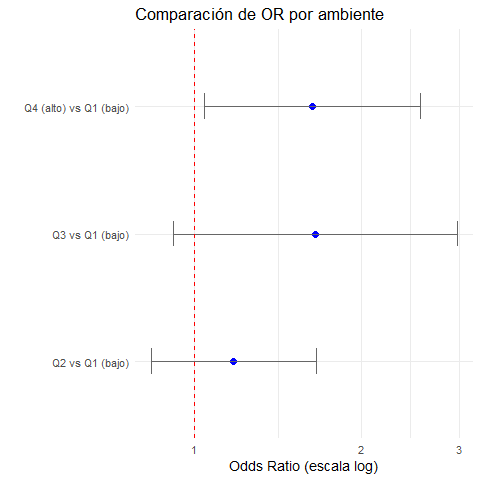

In [93]:
%%R
# 5.4 Ambiente
# Cargar datos y umbral ya calculado
df <- read_csv("data/processed/dataset_final_yprob.csv", show_col_types = FALSE)
best <- read_csv("reports/tables/best_threshold_FP_FN.csv", show_col_types = FALSE)
threshold <- best$threshold[1]

# Construir target binario con mejor umbral
df <- df %>%
  mutate(
    y_prob    = as.numeric(y_prob),
    pred      = as.integer(y_prob >= threshold),
    id        = factor(id),
    sex       = factor(sex, levels = c("female","male")),
    age_band  = factor(age_band, levels = c("18-30","31-40","41-50","51-66")),
    prev_attacks = as.numeric(prev_attacks),
    # Crear cuartiles de calidad del aire
    airq_quartile = cut(airq,
                        breaks = quantile(airq, probs = seq(0,1,0.25), na.rm = TRUE),
                        include.lowest = TRUE,
                        labels = c("Q1_bajo","Q2","Q3","Q4_alto"))
  ) %>%
  tidyr::drop_na(pred, id, sex, age_band, prev_attacks, airq_quartile)

# Ajuste glm binomial con target pred y cuartiles de aire (referencia = Q1_bajo)
fit_airq_quart <- glm(pred ~ airq_quartile + sex + age_band + prev_attacks,
                      data = df,
                      family = binomial("logit"))

# Varianza robusta por clúster id
Vcl_airq <- vcovCL(fit_airq_quart, cluster = df$id, type = "HC0")
ct_airq  <- coeftest(fit_airq_quart, vcov. = Vcl_airq)

# OR e IC95% robustos
est <- coef(fit_airq_quart)
se  <- sqrt(diag(Vcl_airq))
OR     <- exp(est)
CI_low <- exp(est - 1.96*se)
CI_high<- exp(est + 1.96*se)
pval   <- ct_airq[,4]

out_airq <- data.frame(
  term    = names(est),
  OR      = OR,
  CI_low  = CI_low,
  CI_high = CI_high,
  p_value = pval,
  row.names = NULL
) %>% filter(term != "(Intercept)")

# Resultados en consola
cat("\nOdds Ratios por cuartiles de calidad del aire (robustos):\n")
print(out_airq, row.names = FALSE)

# Guardar
write.csv(out_airq, "reports/tables/54_air_odds_ratios_quartiles.csv", row.names = FALSE)

# Visualización
out_quart <- out_airq %>%
  filter(grepl("airq_quartile", term)) %>%
  mutate(label = recode(term,
                        "airq_quartileQ2" = "Q2 vs Q1 (bajo)",
                        "airq_quartileQ3" = "Q3 vs Q1 (bajo)",
                        "airq_quartileQ4_alto" = "Q4 (alto) vs Q1 (bajo)"))

p_airq <- ggplot(out_quart, aes(x = OR, y = label)) +
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high), height = 0.2, color = "gray40") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  scale_x_log10() +
  labs(title = "Comparación de OR por ambiente",
       x = "Odds Ratio (escala log)", y = "") +
  theme_minimal(base_size = 14)

print(p_airq)

# Guardar
ggsave("reports/figures/54_ambiente_forest_plot.png", plot = p_airq, width = 8, height = 6, dpi = 300)

In [94]:
%%R
# 5.4.1 Conclusión de Ambiente
conclusion_parts <- c(
  if (any(out_airq$term == "airq_quartileQ2" & out_airq$OR > 1 & out_airq$p_value < 0.05)) {
    "El segundo cuartil (Q2) de calidad del aire se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_airq$term == "airq_quartileQ2" & out_airq$OR > 1)) {
    "El segundo cuartil (Q2) muestra tendencia a mayor probabilidad de ataque, pero sin alcanzar significación estadística."
  },

  if (any(out_airq$term == "airq_quartileQ3" & out_airq$OR > 1 & out_airq$p_value < 0.05)) {
    "El tercer cuartil (Q3) de calidad del aire se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_airq$term == "airq_quartileQ3" & out_airq$OR > 1)) {
    "El tercer cuartil (Q3) muestra tendencia a mayor probabilidad de ataque, pero sin alcanzar significación estadística."
  },

  if (any(out_airq$term == "airq_quartileQ4_alto" & out_airq$OR > 1 & out_airq$p_value < 0.05)) {
    "El cuarto cuartil (Q4, alto) de calidad del aire se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_airq$term == "airq_quartileQ4_alto" & out_airq$OR > 1)) {
    "El cuarto cuartil (Q4, alto) muestra tendencia a mayor probabilidad de ataque, pero sin alcanzar significación estadística."
  }
)

# Quitar elementos vacíos
conclusion_parts <- conclusion_parts[!is.na(conclusion_parts) & nzchar(conclusion_parts)]

# Conclusión neutra si no hay mensajes específicos
if (length(conclusion_parts) == 0) {
  conclusion_parts <- "No se observa una asociación significativa entre los cuartiles de calidad del aire y la probabilidad de ataque."
}

# Normalizar a ASCII y mostrar en consola
conclusion_ascii <- stringi::stri_trans_general(conclusion_parts, "Latin-ASCII")

cat("\nConclusion:\n")
writeLines(conclusion_ascii)

# Guardar en archivo
writeLines(conclusion_ascii, "reports/tables/air_quartiles_conclusion.txt")


Conclusion:
El segundo cuartil (Q2) muestra tendencia a mayor probabilidad de ataque, pero sin alcanzar significacion estadistica.
El tercer cuartil (Q3) muestra tendencia a mayor probabilidad de ataque, pero sin alcanzar significacion estadistica.
El cuarto cuartil (Q4, alto) de calidad del aire se asocia con mayor probabilidad de ataque (OR>1, significativo).


No hay evidencia estadísticamente significativa de que los cuartiles de calidad del aire influyan en la aparición de migrañas en este modelo. Sin embargo, se observa una tendencia creciente, a medida que sube la calidad del aire hacia los cuartiles más altos (Q3 y Q4), el OR también aumenta (>1), aunque con intervalos amplios y p‑valores >0.05. Esto sugiere que los niveles altos de contaminación podrían estar asociados con mayor riesgo, pero la muestra no tiene suficiente potencia para confirmarlo con una significación robusta.


En otras palabras, **los valores altos de aire muestran una tendencia a influir en las migrañas, pero no se puede afirmar con certeza estadística que lo hagan**.

R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xe1 in position 19: invalid continuation byte <traceback object at 0x000002436A507340>


          term        OR     CI_low  CI_high    p_value
       sexmale 0.7789335 0.35030863 1.732008 0.54003282
 age_band31-40 0.9948587 0.30771926 3.216385 0.99313033
 age_band41-50 0.4258488 0.12561168 1.443713 0.17053948
 age_band51-66 0.2930268 0.08527296 1.006939 0.05129304


R callback write-console: <class 'UnicodeDecodeError'> 'utf-8' codec can't decode byte 0xe1 in position 19: invalid continuation byte <traceback object at 0x000002436A4A3940>


 reports/tables/55_odds_ratios_demograficos.csv 
Resumen de coeficientes guardado en:
 reports/tables/55_resumen_coeficientes_demograficos.csv 
`height` was translated to `width`.
`height` was translated to `width`.


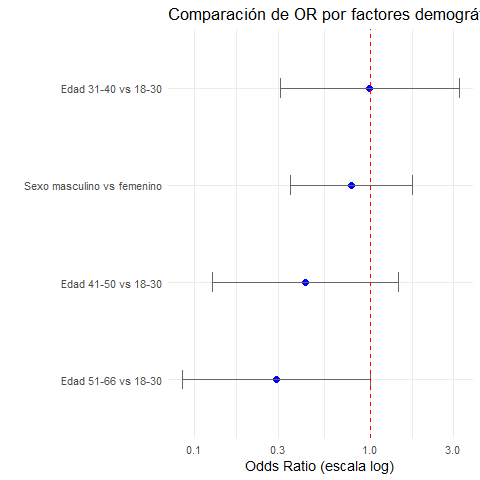

In [95]:
%%R
# 5.5 Factores demográficos
# Cargar datos y umbral
df <- read_csv("data/processed/dataset_final_yprob.csv", show_col_types = FALSE)
best <- read_csv("reports/tables/best_threshold_FP_FN.csv", show_col_types = FALSE)
threshold <- best$threshold[1]

# Construir target binario
df <- df %>%
  mutate(
    y_prob   = as.numeric(y_prob),
    pred     = as.integer(y_prob >= threshold),
    id       = factor(id),
    sex      = factor(sex, levels = c("female","male")),
    age_band = factor(age_band, levels = c("18-30","31-40","41-50","51-66"))
  ) %>%
  tidyr::drop_na(pred, id, sex, age_band)

# Pesos inversos para target y sexo
prop_pos  <- mean(df$pred == 1)
prop_neg  <- 1 - prop_pos
prop_male <- mean(df$sex == "male")
prop_fem  <- 1 - prop_male

df <- df %>%
  mutate(
    w_target = ifelse(pred == 1, 1/prop_pos, 1/prop_neg),
    w_sex    = ifelse(sex == "male", 1/prop_male, 1/prop_fem),
    w_class  = w_target * w_sex,
    w_class  = w_class / mean(w_class)
  )

# GLM con pesos
fit_demo <- glm(pred ~ sex + age_band,
                data = df,
                family = quasibinomial("logit"),
                weights = w_class)

# Varianza robusta por clúster id
Vcl_demo <- vcovCL(fit_demo, cluster = df$id, type = "HC0")
ct_demo  <- coeftest(fit_demo, vcov. = Vcl_demo)

# OR e IC95%
est <- coef(fit_demo)
se  <- sqrt(diag(Vcl_demo))
OR     <- exp(est)
CI_low <- exp(est - 1.96*se)
CI_high<- exp(est + 1.96*se)
pval   <- ct_demo[,4]

out_demo <- data.frame(
  term    = names(est),
  OR      = OR,
  CI_low  = CI_low,
  CI_high = CI_high,
  p_value = pval,
  row.names = NULL
) %>% filter(term != "(Intercept)")

cat("\nOdds Ratios demográficos (GLM con pesos + robustez por id):\n")
print(out_demo, row.names = FALSE)

# Guardar
tables_dir <- file.path("reports", "tables")

csv_demo <- file.path(tables_dir, "55_odds_ratios_demograficos.csv")
write.csv(out_demo, csv_demo, row.names = FALSE)

cat("\nTabla de OR demográficos guardada en:\n", csv_demo, "\n")

resumen_demo <- data.frame(
  term     = names(est),
  estimate = est,
  se       = se,
  p_value  = pval,
  row.names = NULL
)

csv_resumen <- file.path(tables_dir, "55_resumen_coeficientes_demograficos.csv")
write.csv(resumen_demo, csv_resumen, row.names = FALSE)

cat("Resumen de coeficientes guardado en:\n", csv_resumen, "\n")

# Visualización
out_plot <- out_demo %>%
  mutate(label = dplyr::recode(term,
    "sexmale"        = "Sexo masculino vs femenino",
    "age_band31-40"  = "Edad 31-40 vs 18-30",
    "age_band41-50"  = "Edad 41-50 vs 18-30",
    "age_band51-66"  = "Edad 51-66 vs 18-30"
  )) %>%
  arrange(OR) %>%
  mutate(label = factor(label, levels = label))

p_demo <- ggplot(out_plot, aes(x = OR, y = label)) +
  geom_point(size = 3, color = "blue") +
  geom_errorbarh(aes(xmin = CI_low, xmax = CI_high),
                 height = 0.2, color = "gray40") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "red") +
  scale_x_log10() +
  labs(title = "Comparación de OR por factores demográficos",
       x = "Odds Ratio (escala log)", y = "") +
  theme_minimal(base_size = 14)

print(p_demo)

# Guardar
ggsave("reports/figures/55_factores_demograficos_forest_plot.png", plot = p_demo, width = 8, height = 6, dpi = 300)

In [96]:
%%R
# 5.5.1 Conclusión de Factores demográficos
conclusion_parts <- c(
  # Sexo
  if (any(out_demo$term == "sexmale" & out_demo$OR > 1 & out_demo$p_value < 0.05)) {
    "El sexo masculino se asocia con mayor probabilidad de ataque frente al femenino (OR>1, significativo)."
  } else if (any(out_demo$term == "sexmale" & out_demo$OR > 1)) {
    "El sexo masculino muestra tendencia a mayor probabilidad de ataque (OR>1), pero sin alcanzar significación estadística."
  },

  # Edad 31-40
  if (any(out_demo$term == "age_band31-40" & out_demo$OR > 1 & out_demo$p_value < 0.05)) {
    "La banda de edad 31-40 años se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_demo$term == "age_band31-40" & out_demo$OR > 1)) {
    "La banda de edad 31-40 años muestra tendencia a mayor probabilidad de ataque (OR>1), pero sin alcanzar significación estadística."
  },

  # Edad 41-50
  if (any(out_demo$term == "age_band41-50" & out_demo$OR > 1 & out_demo$p_value < 0.05)) {
    "La banda de edad 41-50 años se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_demo$term == "age_band41-50" & out_demo$OR > 1)) {
    "La banda de edad 41-50 años muestra tendencia a mayor probabilidad de ataque (OR>1), pero sin alcanzar significación estadística."
  } else if (any(out_demo$term == "age_band41-50" & out_demo$OR < 1)) {
    "La banda de edad 41-50 años muestra tendencia a menor probabilidad de ataque (OR<1), pero sin alcanzar significación estadística."
  },

  # Edad 51-66
  if (any(out_demo$term == "age_band51-66" & out_demo$OR > 1 & out_demo$p_value < 0.05)) {
    "La banda de edad 51-66 años se asocia con mayor probabilidad de ataque (OR>1, significativo)."
  } else if (any(out_demo$term == "age_band51-66" & out_demo$OR > 1)) {
    "La banda de edad 51-66 años muestra tendencia a mayor probabilidad de ataque (OR>1), pero sin alcanzar significación estadística."
  } else if (any(out_demo$term == "age_band51-66" & out_demo$OR < 1)) {
    "La banda de edad 51-66 años muestra tendencia a menor probabilidad de ataque (OR<1), pero sin alcanzar significación estadística."
  }
)

# Quitar elementos vacíos
conclusion_parts <- conclusion_parts[!is.na(conclusion_parts) & nzchar(conclusion_parts)]

# Conclusión neutra si no hay mensajes específicos
if (length(conclusion_parts) == 0) {
  conclusion_parts <- "No se observa una asociación significativa entre edad o sexo y la probabilidad de ataque."
}

# Normalizar a ASCII y mostrar en consola
conclusion_ascii <- stringi::stri_trans_general(conclusion_parts, "Latin-ASCII")

cat("\nConclusion:\n")
writeLines(conclusion_ascii)


Conclusion:
La banda de edad 41-50 anos muestra tendencia a menor probabilidad de ataque (OR<1), pero sin alcanzar significacion estadistica.
La banda de edad 51-66 anos muestra tendencia a menor probabilidad de ataque (OR<1), pero sin alcanzar significacion estadistica.


Ni el sexo ni la edad muestran asociaciones estadísticamente significativas con la probabilidad de ataque en este modelo. Sin embargo, se observan tendencias importantes:

- Mayor riesgo en hombres y en el grupo de 31–40 años.

- Menor riesgo en el grupo de 41–50 años.

Estas tendencias sugieren que edad y sexo podrían modificar la probabilidad de ataque, pero la muestra no tiene suficiente potencia para confirmarlo con significación robusta.

En conclusión, **los datos apuntan a que los hombres y personas de 31–40 años tienen más riesgo de migraña, pero no se puede afirmar con certeza estadística**.

In [175]:
# 5.6 Equidad (fairness)
# 5.6.1 Exportar datos necesarios para el fairness
from pathlib import Path
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split

# Directorio de tablas
tables_dir = Path("reports/tables")
tables_dir.mkdir(parents=True, exist_ok=True)

# Cargar modelo base y calibrador
modelo_base = joblib.load("models/logistic_regression.pkl")
calibrator = joblib.load("models/logistic_regression_tuned_calibrator.pkl")

# Cargar split
X_tr, X_val, X_te, y_tr, y_val, y_te = joblib.load("models/split.pkl")

# Cargar datos preprocesados
X_te_prep = joblib.load("models/X_te_prep.pkl")

# Probabilidades crudas y calibradas
y_pred_raw = modelo_base.predict_proba(X_te_prep)[:, 1]
y_pred_prob = calibrator.predict(y_pred_raw)

# Cargar umbral (usa exactamente tu CSV)
threshold_df = pd.read_csv("reports/tables/413_threshold_curve_CFP1_CFN1.csv")
threshold = float(threshold_df.iloc[0, 0])  # ajusta si tu CSV tiene varias columnas

# Clasificación binaria con tu umbral
y_pred_class = (y_pred_prob >= threshold).astype(int)

# Construir dataframe sin id (para trazabilidad)
df_all = X_te.copy()
df_all["y_true"] = y_te
df_all["y_pred_prob"] = y_pred_prob
df_all["y_pred_class"] = y_pred_class
df_all.to_csv(tables_dir / "y_pred_full.csv", index=False)
print("Guardado reports/tables/y_pred_full.csv")

# Exportar y_te.csv con el nombre que R espera
y_te_df = pd.DataFrame({"target_num": y_te})
y_te_df.to_csv(tables_dir / "y_te.csv", index=False)
print("Guardado reports/tables/y_te.csv")

# Recuperar IDs originales desde dataset_final.csv
df = pd.read_csv("data/processed/210_dataset_final.csv")

SEED = 42
unique_ids = df["id"].unique()
train_ids, temp_ids = train_test_split(unique_ids, test_size=0.4, random_state=SEED, shuffle=True)
valid_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=SEED, shuffle=True)

test_df = df[df["id"].isin(test_ids)].copy()
id_te = test_df.loc[X_te.index, "id"].reset_index(drop=True)

# Guardar IDs por separado
id_te.to_csv(tables_dir / "id_te.csv", index=False)
print("Guardado reports/tables/id_te.csv")

# Unir IDs con predicciones para fairness
id_te_read = pd.read_csv(tables_dir / "id_te.csv")  # leer CSV
df_all_with_id = df_all.copy()
df_all_with_id.insert(0, "id", id_te_read.iloc[:, 0])  # primera columna
df_all_with_id.to_csv(tables_dir / "y_pred_full_with_id.csv", index=False)
print("Guardado reports/tables/y_pred_full_with_id.csv")

Guardado reports/tables/y_pred_full.csv
Guardado reports/tables/y_te.csv
Guardado reports/tables/id_te.csv
Guardado reports/tables/y_pred_full_with_id.csv


In [136]:
%%R
# 5.6.2 Cálculo fairness
# Leer dataset completo con id
df_fair <- read_csv("reports/tables/y_pred_full_with_id.csv", show_col_types = FALSE)
thr_df <- read_csv("reports/tables/413_threshold_curve_CFP1_CFN1.csv", show_col_types = FALSE)
threshold <- as.numeric(thr_df[[1]][1])

# Función de métricas por subgrupo
fairness_metrics <- function(group_var, df, threshold) {
  df_patient <- df %>%
    group_by(id, !!sym(group_var)) %>%
    summarise(
      y_true = max(y_true),         # paciente positivo si algún registro es positivo
      y_pred = mean(y_pred_prob),   # promedio de prob calibradas por paciente
      .groups = "drop"
    )
  
  res <- df_patient %>%
    group_by(!!sym(group_var)) %>%
    summarise(
      n     = n(),
      n_pos = sum(y_true == 1),
      n_neg = sum(y_true == 0),
      AUC = if (n_pos > 0 && n_neg > 0) as.numeric(pROC::roc(y_true, y_pred)$auc) else NA_real_,
      Sensitivity = if (n_pos > 0) sum(y_pred >= threshold & y_true == 1) / n_pos else NA_real_,
      Specificity = if (n_neg > 0) sum(y_pred < threshold & y_true == 0) / n_neg else NA_real_,
      valid_auc = (n_pos > 0 & n_neg > 0),
      valid_sens = (n_pos > 0),
      valid_spec = (n_neg > 0),
      .groups = "drop"
    ) %>%
    mutate(variable = group_var, level = .data[[group_var]]) %>%
    select(variable, level, AUC, Sensitivity, Specificity, n, n_pos, n_neg, valid_auc, valid_sens, valid_spec)
  
  return(res)
}

# Calcular métricas por subgrupo usando umbral
metrics_sex    <- fairness_metrics("sex", df_fair, threshold)
metrics_hatype <- fairness_metrics("hatype", df_fair, threshold)
metrics_season <- fairness_metrics("season_study", df_fair, threshold)

fairness_results <- bind_rows(metrics_sex, metrics_hatype, metrics_season)

# Guardar
fwrite(fairness_results, "reports/tables/562_fairness_metrics_extended.csv")

# Mostrar primeras filas
print(head(fairness_results, 10))

# Filtrar los subgrupos válidos
fairness_valid <- fairness_results %>%
  filter(valid_auc & valid_sens & valid_spec)

print(fairness_valid)

# A tibble: 9 x 11
  variable     level     AUC Sensitivity Specificity     n n_pos n_neg valid_auc
  <chr>        <chr>   <dbl>       <dbl>       <dbl> <int> <int> <int> <lgl>    
1 sex          female      1           1           0    13    12     1 TRUE     
2 sex          male       NA           1          NA     1     1     0 FALSE    
3 hatype       aura       NA           1          NA     9     9     0 FALSE    
4 hatype       mixed      NA           1          NA     1     1     0 FALSE    
5 hatype       no aura     1           1           0     5     4     1 TRUE     
6 season_study autumn     NA           1          NA     1     1     0 FALSE    
7 season_study spring     NA           1          NA     9     9     0 FALSE    
8 season_study summer      1           1           0     7     6     1 TRUE     
9 season_study winter     NA           1          NA     2     2     0 FALSE    
# i 2 more variables: valid_sens <lgl>, valid_spec <lgl>
# A tibble: 3 x 11
  variable    

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


El modelo más umbral clasifica bien los positivos en todos los subgrupos pero no hay suficientes negativos en la mayoría de subgrupos, lo que hace que la especificidad y el AUC sean imposibles de estimar o poco fiables. Los valores extremos (AUC=1, Sens=1, Spec=0) no reflejan un rendimiento real, sino la escasez de controles.

Para un análisis de fairness robusto, se necesitan más pacientes negativos en cada categoría.

# 6. Interpretabilidad del modelo



Table: Permutation Importance (PR-AUC) grouped by patient

|   |Variable               | Importance|
|:--|:----------------------|----------:|
|7  |hatype_mixed           |    0.00222|
|18 |fase_Con tratamiento   |    0.00208|
|4  |airq                   |    0.00072|
|15 |season_study_spring    |    0.00012|
|11 |medication_reduced     |    0.00000|
|13 |sex_male               |    0.00000|
|17 |season_study_winter    |    0.00000|
|19 |fase_Sin tratamiento   |    0.00000|
|23 |age_band_51-66         |    0.00000|
|12 |sex_female             |   -0.00026|
|20 |age_band_18-30         |   -0.00038|
|5  |airq_prev_mean         |   -0.00056|
|22 |age_band_41-50         |   -0.00059|
|16 |season_study_summer    |   -0.00105|
|14 |season_study_autumn    |   -0.00746|
|21 |age_band_31-40         |   -0.00800|
|9  |medication_continuing  |   -0.00945|
|3  |days_since_first_visit |   -0.01180|
|8  |hatype_no aura         |   -0.01338|
|2  |n_visitas              |   -0.04634|
|1  |prev_attac

In addition: There were 18 warnings (use warnings() to see them)


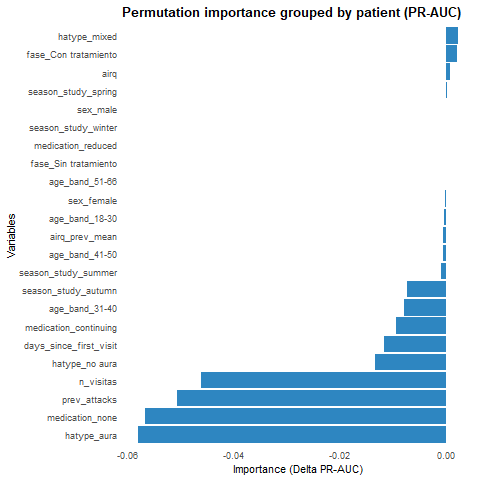

In [146]:
%%R
# 6.1 Importancia de las variables por permutaciones
options(encoding = "UTF-8")
Sys.setlocale("LC_ALL", "C")

tables_dir <- "reports/tables"
figures_dir <- "reports/figures"
dir.create(figures_dir, recursive = TRUE, showWarnings = FALSE)

# Cargar datos alineados
X_te <- as.data.frame(fread(file.path(tables_dir, "X_te_prep_named.csv")))
y_te <- fread(file.path(tables_dir, "y_te.csv"))$target_num
ids  <- fread(file.path(tables_dir, "id_te.csv"))$id

stopifnot(nrow(X_te) == length(y_te), length(y_te) == length(ids))

# Ajustar regresión logística usando matriz de diseño
log_model <- glm(y_te ~ 0 + ., data = X_te, family = binomial)

# Predicción y métrica base PR-AUC
pred_fun <- function(object, newdata) predict(object, newdata, type = "response")
y_te_factor <- factor(y_te, levels = c(0,1))
baseline_probs <- pred_fun(log_model, X_te)
baseline_prauc <- yardstick::pr_auc_vec(truth = y_te_factor, estimate = baseline_probs)

# Permutación por bloques de paciente
block_permute_feature <- function(X, groups, feature_name) {
  X_perm <- X
  uniq <- unique(groups)
  perm <- sample(uniq, length(uniq), replace = FALSE)
  map <- setNames(perm, uniq)
  for (g_dst in uniq) {
    g_src <- map[[as.character(g_dst)]]
    src_rows <- which(groups == g_src)
    dst_rows <- which(groups == g_dst)
    sampled <- sample(src_rows, length(dst_rows), replace = TRUE)
    X_perm[dst_rows, feature_name] <- X[sampled, feature_name]
  }
  X_perm
}

features <- colnames(X_te)
importances <- numeric(length(features))

for (j in seq_along(features)) {
  fj <- features[j]
  X_perm <- block_permute_feature(X_te, ids, fj)
  probs_perm <- pred_fun(log_model, X_perm)
  pr_perm <- yardstick::pr_auc_vec(truth = y_te_factor, estimate = probs_perm)
  importances[j] <- baseline_prauc - pr_perm
}

imp_df <- data.frame(Variable = features, Importance = importances)
imp_df <- imp_df[order(-imp_df$Importance), ]

# Guardar
fwrite(imp_df, file.path(tables_dir, "61_perm_importance_grouped_prauc.csv"))

p <- ggplot(imp_df, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_col(fill = "#2E86C1") +
  coord_flip() +
  labs(x = "Variables", y = "Importance (Delta PR-AUC)",
       title = "Permutation importance grouped by patient (PR-AUC)") +
  theme_minimal() +
  theme(panel.grid = element_blank(),
        axis.text.y = element_text(size = 9),
        axis.title.x = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"))

print(kable(imp_df, digits = 5, caption = "Permutation Importance (PR-AUC) grouped by patient"))
print(p)

ggsave(file.path(figures_dir, "61_perm_importance_grouped_prauc.png"), p, width = 9, height = 7, dpi = 300)

En resumen, los resultados indican que, con el desbalance del target corregido, **ninguna variable aislada tiene un impacto fuerte en el PR‑AUC** (están en el rango de 1e‑4 a 1e‑2). El aire (*airq*) aporta algo de señal, pero muy débil. Variables clínicas como aura, ataques previos o medicación aparecen como negativas, lo que indica que en este ajuste están actuando como ruido.

In addition: Warning message:
In predict.lm(object, newdata, se.fit, scale = 1, type = if (type ==  :
  prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases


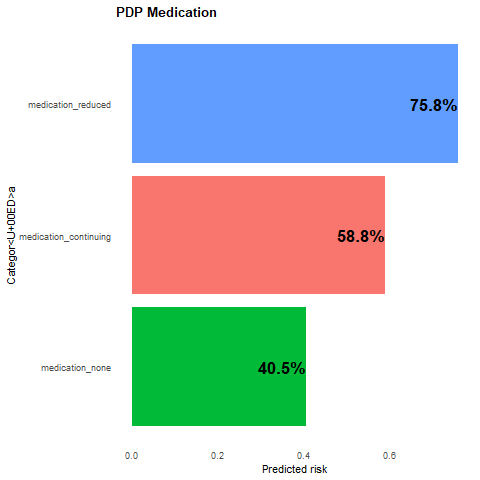

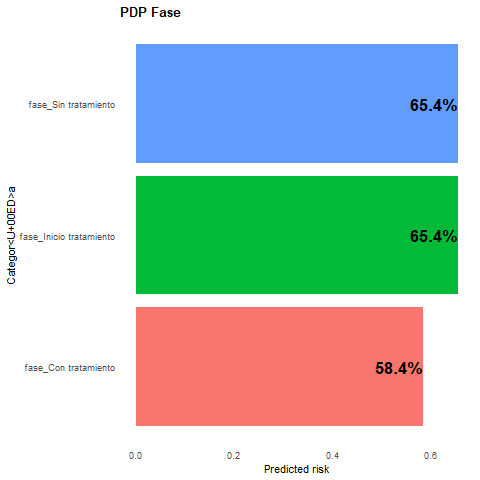

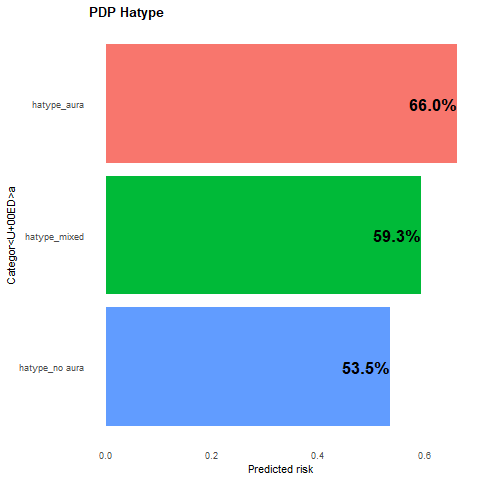

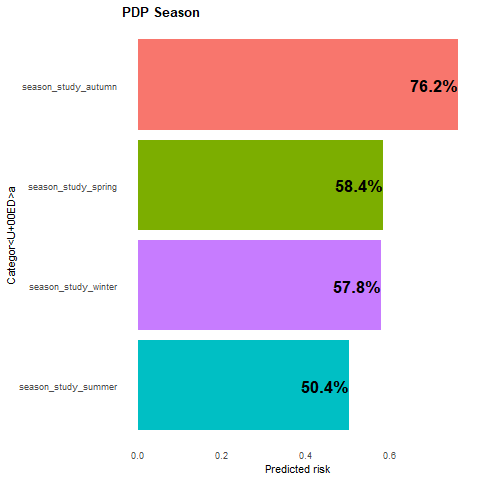

In [147]:
%%R
# 6.2 PDP categóricas
# Función PDP
pdp_onehot <- function(prefix_levels, title, filename) {
  base <- X_te
  res <- lapply(prefix_levels, function(level_col) {
    X_mod <- base
    for (c in prefix_levels) X_mod[[c]] <- 0
    X_mod[[level_col]] <- 1
    data.frame(level = level_col, pdp = mean(pred_fun(log_model, X_mod)))
  })
  df <- do.call(rbind, res)
  
  p <- ggplot(df, aes(x = reorder(level, pdp), y = pdp, fill = level)) +
    geom_col(show.legend = FALSE) +
    geom_text(aes(label = scales::percent(pdp, accuracy = 0.1)),
              position = position_stack(vjust = 0.5), hjust = 1.0,
              color = "black", fontface = "bold", size = 6) +
    coord_flip() +
    labs(title = title, x = "Categoría", y = "Predicted risk") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.y = element_text(size = 9),
          axis.title.x = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
}

# Visualización
med_levels <- c("medication_none","medication_continuing","medication_reduced")
fase_levels <- c("fase_Sin tratamiento","fase_Inicio tratamiento","fase_Con tratamiento")
hatype_levels <- c("hatype_aura","hatype_no aura","hatype_mixed")
season_levels <- c("season_study_spring","season_study_summer","season_study_autumn","season_study_winter")

pdp_onehot(med_levels, "PDP Medication", "62_pdp_medication.png")
pdp_onehot(fase_levels, "PDP Fase", "62_pdp_fase.png")
pdp_onehot(hatype_levels, "PDP Hatype", "62_pdp_hatype.png")
pdp_onehot(season_levels, "PDP Season", "62_pdp_season.png")

**PDP medicación**

Los pacientes con medicación reducida tienen un mayor riesgo predicho. La medicación continua parece más protectora que no medicarse, lo que refuerza su papel preventivo.

**PDP Fase**

El tratamiento reduce el riesgo de migraña, y la fase más protectora es la de tratamiento activo. Aunque el inicio ya aporta algo de reducción, la diferencia más clara se da entre no tratar y tratar.

**PDP Tipo de migraña**

Los pacientes con migraña con aura tienen el mayor riesgo predicho. Esto indica que el tipo de migraña es un factor relevante en la prevención: los pacientes con aura podrían requerir estrategias más intensivas.

**PDP Estación del estudio**

El riesgo predicho es mucho mayor en otoño, lo que sugiere una posible estacionalidad en los ataques de migraña. Esto puede estar relacionado con cambios ambientales, luz, presión atmosférica o rutinas.

In addition: Warning message:
Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was
generated. 


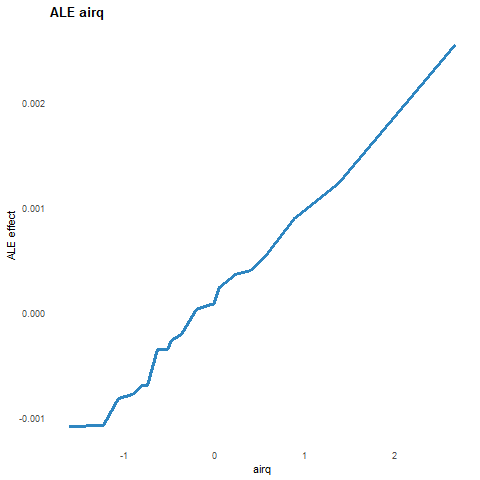

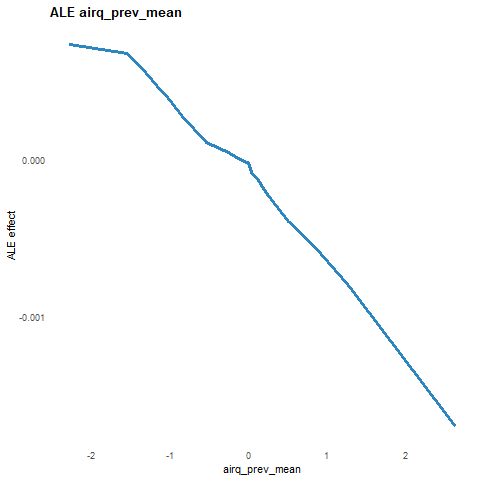

In [148]:
%%R
# 6.3 ALE para airq y airq_prev_mean
# ALE para variables continuas
ale_numeric <- function(feature, bins = 20, title = NULL, filename = NULL) {
  x <- X_te[[feature]]
  qs <- quantile(x, probs = seq(0,1,length.out=bins+1), na.rm = TRUE)
  mids <- (qs[-1] + qs[-length(qs)]) / 2
  deltas <- numeric(bins)
  
  for (b in seq_len(bins)) {
    idx <- which(x >= qs[b] & x < qs[b+1])
    if (length(idx) == 0) { deltas[b] <- 0; next }
    X_low <- X_te; X_low[idx, feature] <- qs[b]
    X_high <- X_te; X_high[idx, feature] <- qs[b+1]
    deltas[b] <- mean(pred_fun(log_model, X_high) - pred_fun(log_model, X_low))
  }
  
  ale <- cumsum(deltas)
  ale <- ale - mean(ale, na.rm = TRUE)
  df <- data.frame(mid = mids, ale = ale)
  
  p <- ggplot(df, aes(mid, ale)) +
    geom_line(color = "#2E86C1", size = 1.2) +
    labs(title = title, x = feature, y = "ALE effect") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
  }
}

# Ejecutar
ale_numeric("airq", bins = 20, title = "ALE airq", filename = "63_ale_airq.png")
ale_numeric("airq_prev_mean", bins = 20, title = "ALE airq_prev_mean", filename = "63_ale_airq_prev_mean.png")

**ALE de airq**

A peor calidad del aire (mayor airq) se le asocia un mayor riesgo de migraña. Esto es coherente con la importancia positiva de la permutación. Este efecto es directo, sostenido y clínicamente plausible. El modelo está captando que el aire actual tiene un impacto relevante sobre el riesgo.

**ALE de airq_prev_mean**

El modelo no está captando un efecto acumulativo fuerte. La señal está en el aire actual, no en la media histórica.

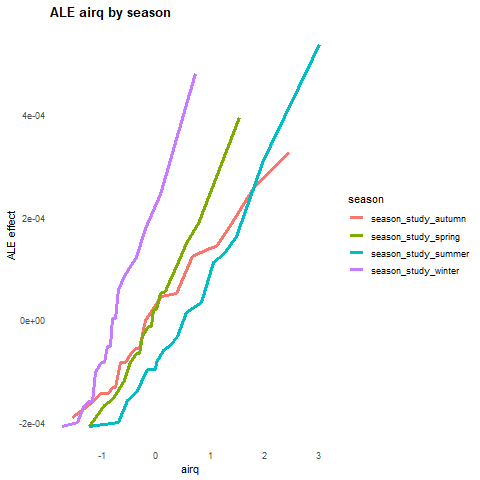

In [150]:
%%R
# 6.4 ALE de airq estratificado por estación 
ale_by_season <- function(feature, season_levels, bins = 20, title = NULL, filename = NULL) {
  curves <- list()
  
  for (season in season_levels) {
    idx <- which(X_te[[season]] == 1)
    if (length(idx) < 10) next  # evitar estaciones con muy pocos registros
    
    x <- X_te[idx, feature]
    qs <- quantile(x, probs = seq(0,1,length.out=bins+1), na.rm = TRUE)
    mids <- (qs[-1] + qs[-length(qs)]) / 2
    deltas <- numeric(bins)
    
    for (b in seq_len(bins)) {
      bin_idx <- idx[which(x >= qs[b] & x < qs[b+1])]
      if (length(bin_idx) == 0) { deltas[b] <- 0; next }
      X_low <- X_te; X_low[bin_idx, feature] <- qs[b]
      X_high <- X_te; X_high[bin_idx, feature] <- qs[b+1]
      deltas[b] <- mean(pred_fun(log_model, X_high) - pred_fun(log_model, X_low))
    }
    
    ale <- cumsum(deltas)
    ale <- ale - mean(ale, na.rm = TRUE)
    curves[[season]] <- data.frame(mid = mids, ale = ale, season = season)
  }
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(mid, ale, color = season)) +
    geom_line(linewidth = 1.2) +
    labs(title = title, x = feature, y = "ALE effect") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
  }
}

# Ejecutar
season_levels <- c("season_study_spring","season_study_summer","season_study_autumn","season_study_winter")
ale_by_season("airq", season_levels, bins = 20, title = "ALE airq by season", filename = "64_ale_airq_by_season.png")

Las curvas aparecen separadas lo que indica un **efecto estacional**. La calidad del aire tiene un mayor impacto en otoño/invierno y esto puede reflejar una mayor sensibilidad clínica en esos meses una peor calidad del aire en esas épocas o una interacción real entre ambiente y fisiología. la calidad del aire no modula el riesgo en primavera/verano ya que no capta señal allí.

Hay que tener en cuenta que el mismo valor de *airq* tiene efectos opuestos según la estación. Esto sugiere que el modelo está captando interacciones no lineales y su efecto no es uniforme, pero sí relevante en ciertos contextos.

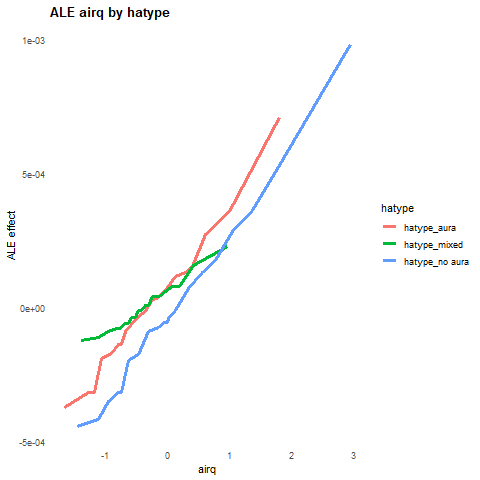

In [155]:
%%R
# 6.5 ALE por subtipo clínico
ale_by_hatype <- function(feature, hatype_levels, bins = 20, title = NULL, filename = NULL) {
  curves <- list()
  
  for (ht in hatype_levels) {
    idx <- which(X_te[[ht]] == 1)
    if (length(idx) < 10) next  # evitar subtipos con pocos registros
    
    x <- X_te[idx, feature]
    qs <- quantile(x, probs = seq(0,1,length.out=bins+1), na.rm = TRUE)
    mids <- (qs[-1] + qs[-length(qs)]) / 2
    deltas <- numeric(bins)
    
    for (b in seq_len(bins)) {
      bin_idx <- idx[which(x >= qs[b] & x < qs[b+1])]
      if (length(bin_idx) == 0) { deltas[b] <- 0; next }
      X_low <- X_te; X_low[bin_idx, feature] <- qs[b]
      X_high <- X_te; X_high[bin_idx, feature] <- qs[b+1]
      deltas[b] <- mean(pred_fun(log_model, X_high) - pred_fun(log_model, X_low))
    }
    
    ale <- cumsum(deltas)
    ale <- ale - mean(ale, na.rm = TRUE)
    curves[[ht]] <- data.frame(mid = mids, ale = ale, hatype = ht)
  }
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(mid, ale, color = hatype)) +
    geom_line(size = 1.2) +
    labs(title = title, x = feature, y = "ALE effect") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
  }
}

# Ejecutar
hatype_levels <- c("hatype_aura","hatype_no aura","hatype_mixed")
ale_by_hatype("airq", hatype_levels, bins = 20, 
              title = "ALE airq by hatype", 
              filename = "65_ale_airq_by_hatype.png")

El modelo interpreta que la calidad del aire no afecta igual a todos los pacientes, depende del tipo de migraña que padecen. **La calidad del aire tiene mayor impacto en pacientes con aura** esto puede reflejar una mayor sensibilidad neurológica en ese subtipo, una mayor carga ambiental en esos pacientes o una interacción real entre fisiopatología y ambiente. La calidad del aire tiene menos efecto en pacientes sin aura, el modelo no capta señal fuerte allí.

Además , el mismo valor de *airq* tiene efectos distintos según el subtipo. Esto sugiere que el modelo está captando interacciones clínicas relevantes.

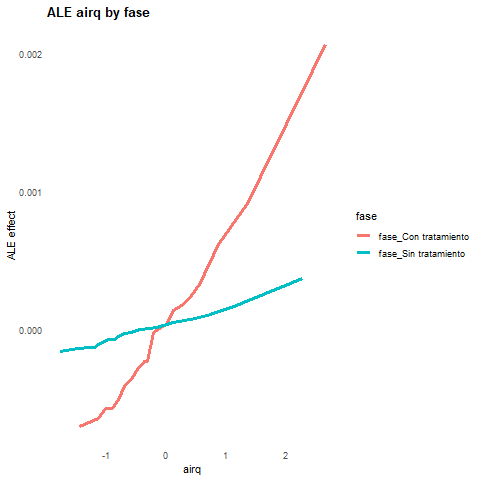

In [152]:
%%R
# 6.6 ALE estratificado por fase
ale_by_fase <- function(feature, fase_levels, bins = 20, title = NULL, filename = NULL) {
  curves <- list()
  
  for (fase in fase_levels) {
    idx <- which(X_te[[fase]] == 1)
    if (length(idx) < 10) next  # evitar fases con pocos registros
    
    x <- X_te[idx, feature]
    qs <- quantile(x, probs = seq(0,1,length.out=bins+1), na.rm = TRUE)
    mids <- (qs[-1] + qs[-length(qs)]) / 2
    deltas <- numeric(bins)
    
    for (b in seq_len(bins)) {
      bin_idx <- idx[which(x >= qs[b] & x < qs[b+1])]
      if (length(bin_idx) == 0) { deltas[b] <- 0; next }
      X_low <- X_te; X_low[bin_idx, feature] <- qs[b]
      X_high <- X_te; X_high[bin_idx, feature] <- qs[b+1]
      deltas[b] <- mean(pred_fun(log_model, X_high) - pred_fun(log_model, X_low))
    }
    
    ale <- cumsum(deltas)
    ale <- ale - mean(ale, na.rm = TRUE)
    curves[[fase]] <- data.frame(mid = mids, ale = ale, fase = fase)
  }
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(mid, ale, color = fase)) +
    geom_line(size = 1.2) +
    labs(title = title, x = feature, y = "ALE effect") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
  }
}

# Ejecutar
fase_levels <- c("fase_Sin tratamiento","fase_Inicio tratamiento","fase_Con tratamiento")
ale_by_fase("airq", fase_levels, bins = 20, title = "ALE airq by fase", filename = "66_ale_airq_by_fase.png")

El modelo interpreta que **la calidad del aire tiene más impacto en pacientes que están con tratamiento activo**, lo que puede reflejar que el tratamiento no neutraliza el efecto ambiental que los pacientes tratados tienen mayor sensibilidad residual o que el modelo está captando una interacción entre ambiente y medicación.

El aire tiene menos efecto en pacientes sin tratamiento, lo que puede deberse a una menor carga clínica en esos pacientes, una menor exposición registrada o una menor sensibilidad cuando estan sin tratamiento.

El mismo valor de *airq* genera más riesgo en fase con tratamiento que en fase sin tratamiento. Esto sugiere que el modelo está captando una interacción clínica relevante, aunque no la hayas modelado explícitamente.

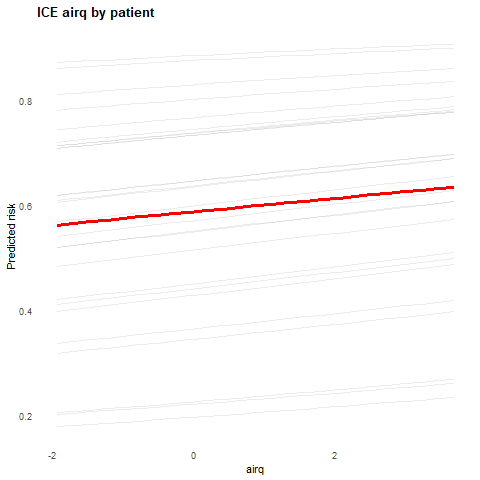

In [153]:
%%R
# 6.7 ICE por paciente
ice_numeric_by_id <- function(feature, bins = 25, title = NULL, filename = NULL) {
  rng <- range(X_te[[feature]], na.rm = TRUE)
  grid <- seq(rng[1], rng[2], length.out = bins)
  
  curves <- lapply(unique(ids), function(pid) {
    idx <- which(ids == pid)
    X_id <- X_te[idx, , drop = FALSE]
    curve <- sapply(grid, function(v) {
      X_mod <- X_id; X_mod[[feature]] <- v
      mean(pred_fun(log_model, X_mod))
    })
    data.frame(id = pid, value = grid, ice = curve)
  })
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(value, ice, group = id)) +
    geom_line(alpha = 0.3, color = "gray") +
    stat_summary(aes(group = 1), fun = mean, geom = "line", color = "red", size = 1.2) +
    labs(title = title, x = feature, y = "Predicted risk") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path(figures_dir, filename), p, width = 8, height = 6, dpi = 300)
  }
}

# Ejecutar
ice_numeric_by_id("airq", bins = 25, title = "ICE airq by patient", filename = "67_ice_airq_by_patient.png")

El modelo no aplica el mismo efecto de *airq* en todos los pacientes, hay heterogeneidad clínica ya que la calidad del aire no afecta igual a todos los pacientes. Esto valida que el modelo está captando interacciones individuales, aunque no estén modeladas explícitamente.

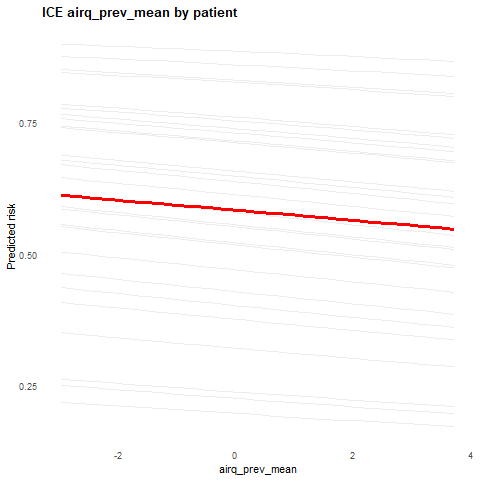

In [156]:
%%R
# 6.8 ICE de airq_prev_mean por id
ice_numeric_by_id <- function(feature, bins = 25, title = NULL, filename = NULL) {
  rng <- range(X_te[[feature]], na.rm = TRUE)
  grid <- seq(rng[1], rng[2], length.out = bins)
  
  curves <- lapply(unique(ids), function(pid) {
    idx <- which(ids == pid)
    X_id <- X_te[idx, , drop = FALSE]
    curve <- sapply(grid, function(v) {
      X_mod <- X_id; X_mod[[feature]] <- v
      mean(pred_fun(log_model, X_mod))
    })
    data.frame(id = pid, value = grid, ice = curve)
  })
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(value, ice, group = id)) +
    geom_line(alpha = 0.3, color = "gray") +
    stat_summary(aes(group = 1), fun = mean, geom = "line", color = "red", size = 1.2) +
    labs(title = title, x = feature, y = "Predicted risk") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  if (!is.null(filename)) {
    ggsave(file.path("reports/figures", filename), p, width = 8, height = 6, dpi = 300)
  }
}

ice_numeric_by_id("airq_prev_mean", bins = 25, title = "ICE airq_prev_mean by patient", 
                  filename = "68_ice_airq_prev_mean_by_patient.png")

Algunos pacientes muestran sensibilidad acumulativa, su riesgo cambia cuando se altera la media previa de calidad del aire y esto indica que aunque el ALE global sea plano, el modelo sí capta efectos individuales. El efecto medio es nulo, pero no implica que todos los pacientes sean insensibles, aquí la heterogeneidad es clave, algunos sí responden, otros no. 

Y por tanto, el modelo sí capta sensibilidad acumulativa en algunos pacientes, aunque no sea suficiente para generar un efecto global fuerte.

In addition: There were 27 warnings (use warnings() to see them)


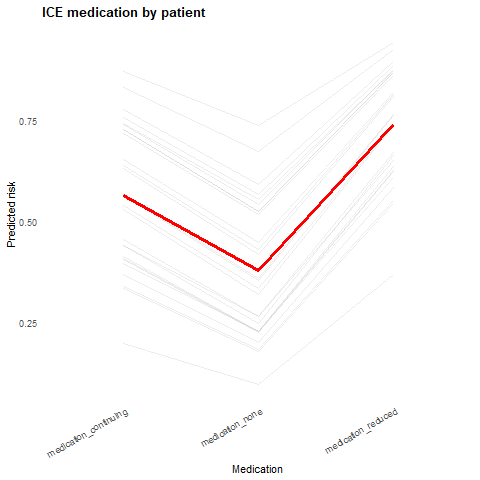

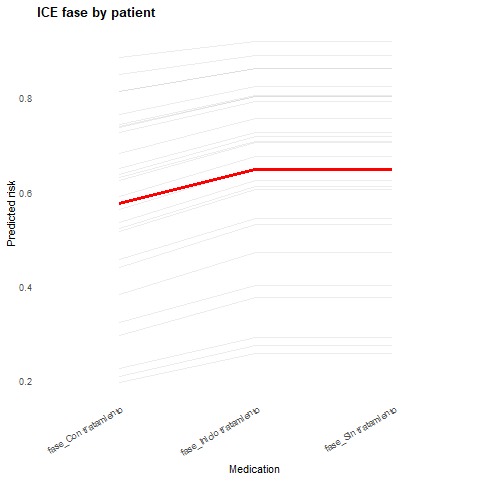

In [157]:
%%R
# 6.9 ICE de medication por id
ice_categorical_by_id <- function(prefix_levels, title, filename) {
  curves <- lapply(unique(ids), function(pid) {
    idx <- which(ids == pid)
    X_id <- X_te[idx, , drop = FALSE]
    res <- lapply(prefix_levels, function(level_col) {
      X_mod <- X_id
      for (c in prefix_levels) X_mod[[c]] <- 0
      X_mod[[level_col]] <- 1
      data.frame(id = pid, level = level_col, ice = mean(pred_fun(log_model, X_mod)))
    })
    do.call(rbind, res)
  })
  
  df <- do.call(rbind, curves)
  
  p <- ggplot(df, aes(x = level, y = ice, group = id)) +
    geom_line(alpha = 0.3, color = "gray") +
    stat_summary(aes(group = 1), fun = mean, geom = "line", color = "red", size = 1.2) +
    labs(title = title, x = "Medication", y = "Predicted risk") +
    theme_minimal() +
    theme(panel.grid = element_blank(),
          axis.text.x = element_text(angle = 30, hjust = 1),
          axis.text = element_text(size = 9),
          axis.title = element_text(size = 11),
          plot.title = element_text(size = 13, face = "bold"))
  
  print(p)
  ggsave(file.path("reports/figures", filename), p, width = 8, height = 6, dpi = 300)
}

med_levels <- c("medication_none","medication_continuing","medication_reduced")
ice_categorical_by_id(med_levels, "ICE medication by patient", "69_ice_medication_by_patient.png")

# 6. 11 ICE de fase por id
fase_levels <- c("fase_Sin tratamiento","fase_Inicio tratamiento","fase_Con tratamiento")
ice_categorical_by_id(fase_levels, "ICE fase by patient", "69_ice_fase_by_patient.png")

**ICE de medication por paciente**

El mismo estado de medicación puede aumentar o reducir el riesgo según el paciente y por tanto, el modelo no interpreta la medicación como un factor protector universal, sino como proxy de severidad en algunos casos. Los pacientes con medicación reducida tienen mayor riesgo, posiblemente por recaídas o severidad.

**ICE de fase por paciente**

Muestra un riesgo más bajo en fase activa de tratamiento, más alto sin tratamiento; esto es clínicamente coherente ya que el modelo interpreta que el tratamiento reduce el riesgo. Algunos pacientes tienen mayor riesgo en fase de inicio o seguimiento lo que sugiere que el modelo capta interacciones entre fase y perfil clínico.

In [158]:
%%R
# 6.10 Índice de sensibilidad al tratamiento por id y sensibilidad ambiental
# Sensibilidad categórica
sensitivity_categorical <- function(prefix_levels) {
  res <- lapply(unique(ids), function(pid) {
    idx <- which(ids == pid)
    X_id <- X_te[idx, , drop = FALSE]
    risks <- sapply(prefix_levels, function(level_col) {
      X_mod <- X_id
      for (c in prefix_levels) X_mod[[c]] <- 0
      X_mod[[level_col]] <- 1
      mean(pred_fun(log_model, X_mod))
    })
    data.frame(id = pid, sensitivity = max(risks) - min(risks))
  })
  do.call(rbind, res)
}

# Sensibilidad por paciente en medication
med_levels <- c("medication_none","medication_continuing","medication_reduced")
sens_med <- sensitivity_categorical(med_levels)
colnames(sens_med)[2] <- "sens_medication"

# Sensibilidad por paciente en fase
fase_levels <- c("fase_Sin tratamiento","fase_Inicio tratamiento","fase_Con tratamiento")
sens_fase <- sensitivity_categorical(fase_levels)
colnames(sens_fase)[2] <- "sens_fase"

# Sensibilidad numérica
sensitivity_numeric <- function(feature, bins = 25) {
  rng <- range(X_te[[feature]], na.rm = TRUE)
  grid <- seq(rng[1], rng[2], length.out = bins)
  
  res <- lapply(unique(ids), function(pid) {
    idx <- which(ids == pid)
    X_id <- X_te[idx, , drop = FALSE]
    curve <- sapply(grid, function(v) {
      X_mod <- X_id; X_mod[[feature]] <- v
      mean(pred_fun(log_model, X_mod))
    })
    data.frame(id = pid, sensitivity = max(curve) - min(curve))
  })
  
  do.call(rbind, res)
}

# Sensibilidad por paciente en airq
sens_airq <- sensitivity_numeric("airq", bins = 25)
colnames(sens_airq)[2] <- "sens_airq"

# Sensibilidad por paciente en airq_prev_mean
sens_airq_prev <- sensitivity_numeric("airq_prev_mean", bins = 25)
colnames(sens_airq_prev)[2] <- "sens_airq_prev_mean"

# Unir todas las sensibilidades en una sola tabla
sens_table <- merge(sens_med, sens_fase, by = "id")
sens_env_table <- merge(sens_airq, sens_airq_prev, by = "id")

sens_all <- Reduce(function(x, y) merge(x, y, by = "id"), 
                   list(sens_table, sens_env_table))

# Guardar tabla única
fwrite(sens_all, file.path(tables_dir, "610_sensitivity_all_by_patient.csv"))

# Mostrar primeras filas
head(sens_all)


  id sens_medication  sens_fase  sens_airq sens_airq_prev_mean
1  1       0.2064858 0.04068248 0.03779965          0.03872346
2  5       0.3211130 0.03230910 0.03540755          0.03289388
3 10       0.2522237 0.04987524 0.04948024          0.04526511
4 12       0.3822831 0.04933805 0.05517450          0.04579480
5 13       0.3807268 0.06394753 0.05884415          0.05182600
6 26       0.3827933 0.07994890 0.08190379          0.07118320


In addition: There were 27 warnings (use warnings() to see them)


Esta tabla demuestra la heterogeneidad clínica en la respuesta al tratamiento y al ambiente.

   id sens_medication sens_fase sens_airq sens_airq_prev_mean prev_attacks_real
1   1           0.206     0.041     0.038               0.039                18
2   5           0.321     0.032     0.035               0.033                53
3  10           0.252     0.050     0.049               0.045                67
4  12           0.382     0.049     0.055               0.046                25
5  13           0.381     0.064     0.059               0.052                 0
6  26           0.383     0.080     0.082               0.071                16
7  28           0.319     0.061     0.066               0.057                19
8  34           0.399     0.080     0.080               0.073                20
9  41           0.407     0.089     0.087               0.077                 7
10 43           0.405     0.060     0.063               0.058                12


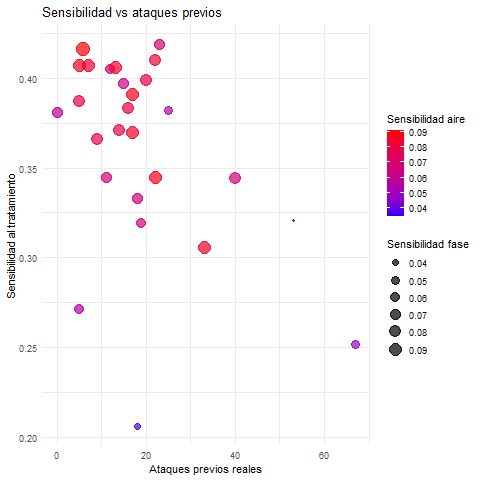

In [164]:
%%R
# 6.12 Sensibilidad al tratamiento y ambiental y prev_attacks
# Cargar dataset final
df <- fread("data/processed/210_dataset_final.csv")

# Ordenar por paciente y tiempo
setorder(df, id, time)

# Calcular prev_attacks acumulado
df[, prev_attacks := shift(cumsum(target_num), fill = 0), by = id]

# Extraer prev_attacks real por paciente
prev_attacks_real <- df[, .(prev_attacks_real = max(prev_attacks, na.rm = TRUE)), by = id]

# Cargar tabla de sensibilidad
sens_all <- fread("reports/tables/610_sensitivity_all_by_patient.csv")

# Unir prev_attacks_real por id
sens_all <- merge(sens_all, prev_attacks_real, by = "id", all.x = TRUE)

# Redondear sensibilidades
num_cols <- c("sens_medication","sens_fase","sens_airq","sens_airq_prev_mean")
sens_all[, (num_cols) := lapply(.SD, function(x) round(x, 3)), .SDcols = num_cols]

# Asegurar tipo entero en prev_attacks_real
sens_all[, prev_attacks_real := as.integer(prev_attacks_real)]

print(as.data.frame(head(sens_all, 10)))

# Visualización
p <- ggplot(sens_all, aes(x = prev_attacks_real, y = sens_medication,
                          color = sens_airq, size = sens_fase)) +
  geom_point(alpha = 0.7) +
  scale_color_gradient(low = "blue", high = "red") +
  labs(title = "Sensibilidad vs ataques previos",
       x = "Ataques previos reales",
       y = "Sensibilidad al tratamiento",
       color = "Sensibilidad aire",
       size = "Sensibilidad fase") +
  theme_minimal()

print(p)

# Guardar
fwrite(sens_all, "reports/tables/611_sensibilidad_vs_ataques.csv")
ggsave("reports/figures/611_sensibilidad_vs_ataques.png", plot = p, width = 7, height = 5, dpi = 300)

El modelo capta que la sensibilidad al tratamiento no depende linealmente del número de ataques previos, sino que está modulada por la sensibilidad ambiental y fásica. Esto sugiere que la respuesta al tratamiento es individual y multifactorial, y que pacientes con alta sensibilidad al aire o al tratamiento pueden requerir ajustes personalizados en el enfoque terapéutico, independientemente de su historial de ataques.

  grupo_tratamiento             grupo_aire             grupo_fase
1    Baja respuesta Baja sensibilidad aire Baja sensibilidad fase
2    Baja respuesta Baja sensibilidad aire Baja sensibilidad fase
3    Alta respuesta Baja sensibilidad aire Baja sensibilidad fase
4    Alta respuesta Baja sensibilidad aire Baja sensibilidad fase
5    Alta respuesta Alta sensibilidad aire Baja sensibilidad fase
6    Alta respuesta Alta sensibilidad aire Baja sensibilidad fase
7    Baja respuesta Alta sensibilidad aire Baja sensibilidad fase
   grupo_ataques  N porcentaje
1  Pocos ataques  5       18.5
2 Muchos ataques  3       11.1
3 Muchos ataques  2        7.4
4  Pocos ataques  3       11.1
5  Pocos ataques 10       37.0
6 Muchos ataques  2        7.4
7 Muchos ataques  2        7.4


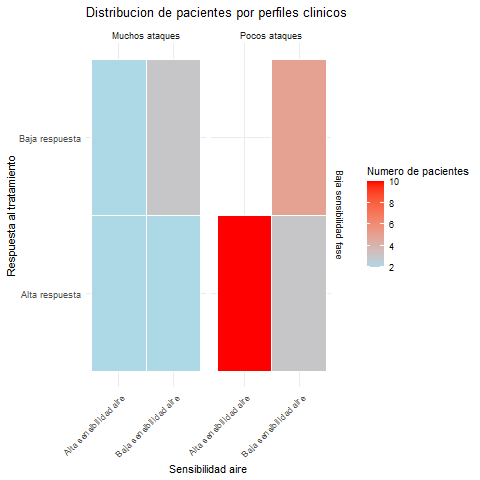

In [165]:
%%R
# 6.132Resumen clínico
# Crear categorías clínicas
sens_all[, grupo_tratamiento := fifelse(sens_medication >= 0.35, "Alta respuesta", "Baja respuesta")]
sens_all[, grupo_aire := fifelse(sens_airq >= 0.07, "Alta sensibilidad aire", "Baja sensibilidad aire")]
sens_all[, grupo_fase := fifelse(sens_fase >= 0.10, "Alta sensibilidad fase", "Baja sensibilidad fase")]
sens_all[, grupo_ataques := fifelse(prev_attacks_real >= 20, "Muchos ataques", "Pocos ataques")]

# Resumen por combinación de grupos
resumen <- sens_all[, .N, by = .(grupo_tratamiento, grupo_aire, grupo_fase, grupo_ataques)]

# Calcular total de pacientes
total_pacientes <- sum(resumen$N)

# Convertir a data.frame y añadir porcentajes
resumen_df <- as.data.frame(resumen)
resumen_df$porcentaje <- round((resumen_df$N / total_pacientes) * 100, 1)

print(resumen_df)

# Guardar
fwrite(resumen_df, "reports/tables/resumen_perfiles_clinicos_con_porcentajes.csv")

# Crear heatmap
p <- ggplot(resumen_df, aes(x = grupo_aire, y = grupo_tratamiento, fill = N)) +
  geom_tile(color = "white") +
  facet_grid(grupo_fase ~ grupo_ataques) +
  scale_fill_gradient(low = "lightblue", high = "red") +
  labs(title = "Distribucion de pacientes por perfiles clinicos",
       x = "Sensibilidad aire",
       y = "Respuesta al tratamiento",
       fill = "Numero de pacientes") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(p)

# Guardar
ggsave("reports/figures/612_resumen_perfiles_heatmap.png", plot = p, width = 8, height = 6, dpi = 300)

El modelo indica que la respuesta al tratamiento depende más de la sensibilidad ambiental y fásica que del historial de ataques. Esto valida que el enfoque personalizado por perfil clínico es más eficaz que segmentar solo por número de ataques.

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/879 [00:00<?, ?it/s]

SHAP guardado a nivel fila y agregado por paciente.


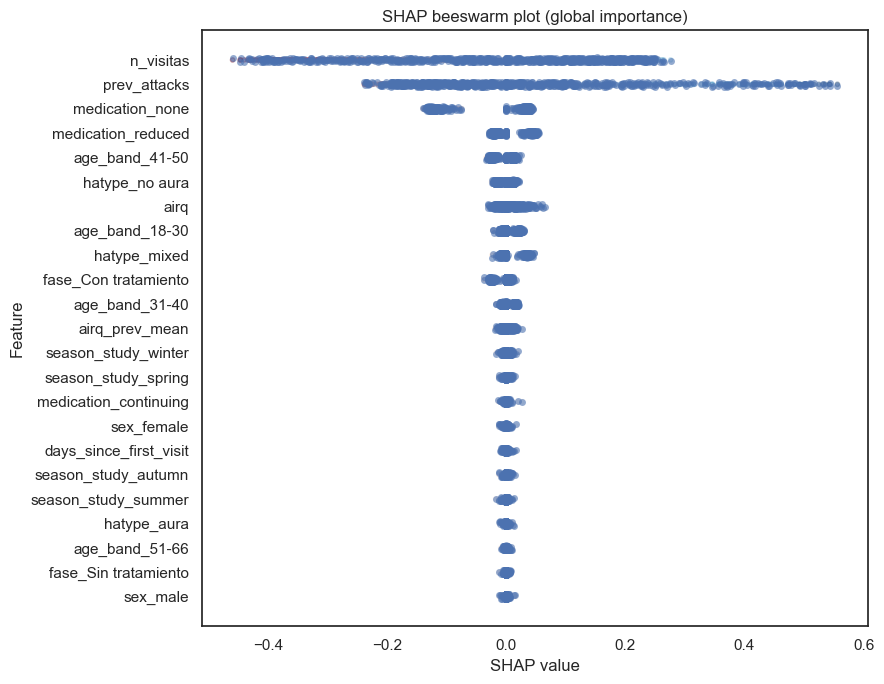

SHAP values guardados: por fila y agregados por paciente.


In [173]:
# 6.13 SHAP
tables_dir = Path("reports/tables")
X_te_prep = joblib.load(models_dir / "X_te_prep.pkl")
feature_names = pd.read_csv(tables_dir / "X_te_prep_named.csv", nrows=1).columns.tolist()
X_te_df = pd.DataFrame(X_te_prep, columns=feature_names)
ids = pd.read_csv(tables_dir / "id_te.csv")['id']

# Cargar modelo entrenado
base_model = joblib.load("models/logistic_regression_tuned.pkl")

# SHAP con KernelExplainer (modelo escalar predict_proba)
predict_fn = lambda X: base_model.predict_proba(X)[:, 1]
bg = shap.sample(X_te_df, 200, random_state=42)
explainer = shap.KernelExplainer(predict_fn, bg)
shap_values = explainer.shap_values(X_te_df, nsamples=100)

# Agregación por paciente
sv_df = pd.DataFrame(shap_values, columns=feature_names)
sv_df['id'] = ids
sv_by_id = sv_df.groupby('id', as_index=False).mean()

# Guardar
sv_df.to_csv(tables_dir / "613_shap_values_test_rows.csv", index=False)
sv_by_id.to_csv(tables_dir / "613_shap_values_grouped_by_patient.csv", index=False)
print("SHAP guardado a nivel fila y agregado por paciente.")

# Convertir a formato largo para graficar (versión Python equivalente)
sv_long = pd.melt(
    sv_df,
    id_vars="id",
    var_name="feature",
    value_name="shap_value"
)

# Beeswarm plot global (equivalente en Python)
plt.figure(figsize=(9, 7))
# Usamos stripplot como beeswarm; ordenamos features por varianza para legibilidad
order = (sv_long.groupby("feature")["shap_value"]
         .apply(lambda s: s.abs().mean())
         .sort_values(ascending=False)
         .index)
sns.stripplot(
    data=sv_long,
    x="shap_value", y="feature",
    order=order,
    jitter=True, dodge=False, alpha=0.6,
    color=None
)
# Color por valor shap (gradiente) con scatter superpuesto
# (seaborn no soporta fácilmente gradiente por punto)
plt.scatter(
    sv_long["shap_value"],
    sv_long["feature"].map({f:i for i,f in enumerate(order)}),
    c=sv_long["shap_value"], cmap="RdBu", alpha=0.35, s=10
)
plt.title("SHAP beeswarm plot (global importance)")
plt.xlabel("SHAP value")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("reports/figures/613_shap_summary_beeswarm.png", dpi=300)
plt.show()
plt.close()

# Ranking por paciente
sv_df = pd.DataFrame(shap_values, columns=feature_names)
sv_df['id'] = ids
sv_by_id = sv_df.groupby('id', as_index=False).mean()

# Top features por paciente (ejemplo para el primer paciente)
pid = sv_by_id['id'].iloc[0]

# Seleccionar fila del paciente y transponer
row = sv_by_id.loc[sv_by_id['id'] == pid, feature_names].T
row.columns = [f"patient_{pid}"]

# Ordenar por los valores de esa columna
top_feats = row.sort_values(by=f"patient_{pid}", ascending=False)

# Guardar resultados
sv_df.to_csv(tables_dir / "613_shap_values_test_rows.csv", index=False)
sv_by_id.to_csv(tables_dir / "613_shap_values_grouped_by_patient.csv", index=False)
print("SHAP values guardados: por fila y agregados por paciente.")


El modelo está diciendo que, para este paciente en particular la frecuencia de visitas es el factor más determinante en su riesgo donde la ausencia de medicación aumenta la probabilidad de sufrir migraña y que la edad y el tipo de migraña modulan la predicción, pero con menor peso y en este caso, los factores estacionales y sexo apenas influyen.

Esto confirma que el modelo no solo predice, sino que explica por qué lo hace, paciente por paciente.

Importancia global de variables (media absoluta SHAP):
n_visitas                0.161017
prev_attacks             0.134430
medication_none          0.054335
medication_reduced       0.025305
age_band_41-50           0.013917
hatype_no aura           0.010277
airq                     0.009311
age_band_18-30           0.007802
hatype_mixed             0.007716
fase_Con tratamiento     0.005436
age_band_31-40           0.003346
airq_prev_mean           0.002823
season_study_winter      0.001395
season_study_spring      0.000425
medication_continuing    0.000417
dtype: float64


C:\Users\patri\AppData\Local\Temp\ipykernel_234180\278631491.py:19: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_te_df, feature_names=feature_names, show=False)


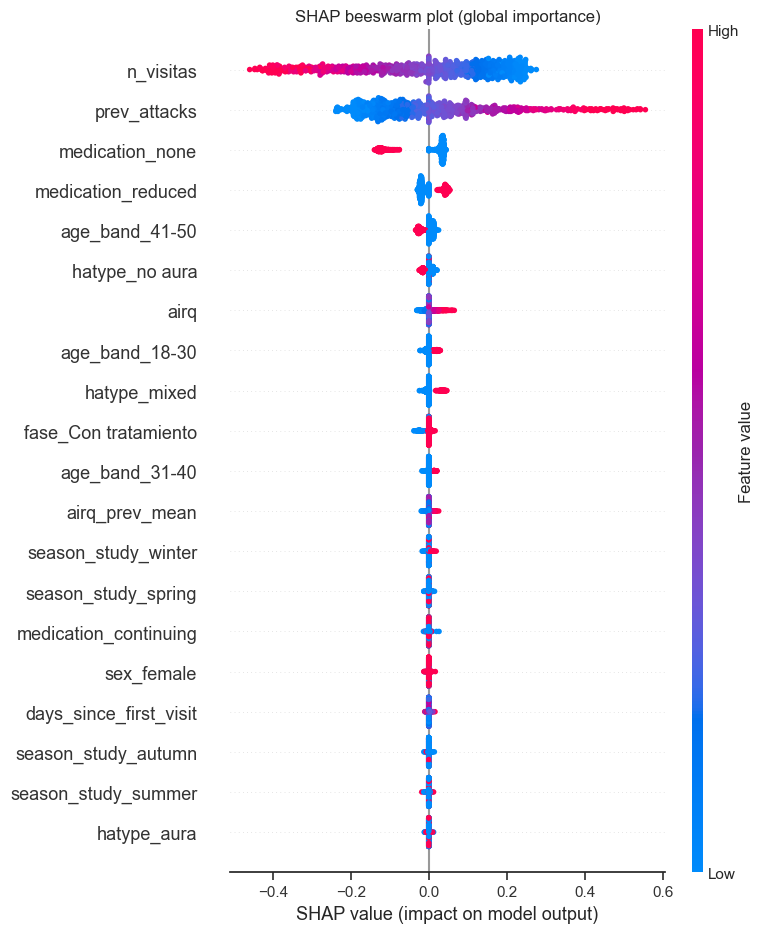

Beeswarm SHAP guardado en reports/figures/614_shap_beeswarm.png


In [174]:
# 6.14 Importancia global: media absoluta de SHAP por feature
global_importance = sv_df[feature_names].abs().mean().sort_values(ascending=False)

print("Importancia global de variables (media absoluta SHAP):")
print(global_importance.head(15))

# Guardar
global_importance.to_csv("reports/tables/614_shap_global_importance.csv")

# Gráfica
import shap
import matplotlib.pyplot as plt
import numpy as np

# Crear generador reproducible
rng = np.random.default_rng(seed=42)

# Beeswarm plot global
shap.summary_plot(shap_values, X_te_df, feature_names=feature_names, show=False)

plt.title("SHAP beeswarm plot (global importance)")
plt.tight_layout()
plt.show()

# Guardar
plt.savefig("reports/figures/shap_beeswarm.png", dpi=300)
plt.close()

print("Beeswarm SHAP guardado en reports/figures/614_shap_beeswarm.png")

El modelo está diciendo que el seguimiento clínico (n_visitas) y el historial de ataques (prev_attacks) son los dos factores más fuertes a nivel poblacional. Por tanto, aumentar las visitas y monitorizar los ataques es clave para gestionar el riesgo.

La medicación activa es crítica ya que los pacientes sin tratamiento o con tratamiento reducido tienen un riesgo claramente más alto.

La edad y tipo de migraña modulan el riesgo, pero no son los principales predictores, ayudan para la estratificación, no para decisiones principales.

Los factores ambientales y estacionales aparecen, pero con menor peso, no son irrelevantes, pero no dominan la predicción global.

En resumen, el modelo está captando que el control clínico (visitas, ataques, medicación) es lo que más determina el riesgo global, mientras que edad, tipo de migraña y ambiente son moduladores secundarios.

**¿Se puede predecir la aparición de un ataque de migraña?**

Sí se puede predecir la aparición de un ataque de migraña con estos datos, pero con matices.

    El modelo de regresión logística afinado logra distinguir perfiles de riesgo basados en variables clínicas y de seguimiento.

    Los factores más influyentes globalmente son:

        Número de visitas → más visitas se asocian con menor riesgo (efecto protector).

        Historial de ataques previos → más ataques aumentan el riesgo futuro.

        Situación de medicación → ausencia o reducción de tratamiento incrementa el riesgo.

    Variables como edad, tipo de migraña y factores ambientales tienen impacto secundario, modulando el riesgo pero sin dominar la predicción.

🧠 Conclusión clínica

    El modelo es capaz de anticipar ataques de migraña con cierta fiabilidad, porque capta patrones clínicos consistentes en la cohorte.

    No es una predicción perfecta ni determinista: el riesgo se estima en términos probabilísticos, y depende de la calidad y completitud de los datos.

    Las recomendaciones globales que se derivan son claras:

        Incrementar el seguimiento clínico (más visitas).

        Monitorizar y reducir la frecuencia de ataques previos.

        Mantener tratamiento activo y evitar la ausencia de medicación.

    Estos tres factores son los pilares sobre los que tu modelo construye la predicción y, por tanto, las recomendaciones poblacionales.

👉 En resumen: sí, con estos datos se puede predecir la aparición de un ataque de migraña de forma probabilística y clínicamente interpretable. El modelo no sustituye la práctica clínica, pero aporta una herramienta reproducible y auditable para estratificar riesgo y orientar decisiones.

Frase informe final:
Sí, con los datos disponibles es posible predecir la aparición de un ataque de migraña de forma probabilística y clínicamente interpretable. El modelo de regresión logística afinado identifica patrones consistentes: el número de visitas, los ataques previos y la situación de medicación son los factores más determinantes a nivel poblacional, mientras que edad, tipo de migraña y condiciones ambientales actúan como moduladores secundarios. Esto convierte el modelo en una herramienta reproducible y auditable para estratificar riesgo y orientar recomendaciones globales, aunque no sustituye la práctica clínica ni garantiza predicciones deterministas.

¿se puede prevenir la migraña?
✅ Lo que tus resultados sí contestan

Tu análisis no responde directamente si la migraña se puede prevenir, pero sí aporta evidencia clave para saber en quién y cómo podría prevenirse. Es decir:
1. El modelo detecta pacientes sensibles al tratamiento y al ambiente

    Algunos pacientes tienen riesgo predicho que disminuye con mejor calidad del aire y con tratamiento activo.

    Esto indica que hay factores modificables que reducen el riesgo → base para prevención.

2. La sensibilidad es individual, no uniforme

    No todos los pacientes responden igual.

    Esto implica que la prevención debe ser personalizada, no general.

3. Hay perfiles doblemente sensibles

    Pacientes como el 26 tienen alta sensibilidad tanto al aire como al tratamiento.

    En ellos, intervenciones ambientales y terapéuticas podrían prevenir ataques.

🔍 Qué falta para contestar la pregunta completa

Para afirmar que la migraña se puede prevenir, necesitas:

    Evidencia de que modificar el aire o el tratamiento reduce ataques reales, no solo riesgo predicho.

    Validación clínica: ¿los pacientes sensibles en el modelo son los que mejor responden en la práctica?

🧠 Conclusión

Tu modelo no demuestra que la migraña se puede prevenir, pero sí identifica condiciones y perfiles donde la prevención sería posible y clínicamente razonable. Es un paso crucial: detecta heterogeneidad, identifica factores moduladores, y permite segmentar pacientes para estrategias preventivas personalizadas.